In [4]:
import numpy as np

from scipy import integrate
from scipy import linalg
from scipy import spatial

from scipy import special

from scipy import stats

from scipy.optimize import fsolve

import networkx as netx

import itertools

import random

from jupyterthemes import jtplot

jtplot.style(theme='grade3',context='talk',fscale=1.4, spines=True, gridlines='--')

import matplotlib.pyplot as plt

import cycler


### Define initial pool

In [44]:
N_sp = 10

u = -0.5

sig = 0.3

spars = 0.25

mu = u/(spars*N_sp)
    
sd = sig/np.sqrt(spars*N_sp)

K = np.random.normal(1,0.2,N_sp)
r = np.random.normal(1,0.01,N_sp)

rng = np.random.default_rng()

A = np.asarray( [[ rng.choice( [np.random.normal(mu, sd, 1)[0], 0], 1, p = [spars,1 - spars] )[0] if j>i
                 else 0 for j in range(N_sp)] for i in range(N_sp) ])


A = np.asarray([[ np.random.normal(mu, sd, 1)[0] if i>j and A[j,i]!=0 else A[i,j] for j in range(N_sp) ] for i in range(N_sp)])



### Function for ODE solver

In [45]:
def f(t,y,A,r,K,N_sp):
    y = np.asarray([y[i] if y[i] > 10**-5 else 0 for i in range(len(y))])
    return y*( r  + A@y  -  ( (r/K)*np.eye(N_sp) )@y  )

### Solving for given ecosystem

In [46]:
y0 = np.random.normal(1,0.1,N_sp)

sol = integrate.solve_ivp(f, [0,50000], y0, args = (A,r,K,N_sp), vectorized = False)

In [47]:
## Check for feasible solution

print(sol.y[:,len(sol.t) - 1])

[0.48240872 0.84454641 0.7206746  0.58197207 0.91497054 0.06175624
 0.46501148 0.88813692 0.93346177 1.07056364]


### Add species successively

Pick random species in pool, and create another species with similar interaction strength profile. Try N_sp times as long as feasible solution is achieved.

In [11]:
def f_temp(t,y,A_temp,r_temp,K_temp,N_temp):
    y = np.asarray([y[i] if y[i] > 10**-5 else 0 for i in range(len(y))])
    return y*( r_temp + A_temp@y - ( ( r_temp/K_temp )*np.eye(N_temp) )@y ) 

## Evolve trajectory using guess for invader's abundance

In [ ]:
def solbest_ui(A_real,A_ui,fitness_0, sol_final, y0):
        
    J_inv = np.linalg.inv( A_ui[0:-1,0:-1] )
    
    slope_fitness = A_ui[-1,0:-1]@(-J_inv)@A_ui[0:-1,-1] - r_temp[-1]/K_temp[-1]
    
    pitstops_0 = 5

    pitstops = 5
    
    print(slope_fitness)
    print(K_temp[-1])
    
    if fitness_0 > 0:
        if slope_fitness < 0:
            n0_init = y0[-1] 
            step_sign = -1 if slope_fitness <= -r_temp[-1]/K_temp[-1] and np.abs(fitness_0/slope_fitness) < 0.01 else 1
            print(step_sign)
        else:
            n0_init = y0[-1]
#             print(n0_init)
            step_sign = 1 
    else:
        if slope_fitness > 0 and y0[-1]>0.1:
            n0_init = y0[-1]
#             print(n0_init)
            step_sign = 0 if np.abs(fitness_0/slope_fitness) < 1 else -1
        else:
            n0_init = y0[-1]
            step_sign = -1


    while True:
        
        ### n0_update stores abundances at different times across time evolution (to calculate distances from)

        n0_update = np.asarray([n0_init + 0.01*n0_init*i*step_sign for i in range(pitstops)])
        
        ## Add number of pairs if checking extinction of species pairs. 
        # Note that extinct pairs can't include invader
        
#         pairs = 0   # Set pairs=0 if only considering single species extinctions
        
        pairs = int( ( (len(sol_final)-1)*(len(sol_final)-2) )/2 ) 
        
        index_arr = np.arange(len(sol_final))    ## Index list with only indices for single species  
    
        #### Generate pairs 
        seed_pair = np.arange(len(sol_final)-1)      
        dead_pair = seed_pair[np.stack(np.triu_indices(len(seed_pair), k=1), axis=-1)]
    
        index_arr = np.insert(index_arr,0,-1)     ## Add index for no extinctions
        
        index_list = list(index_arr)
        
        for i in dead_pair:
            index_list.append(i)
        
        to_delete = []
        
        kld_atrim = np.zeros((len(sol_final) + pairs + 1,pitstops + 1))    

        dist = np.zeros((len(sol_final) + pairs + 1,pitstops + 1))    
                        
        y_ui = np.linalg.solve(A_ui, -r_temp)

        if slope_fitness < 0 and step_sign == 1 and np.abs(fitness_0/slope_fitness) < 10:
            y0_final = np.abs(fitness_0/slope_fitness)
        elif slope_fitness > 0 and step_sign != -1:
            y0_final = K_temp[-1]
        else:
            y0_final = y_ui[-1]
            

        
        if np.any(y_ui<=10**-5) or (step_sign == -1) or (slope_fitness > 0):
            to_delete.append(0)
        else:
            kld_atrim[0,0] = stats.entropy( y_ui , y0 ) 
            dist[0,0] = -np.abs( y_ui - y0 )@(A_ui+A_ui.T)@np.abs( y_ui - y0 )

            kld_atrim[0,1:] = np.asarray([ stats.entropy( y_ui , np.concatenate( (y0[0:-1],[n0_init + (y0_final - n0_init)*i/(pitstops-1)] )) ) for i in range(pitstops) ])
            dist[0,1:] = np.asarray([ -np.abs( y_ui - np.concatenate( (y0[0:-1],[n0_init + (y0_final - n0_init)*i/(pitstops-1)] ) ) )@(A_ui+A_ui.T)@np.abs( y_ui - np.concatenate( (y0[0:-1],[n0_init + (y0_final - n0_init)*i/(pitstops-1)] ) ) ) for i in range(pitstops) ])
        
        for dead_ind in range(len(sol_final)):

            A_ui2 = np.delete(A_ui, dead_ind, 0)
            A_ui2 = np.delete(A_ui2, dead_ind, 1)
            r_ui2 = np.delete(r_temp, dead_ind, 0)
            
            y_ui = np.linalg.solve(A_ui2, -r_ui2)
            
            if(np.any(y_ui<=10**-5)) and dead_ind!=len(sol_final)-1:
                to_delete.append(dead_ind+1)
                continue
                
            y_ui = np.insert( y_ui, dead_ind, 0 )
            
            if slope_fitness < 0 and step_sign == 1 and np.abs(fitness_0/slope_fitness) < 10:
                y0_final = np.abs(fitness_0/slope_fitness)
            elif slope_fitness > 0 and step_sign != -1:
                y0_final = K_temp[-1]
            else:
                y0_final = y_ui[-1]
            
            y_next = np.copy(y0)
            
            if step_sign == 1 and dead_ind==len(sol_final)-1:
                to_delete.append(dead_ind+1)
                continue
            elif step_sign == -1 and dead_ind!=len(sol_final)-1:
                to_delete.append(dead_ind+1)
                continue
            else: 
                kld_atrim[dead_ind+1,0] = stats.entropy( y_ui , y_next)
                dist[dead_ind+1,0] = -np.abs( y_ui - y_next )@(A_ui+A_ui.T)@np.abs( y_ui - y_next )

                kld_atrim[dead_ind+1,1:] = np.asarray([ stats.entropy( y_ui , np.concatenate( (y0[0:-1],[n0_init + (y0_final - n0_init)*i/(pitstops-1)] )) ) for i in range(pitstops) ])
                dist[dead_ind+1,1:] = np.asarray([ -np.abs( y_ui - np.concatenate( (y0[0:-1],[n0_init + (y0_final - n0_init)*i/(pitstops-1)] ) ) )@(A_ui+A_ui.T)@np.abs( y_ui - np.concatenate( (y0[0:-1],[n0_init + (y0_final - n0_init)*i/(pitstops-1)] ) ) ) for i in range(pitstops) ])
        


        pair_ind = len(sol_final)
        
        for dead_ind in dead_pair:
            
            A_ui2 = np.delete(A_ui, dead_ind, 0)
            A_ui2 = np.delete(A_ui2, dead_ind, 1)
            r_ui2 = np.delete(r_temp, dead_ind, 0)
            
            y_ui = np.linalg.solve(A_ui2, -r_ui2)
            
            if(np.any(y_ui<=10**-5)):
                to_delete.append(pair_ind+1)
                pair_ind = pair_ind + 1
                continue
            
            yui_temp = np.insert( y_ui,dead_ind[0],0 )
            y_ui = np.insert( yui_temp,dead_ind[1],0 )

            y_next = np.copy(y0)
            
            if slope_fitness < 0 and step_sign == 1 and np.abs(fitness_0/slope_fitness) < 10:
                y0_final = np.abs(fitness_0/slope_fitness)
            elif slope_fitness > 0 and step_sign != -1:
                y0_final = K_temp[-1]
            else:
                y0_final = y_ui[-1]
            
            
            if step_sign==-1:
                to_delete.append(pair_ind+1)
                pair_ind = pair_ind + 1
                continue
            else:
                kld_atrim[pair_ind+1,0] = stats.entropy( y_ui, y0 )
                dist[pair_ind+1,0] = -np.abs( y_ui - y0 )@(A_ui+A_ui.T)@np.abs( y_ui - y0 )

                kld_atrim[pair_ind + 1,1:] = np.asarray([ stats.entropy( y_ui , np.concatenate( (y0[0:-1],[n0_init + (y0_final - n0_init)*i/(pitstops-1)] )) ) for i in range(pitstops) ])
                dist[pair_ind + 1,1:] = np.asarray([ -np.abs( y_ui - np.concatenate( (y0[0:-1],[n0_init + (y0_final - n0_init)*i/(pitstops-1)] ) ) )@(A_ui+A_ui.T)@np.abs( y_ui - np.concatenate( (y0[0:-1],[n0_init + (y0_final - n0_init)*i/(pitstops-1)] ) ) ) for i in range(pitstops) ])

                
            pair_ind = pair_ind + 1
        
        
        for i in sorted(to_delete, reverse=True):
            del index_list[i]
            
        to_delete = np.asarray(to_delete)
            
        kld_atrim = np.delete(kld_atrim, to_delete, 0)
        dist = np.delete(dist, to_delete, 0)
    
        mask = np.all(kld_atrim[:, 2:] < kld_atrim[:, 1:-1], axis=1)
        
        break
    
    
    print(extinct_ind)

    
    print(len(kld_atrim[mask,:]))
    if len(kld_atrim) !=0:
        if step_sign != -1 and len(kld_atrim[mask,:]) !=0 and slope_fitness < 0: #and fitness_0/slope_fitness < 0: ## Last condition ensures that both fitness and slope are not >0
#             pred = np.nonzero(mask)[0][np.argmin(dist[mask,0])]
            pred = np.nonzero(mask)[0][np.argmin(kld_atrim[mask,0])]
        else:
            pred = np.argmin(kld_atrim[:, 0])
#             pred = np.argmin(dist[:,0])

        print(pred)

        if type(index_list[pred]) == np.ndarray:
            return index_list[pred]
        else:
            return [index_list[pred]]
    else:
        return [-2]





## Explore local uninvadable landscape

In [52]:
extinct_ind = [ i for i in range(len(sol.y[:,len(sol.t) - 1])) if sol.y[i,len(sol.t) - 1] < 10**-5 ]
    
y0_best = np.asarray([sol.y[i,len(sol.t) - 1] for i in range(len(sol.y[:,len(sol.t) - 1])) if sol.y[i,len(sol.t) - 1] > 10**-5 ])

A_best = np.delete(A, extinct_ind, 0)
A_best = np.delete(A_best, extinct_ind, 1)
r_best = np.delete(r, extinct_ind, 0)
K_best = np.delete(K, extinct_ind, 0)
N_best = len(r_best)
sol_best = sol

sp_corr = 0.8

u = -1.5

sig = 0.5

# spars = 0.25

s_rich = []              ## Array to store species richness after every invasion


uninvad_pred = []

deviate_Atemp = []

deviate_Aui = []

deviate_y0 = []

deviate_solbest = []

deviate_Usol = []

invasion_fitness = []

pred_success = []

for i in range(10000):
    
    n0 = np.random.normal(1,0.1,1)[0] ## Initial invader abundance
    
    mu = u/(spars*(N_best+1))
    
    sd = sig/np.sqrt(spars*(N_best+1))
    
    cov_mat = np.asarray( [ [sd**2 if i==j else (sd**2)*sp_corr for j in range(2)] for i in range(2) ] )

    L = np.linalg.cholesky(cov_mat) ## Cholesky decomposition to set up desired correlation between interactions

    select_sp = np.random.choice(N_best, 1)[0]

    A_temp = np.zeros((N_best+1,N_best+1))

    A_temp[0:N_best, 0:N_best] = A_best
    
    beta = np.random.normal(1,0.1,1)[0]
    
    y0 = np.asarray([ y0_best[i] if i < N_best else n0 for i in range(N_best+1) ])
    
    print(y0[-2:])

    r_temp = np.asarray([ r_best[i] if i < N_best else np.random.normal(1,0.01,1)[0] for i in range(N_best+1) ])

    K_temp = np.asarray([ K_best[i] if i < N_best else np.random.normal(1,0.2,1)[0] for i in range(N_best+1) ])
    
    while(np.all(A_temp[N_best,0:N_best]==0)):
        
        ######### Check approach 2 under case of invading species in Methods section ######
    
        A_temp[N_best,0:N_best] = [ rng.choice( [L[1,0]*A_temp[select_sp,i]/L[0,0] + L[1,1]*np.random.normal(mu, sd, 1)[0], 0], 1, p = [spars,1 - spars] )[0] if i!=select_sp 
                                     else np.random.normal(mu, sd, 1)[0] for i in range(N_best) ]

        A_temp[0:N_best,N_best] = [ L[1,0]*A_temp[i,select_sp]/L[0,0] + L[1,1]*np.random.normal(mu, sd, 1)[0] if A_temp[N_best,i]!=0 and i!=select_sp 
                                     else L[1,0]*A_temp[-1,select_sp]/L[0,0] + L[1,1]*np.random.normal(mu, sd, 1)[0] if i==select_sp else 0 for i in range(N_best) ]

        #############################################
        
        
        ########## Approach 1 for drawing interactions #####################
        
#     A_temp[N_best,0:N_best] = [ rng.choice( [L[1,0]*A_best[select_sp,i]/L[0,0] + L[1,1]*np.random.normal(mu, sd, 1)[0], 0], 1, p = [spars,1 - spars] )[0] if i!=select_sp 
#                                  else -((r_temp[select_sp]/K_temp[select_sp] + r_temp[-1]/K_temp[-1])-beta) for i in range(N_best) ]

#     A_temp[0:N_best,N_best] = [ L[1,0]*A_best[i,select_sp]/L[0,0] + L[1,1]*np.random.normal(mu, sd, 1)[0] if A_temp[N_best,i]!=0 and i!=select_sp 
#                                  else -beta if i==select_sp else 0 for i in range(N_best) ]
    
        ################################################
        
        
        ##########  Approach 2 but completely uncorrelated interactions #############
    
#     while(np.all(A_temp[N_best,0:N_best]==0)):
#         A_temp[N_best,0:N_best] = [ rng.choice( [np.random.normal(mu, sd, 1)[0], 0], 1, p = [spars,1 - spars] )[0] for i in range(N_best) ]

#         A_temp[0:N_best,N_best] = [ np.random.normal(mu, sd, 1)[0] if A_temp[N_best,i]!=0 else 0 for i in range(N_best) ]
    
        ##################################################
    
    sol_temp = integrate.solve_ivp(f_temp, [0,5000], y0, args = (A_temp,r_temp,K_temp,N_best+1))
    
    if np.amax(sol_temp.y[:,-1]) > 100:
        print(np.amax(sol_temp.y[:,-1]))
        continue
    
#     if np.amin(sol_temp.y[:,len(sol_temp.t) - 1]) > 10**-5:
    maybe_dead = np.flatnonzero(sol_temp.y[:,-1] < 10**-3)  ### Quick check for dead species ###

    if len(maybe_dead) > 0:
        A_trunc = np.delete(A_temp, maybe_dead, 0)
        A_trunc = np.delete(A_trunc, maybe_dead, 1)
        r_trunc = np.delete(r_temp, maybe_dead, 0)
        K_trunc = np.delete(K_temp, maybe_dead, 0)

        pop_trunc = np.linalg.solve( A_trunc - (r_trunc/K_trunc)*np.eye(len(A_trunc)), -r_trunc )

        if np.amin(pop_trunc) > 10**-5:
            extinct_ind = maybe_dead
        else:
            sol_temp = integrate.solve_ivp(f_temp, [0,20000], y0, args = (A_temp,r_temp,K_temp,N_best+1))
            maybe_dead = np.flatnonzero(sol_temp.y[:,-1] < 10**-3)
            A_trunc = np.delete(A_temp, maybe_dead, 0)
            A_trunc = np.delete(A_trunc, maybe_dead, 1)
            r_trunc = np.delete(r_temp, maybe_dead, 0)
            K_trunc = np.delete(K_temp, maybe_dead, 0)
            pop_trunc = np.linalg.solve( A_trunc - (r_trunc/K_trunc)*np.eye(len(A_trunc)), -r_trunc )
            extinct_ind = maybe_dead

    else:
        pop_trunc = np.linalg.solve(A_temp - (r_temp/K_temp)*np.eye(len(A_temp)), -r_temp )
        if np.amin(pop_trunc) > 10**-5:
            extinct_ind = []
        else:
            sol_temp = integrate.solve_ivp(f_temp, [0,20000], y0, args = (A_temp,r_temp,K_temp,N_best+1))
            maybe_dead = np.flatnonzero(sol_temp.y[:,-1] < 10**-3)
            A_trunc = np.delete(A_temp, maybe_dead, 0)
            A_trunc = np.delete(A_trunc, maybe_dead, 1)
            r_trunc = np.delete(r_temp, maybe_dead, 0)
            K_trunc = np.delete(K_temp, maybe_dead, 0)
            pop_trunc = np.linalg.solve( A_trunc - (r_trunc/K_trunc)*np.eye(len(A_trunc)), -r_trunc )
            extinct_ind = maybe_dead
#     else:
#         extinct_ind = [ i for i in range(len(sol_temp.y[:,len(sol_temp.t) - 1])) if sol_temp.y[i,len(sol_temp.t) - 1] < 10**-5 ]

#     print(select_sp)   ## Print randomly selected species for competing allele
#     print(extinct_ind)   ## Indices of species gone extinct
    
    A_best = np.delete(A_temp, extinct_ind, 0)
    A_best = np.delete(A_best, extinct_ind, 1)
    r_best = np.delete(r_temp, extinct_ind, 0)
    K_best = np.delete(K_temp, extinct_ind, 0)
    N_best = len(r_best)
    sol_best = sol_temp ## Note that sol_best could have negative values                            
#     y0_best = np.delete(sol_best.y[:,-1], extinct_ind, 0)  ## y0_best from simulations
    y0_best = np.linalg.solve( A_best - (r_best/K_best)*np.eye(len(A_best)), -r_best )
        
    s_rich.append(N_best)
    
    ### Check closest uninvadable equilibria ###
    
#     noise_mat = np.random.normal(0,sd/5, A_temp.shape)  ## Adding noise
    
#     noise_mat = np.asarray([[np.random.normal(0,sd/3, 1)[0] if A_temp[i,j]!=0 else 0 for j in range(len(A_temp))] for i in range(len(A_temp))])
    
    A_rand = np.copy(A_temp) #+ noise_mat
    
    A_ui = A_rand - (r_temp/K_temp)*np.eye(len(A_temp)) 
    
    max_eig = np.amax(np.linalg.eigvals(A_ui + A_ui.T)) ## max_eig checks for negative definite matrix
    
    
    if max_eig > 0: ## Working with a displaced matrix that is uninvadable
        A_ui = A_ui - (max_eig/2+10**-10)*np.eye(len(A_ui))
        
    fitness_0 = r_temp[-1] + y0@A_rand[-1]
    
    print(fitness_0)
    
    sol_final = sol_best.y[:,-1]
    
    extinct_ui = solbest_ui(A_rand,A_ui,fitness_0, sol_final, y0)
    
    print(extinct_ui)
    
    if len(extinct_ind) > 0:
        if np.array_equal(extinct_ui,[-2]) or not(np.array_equal(extinct_ind,extinct_ui)):
            invasion_fitness.append(fitness_0)
            deviate_Atemp.append(A_temp)
            deviate_Aui.append(A_ui)
            deviate_y0.append(y0)
            deviate_solbest.append(sol_final)
            
    elif np.any(extinct_ui!=[-1]):
        invasion_fitness.append(fitness_0)
        deviate_Atemp.append(A_temp)
        deviate_Aui.append(A_ui)
        deviate_y0.append(y0)
        deviate_solbest.append(sol_final)
        
#     if i==0:
    if len(extinct_ui) > len(extinct_ind) and np.any(extinct_ui!=[-1]):
        pred_success.append(0.0)
    elif len(extinct_ind) == 0 and np.any(extinct_ui==[-1]):
        pred_success.append(1.0)
    else:
        fract = len(np.nonzero([ i in extinct_ind for i in extinct_ui ])[0])/len(extinct_ind)
        pred_success.append( fract )
    
    print(pred_success[-1])
            

print(sol_final)

print(len(sol_final))

[1.07056364 0.1       ]
-0.1849836259189075
-0.31687162269359337
1.1327899816007785
[10]
1
0
[10]
1.0
[1.07039261 0.1       ]
-0.19483120940125254
-0.4193799653722614
0.993469830645438
[10]
1
0
[10]
1.0
[1.07039261 0.1       ]
-0.1566162503707793
-0.41693574286041724
0.8491486510601924
[10]
1
0
[10]
1.0
[1.07039261 0.1       ]
-0.025165720370058486
-0.20634646082194175
1.2718572963105514
[10]
1
0
[10]
1.0
[1.07039261 0.1       ]
-0.33291686345819804
-0.49251474160168474
1.1128586885944396
[10]
1
0
[10]
1.0
[1.07039261 0.1       ]
-0.30330656708482273
-0.2880835445146297
0.9778932193135411
[10]
1
0
[10]
1.0
[1.07039261 0.1       ]
-0.9124688687541216
-0.3061060701215994
1.2079471987644692
[10]
1
0
[10]
1.0
[1.07039261 0.1       ]
-0.31309165061848687
-0.006105064997485088
1.2591864482880417
[10]
1
0
[10]
1.0
[1.07039261 0.1       ]
0.3750230551548246
-1.3414054676124212
0.868224172872661
1
[]
27
4
[5]
0.0
[0.27801254 0.1       ]
-0.013184881442957597
-0.22771628525634724
0.9837773997827

0.19308827474784496
-0.8428806036609318
1.0520700261962277
1
[]
165
0
[-1]
1.0
[0.22908141 0.1       ]
0.4595090300790483
-0.3656887981183988
1.380198471788308
1
[ 9 22]
64
3
[15]
0.0
[1.20185139 0.1       ]
0.1957791799326245
-1.1561620581721883
0.7728946091337529
1
[]
172
0
[-1]
1.0
[0.16933541 0.1       ]
0.7178702299646821
-1.0074931461545436
1.012098262165405
1
[]
305
0
[-1]
1.0
[0.71253113 0.1       ]
0.7701463228138541
-0.9102620661282822
1.0758325381548823
1
[]
275
0
[-1]
1.0
[0.84607098 0.1       ]
0.8181756766671012
-0.8417331294912865
1.2359320786314956
1
[4]
80
26
[ 4 16]
0.0
[1.087235 0.1     ]
0.48499897658117364
-1.0193520128582731
0.8959776655598223
1
[]
293
0
[-1]
1.0
[0.47579145 0.1       ]
0.42724128428084884
-0.8519060887878505
1.1002279540063868
1
[]
359
0
[-1]
1.0
[0.50151219 0.1       ]
0.7411791288932708
-0.8866904667272323
1.160572167518706
1
[]
334
0
[-1]
1.0
[0.83589387 0.1       ]
0.33552443348948213
-1.432789117860799
0.9217658398546726
1
[8]
266
4
[8]
1.0


[]
3625
0
[-1]
1.0
[0.73886215 0.1       ]
0.87069861673629
-0.868716845084587
1.1147587133503245
1
[]
2736
0
[-1]
1.0
[1.00228126 0.1       ]
1.198784882710279
-0.81469418866694
1.2201331495279126
1
[]
3525
14
[13]
0.0
[1.47145383 0.1       ]
0.7722029005903229
-1.0173966173381
0.9865945177806434
1
[]
3624
0
[-1]
1.0
[0.75899889 0.1       ]
0.4268493237068519
-0.8817451596216677
1.1108264037199742
1
[]
3262
0
[-1]
1.0
[0.48409602 0.1       ]
0.5453050801518452
-0.8310848951096445
1.1690353318592992
1
[]
3405
0
[-1]
1.0
[0.65613643 0.1       ]
0.9304520350005959
-0.9579323856331748
1.0561889490076468
1
[]
3610
0
[-1]
1.0
[0.97131285 0.1       ]
0.7995425867209802
-1.4330955094226059
0.6976738907055371
1
[]
3464
0
[-1]
1.0
[0.55791298 0.1       ]
0.7321944180746878
-0.9303217812162573
1.0678094934955065
1
[]
3664
0
[-1]
1.0
[0.78703351 0.1       ]
0.7562159092291814
-0.6753534130155736
1.5009629610387063
1
[]
4478
0
[-1]
1.0
[1.1197336 0.1      ]
0.8032776038254961
-0.8803822812768286
1

KeyboardInterrupt: 

2556
[[ 0.          0.         -0.23181423  0.         -0.15365241  0.
  -0.22874192  0.          0.         -0.09070633 -0.10813608]
 [ 0.          0.          0.          0.02890573  0.          0.
   0.          0.         -0.41290848  0.          0.        ]
 [ 0.04711379  0.          0.          0.         -0.16680654  0.
   0.          0.          0.         -0.36145177  0.        ]
 [ 0.          0.11717282  0.          0.         -0.29805808 -0.13599955
   0.          0.          0.         -0.19088977 -0.27184226]
 [-0.17607586  0.         -0.02254164 -0.2237648   0.          0.
  -0.17586076  0.          0.         -0.10358756  0.        ]
 [ 0.          0.          0.         -0.00501754  0.          0.
   0.          0.         -0.23088831  0.         -1.05690105]
 [ 0.15734444  0.          0.          0.         -0.18533185  0.
   0.          0.         -0.24460898  0.         -0.17749375]
 [ 0.          0.          0.          0.          0.          0.
   0.          0. 

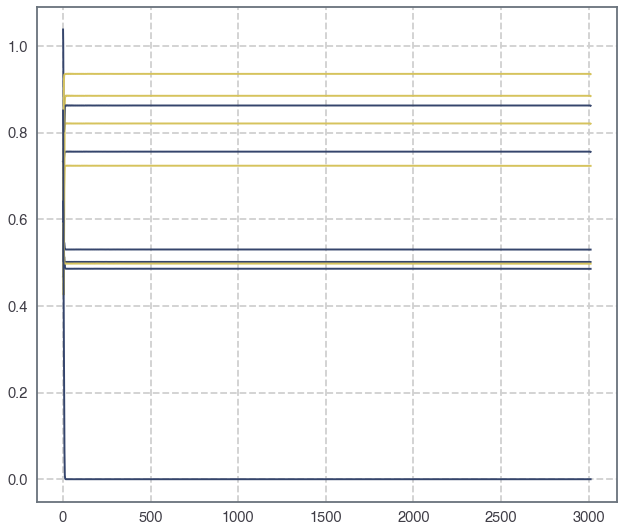

[-0.007312497243495697, 0.07620431947460782, -0.15141123229768572, -0.1596509312729859, 0.03391897089002116, -0.1124999447321191, 0.26102569716755664, 0.13116660154950988, 0.32892129356332966, -0.09185275420485783, 0.29895007702152343, -0.3530979191691933, 0.013593001467919086, -0.16249283893761457, -0.029546676048927356, -0.013689478480613304, 0.11491860665447962, 0.04495400654273529, 0.20068927571436768, 0.03803990806158419, 0.18116643211996286, 0.20045645419736913, -0.18610975498551396, 0.09289715647281294, 0.08153165479241531, 0.019632861984444694, -0.1708364677023242, -0.24219428886564953, 0.16327857005761992, -0.1912360600427061, 0.06931270142815393, 0.293958812928669, 0.11263626745132405, -0.020959195185358714, 0.06222558706085812, -0.2602449260991828, 0.19864219966595487, -0.10743557632270606, 0.07060850627504767, 0.1105904719764138, 0.09511669201943773, 0.1159039709649482, 0.11826695532648512, -0.06805538489706509, 0.014913214810534314, 0.4190487864638287, -0.06125121277018597

In [23]:
print(len(deviate_Atemp))
print(deviate_Atemp[0])
print(i)

ind = 0

print(deviate_y0[ind])

sol_temp = integrate.solve_ivp(f, [0,10000], deviate_y0[ind], args = (deviate_Atemp[ind],1,1,len(deviate_y0[ind])))

plt.plot(sol_temp.y.T)
plt.show()

print(invasion_fitness)
# print(deviate_solbest)
print(len(np.nonzero(deviate_Atemp[-1])[0]) )

# print(y0_best)

## Plots from simulations and save outputs

In [ ]:
plt.plot(pred_success,'bo', markersize=5,label = "$\mu$ = %.2f, $\sigma$ = %.2f" %(u,sig))
plt.xscale('log')
plt.xlabel('Number of invasion events', fontsize=20)
plt.ylabel('Prediction score', fontsize=20)
plt.title('Interaction correlation = 0.5 ')
plt.legend()
plt.show()

np.savetxt("pred_success_varires_rand2.csv", pred_success, delimiter=",")
np.savetxt("sp_richness_varires_rand2.csv", s_rich, delimiter=",")


### Computing nearest negative definite matrices a la Higham 1988 

In [245]:
mat = np.random.normal(0,0.2,400).reshape(20,20)

A_full = mat - np.eye(len(mat))
A_symm = A_full + A_full.T
eigval, eigvec = np.linalg.eig(A_symm)

eigs_plus = np.where(np.real(eigval) <= 0, eigval, -10**-15)*np.eye(len(eigval))

Aui_symm = eigvec@eigs_plus@eigvec.T 

eig,vec = np.linalg.eig(Aui_symm)

A_ui2 = A_full + (Aui_symm - A_symm)/2

### Compare with Aui from diagonal displacement

max_eig = np.amax(np.linalg.eigvals(A_full + A_full.T)) ## max_eig checks for negative definite matrix
    
if max_eig > 0: ## Working with a displaced matrix that is uninvadable
    A_ui = A_full - (max_eig/2+0.0001)*np.eye(len(A_full))
    
print(np.linalg.norm(A_full - A_ui))

print(np.linalg.norm(A_full - A_ui2))



0.4097604823917935
0.09152522931211705


### ^ Note that nearest NSD is always closer than simple diagonal displacement

## Invasion outcomes using Higham's nearest negative definite

In [24]:
extinct_ind = [ i for i in range(len(sol.y[:,len(sol.t) - 1])) if sol.y[i,len(sol.t) - 1] < 10**-5 ]
    
y0_best = np.asarray([sol.y[i,len(sol.t) - 1] for i in range(len(sol.y[:,len(sol.t) - 1])) if sol.y[i,len(sol.t) - 1] > 10**-5 ])

A_best = np.delete(A, extinct_ind, 0)
A_best = np.delete(A_best, extinct_ind, 1)
r_best = np.delete(r, extinct_ind, 0)
K_best = np.delete(K, extinct_ind, 0)
N_best = len(r_best)
sol_best = sol

sp_corr = 0.5

u = -1.5

sig = 0.5

s_rich = []              ## Array to store species richness after every invasion


uninvad_pred = []

deviate_Atemp = []

deviate_Aui = []

deviate_y0 = []

deviate_solbest = []

deviate_Usol = []

invasion_fitness = []

pred_success = []

rng = np.random.default_rng()

nsd_count = 0  ## negative semi-definite count

for i in range(10000):
    
    n0 = np.random.normal(1,0.1,1)[0] ## Initial invader abundance
    
    mu = u/(N_best+1)
    
    sd = sig/np.sqrt(N_best+1)
    
    cov_mat = np.asarray( [ [sd**2 if i==j else (sd**2)*sp_corr for j in range(2)] for i in range(2) ] )

    L = np.linalg.cholesky(cov_mat)

    select_sp = np.random.choice(N_best, 1)[0]

    A_temp = np.zeros((N_best+1,N_best+1))

    A_temp[0:N_best, 0:N_best] = A_best
    
    beta = np.random.normal(1,0.1,1)[0]
    
    y0 = np.asarray([ y0_best[i] if i < N_best else n0 for i in range(N_best+1) ])
    
    print(y0[-2:])

    r_temp = np.asarray([ r_best[i] if i < N_best else np.random.normal(1,0.01,1)[0] for i in range(N_best+1) ])

    K_temp = np.asarray([ K_best[i] if i < N_best else np.random.normal(1,0.2,1)[0] for i in range(N_best+1) ])
    
#     A_temp[N_best,0:N_best] = [ rng.choice( [L[1,0]*A_temp[select_sp,i]/L[0,0] + L[1,1]*np.random.normal(mu, sd, 1)[0], 0], 1, p = [spars,1 - spars] )[0] if i!=select_sp 
#                                  else np.random.normal(mu, sd, 1)[0] for i in range(N_best) ]

#     A_temp[0:N_best,N_best] = [ L[1,0]*A_temp[i,select_sp]/L[0,0] + L[1,1]*np.random.normal(mu, sd, 1)[0] if A_temp[N_best,i]!=0 and i!=select_sp 
#                                  else L[1,0]*A_temp[-1,select_sp]/L[0,0] + L[1,1]*np.random.normal(mu, sd, 1)[0] if i==select_sp else 0 for i in range(N_best) ]

    A_temp[N_best,0:N_best] = [ rng.choice( [L[1,0]*A_best[select_sp,i]/L[0,0] + L[1,1]*np.random.normal(mu, sd, 1)[0], 0], 1, p = [spars,1 - spars] )[0] if i!=select_sp 
                                 else -((r_temp[select_sp]/K_temp[select_sp] + r_temp[-1]/K_temp[-1])-beta) for i in range(N_best) ]

    A_temp[0:N_best,N_best] = [ L[1,0]*A_best[i,select_sp]/L[0,0] + L[1,1]*np.random.normal(mu, sd, 1)[0] if A_temp[N_best,i]!=0 and i!=select_sp 
                                 else -beta if i==select_sp else 0 for i in range(N_best) ]
    
#     A_temp[N_best,0:N_best] = [ rng.choice( [np.random.normal(mu, sd, 1)[0], 0], 1, p = [spars,1 - spars] )[0] for i in range(N_best) ]

#     A_temp[0:N_best,N_best] = [ np.random.normal(mu, sd, 1)[0] if A_temp[N_best,i]!=0 else 0 for i in range(N_best) ]

    sol_temp = integrate.solve_ivp(f_temp, [0,5000], y0, args = (A_temp,r_temp,K_temp,N_best+1))
    
    if np.amax(sol_temp.y[:,len(sol_temp.t) - 1]) > 100:
        continue
    
#     if np.amin(sol_temp.y[:,len(sol_temp.t) - 1]) > 10**-5:
    maybe_dead = np.flatnonzero(sol_temp.y[:,len(sol_temp.t) - 1] < 10**-3)

    if len(maybe_dead) > 0:
        A_trunc = np.delete(A_temp, maybe_dead, 0)
        A_trunc = np.delete(A_trunc, maybe_dead, 1)
        r_trunc = np.delete(r_temp, maybe_dead, 0)
        K_trunc = np.delete(K_temp, maybe_dead, 0)

        pop_trunc = np.linalg.solve( A_trunc - (r_trunc/K_trunc)*np.eye(len(A_trunc)), -r_trunc )

        if np.amin(pop_trunc) > 10**-5:
            extinct_ind = maybe_dead
        else:
            sol_temp = integrate.solve_ivp(f_temp, [0,20000], sol_temp.y[:,-1], args = (A_temp,r_temp,K_temp,N_best+1))
            maybe_dead = np.flatnonzero(sol_temp.y[:,-1] < 10**-5)
            A_trunc = np.delete(A_temp, maybe_dead, 0)
            A_trunc = np.delete(A_trunc, maybe_dead, 1)
            r_trunc = np.delete(r_temp, maybe_dead, 0)
            K_trunc = np.delete(K_temp, maybe_dead, 0)
            pop_trunc = np.linalg.solve( A_trunc - (r_trunc/K_trunc)*np.eye(len(A_trunc)), -r_trunc )
            extinct_ind = maybe_dead

    else:
        pop_trunc = np.linalg.solve(A_temp - (r_temp/K_temp)*np.eye(len(A_temp)), -r_temp )
        if np.amin(pop_trunc) > 10**-5:
            extinct_ind = []
        else:
            sol_temp = integrate.solve_ivp(f_temp, [0,20000], sol_temp.y[:,-1], args = (A_temp,r_temp,K_temp,N_best+1))
            maybe_dead = np.flatnonzero(sol_temp.y[:,-1] < 10**-5)
            A_trunc = np.delete(A_temp, maybe_dead, 0)
            A_trunc = np.delete(A_trunc, maybe_dead, 1)
            r_trunc = np.delete(r_temp, maybe_dead, 0)
            K_trunc = np.delete(K_temp, maybe_dead, 0)
            pop_trunc = np.linalg.solve( A_trunc - (r_trunc/K_trunc)*np.eye(len(A_trunc)), -r_trunc )
            extinct_ind = maybe_dead

#     print(select_sp)   ## Print randomly selected species for competing allele
#     print(extinct_ind)   ## Indices of species gone extinct
    
    A_best = np.delete(A_temp, extinct_ind, 0)
    A_best = np.delete(A_best, extinct_ind, 1)
    r_best = np.delete(r_temp, extinct_ind, 0)
    K_best = np.delete(K_temp, extinct_ind, 0)
    N_best = len(r_best)
    sol_best = sol_temp                             
    y0_best = np.linalg.solve( A_best - (r_best/K_best)*np.eye(len(A_best)), -r_best )
    
    s_rich.append(N_best)
    
    ### Check closest uninvadable equilibria ###
    
    ##### With noise ######################
    
    noise_mat = np.asarray([[np.random.normal(0,sd/3, 1)[0] if A_temp[i,j]!=0 else 0 for j in range(len(A_temp))] for i in range(len(A_temp))])
    
    A_rand = np.copy(A_temp) + noise_mat
    
    A_full = A_rand - (r_temp/K_temp)*np.eye(len(A_temp)) 
    
    A_symm = A_full + A_full.T
    
    eigval, eigvec = np.linalg.eig(A_symm)
    
    if np.max(eigval) <= 0:
        nsd_count += 1

    eigs_plus = np.where(np.real(eigval) <= 0, eigval, -10**-15)*np.eye(len(eigval))

    Aui_symm = eigvec@eigs_plus@eigvec.T 

    eig,vec = np.linalg.eig(Aui_symm)
    
    A_ui = A_full + (Aui_symm - A_symm)/2
    
    fitness_0 = r_temp[-1] + y0@A_rand[-1]
    
    sol_final = sol_best.y[:,-1]
    
    extinct_ui = solbest_ui(A_rand,A_ui,fitness_0, sol_final, y0)
    
    ############# Without noise ###############
        
#     fitness_0 = r_temp[-1] + y0@A_temp[-1]
    
#     sol_final = sol_best.y[:,-1]
    
#     extinct_ui = solbest_ui(A_temp,A_ui,fitness_0, sol_final, y0)

    ######################################
    
    print(extinct_ui)
        
    if len(extinct_ind) > 0:
        if np.array_equal(extinct_ui,[-2]) or not(np.array_equal(extinct_ind,extinct_ui)):
            invasion_fitness.append(fitness_0)
            deviate_Atemp.append(A_temp)
            deviate_Aui.append(A_ui)
            deviate_y0.append(y0)
            deviate_solbest.append(sol_final)
            
    elif len(extinct_ind) == 0 and np.any(extinct_ui != [-1]):
        invasion_fitness.append(fitness_0)
        deviate_Atemp.append(A_temp)
        deviate_Aui.append(A_ui)
        deviate_y0.append(y0)
        deviate_solbest.append(sol_final)
        
    if len(extinct_ui) > len(extinct_ind) and np.any(extinct_ui!=[-1]):
        pred_success.append(0.0)
    elif len(extinct_ind) == 0 and np.any(extinct_ui==[-1]):
        pred_success.append(1.0)
    else:
        fract = len(np.nonzero([ i in extinct_ind for i in extinct_ui ])[0])/len(extinct_ind)
        pred_success.append( fract )
        
    print(pred_success[-1])
            

print(sol_final)

print(len(sol_final))

[0.59044638 1.02569834]
-0.025382956428955827
1.2146843179355873
1
[9]
10
0
[9]
1.0
[1.21212603 1.1850863 ]
-0.018823887317100385
1.0085636573801324
1
[3]
0
0
[3]
1.0
[0.90750979 1.04710059]
-0.13323169709496874
0.8233505997202337
[10]
1
0
[10]
1.0
[0.90750979 0.93605612]
0.022809756936689296
1.1207228341678455
[6]
10
0
[6]
1.0
[1.11774053 0.99775718]
-0.03681311772548157
0.9282461984038565
1
[8]
0
0
[8]
1.0
[0.83695415 0.8607224 ]
-0.14737952460014137
1.0980693345981019
1
[7]
0
0
[7]
1.0
[1.07235518 1.04069997]
-0.054024515598516176
1.0028373760514253
1
[2]
0
0
[2]
1.0
[0.98945753 1.06663194]
-0.0014793751723283233
1.0313134377175455
1
[9]
0
0
[9]
1.0
[1.02703657 0.88161018]
-0.01782901198549136
1.1783683506250915
1
[5]
11
0
[5]
1.0
[1.1596252  1.17835309]
0.006883012212003381
0.9231308496804185
[10]
1
0
[8]
0.0
[1.1596252  0.85410414]
-0.1227456101097455
0.8640203823276302
[10]
1
0
[10]
1.0
[1.1596252  1.02971499]
-0.027973978087558082
0.7523823886835515
[10]
1
0
[10]
1.0
[1.1596252 

-0.13785466883477215
1.2169315532178697
1
[0]
0
0
[0]
1.0
[1.20434149 1.08107408]
-0.13878744171371515
0.8521739332336753
[10]
1
0
[10]
1.0
[1.20434149 1.0665564 ]
-0.013754071774902954
0.9449723589762301
1
[4]
0
0
[4]
1.0
[0.91130778 1.00327464]
-0.003968661365078896
0.7984792184280746
[10]
1
0
[10]
1.0
[0.91130778 1.09448576]
-0.0169179826592043
0.7827746209566976
[10]
1
0
[10]
1.0
[0.91130778 0.89724862]
-0.007823862583944075
1.1879534650273753
1
[10]
10
0
[8]
0.0
[0.91130778 0.94879053]
-0.10057352487356819
1.331073224624603
1
[7]
0
0
[7]
1.0
[1.33107322 0.98464908]
-0.07626135957667546
0.5988203018267758
[10]
1
0
[10]
1.0
[1.33107322 1.19010596]
0.004794980887685818
1.2138772385264855
[10]
1
0
[10]
1.0
[1.33107322 0.94234403]
-0.015107998765718333
0.8482905621261975
[10]
1
0
[10]
1.0
[1.33107322 1.08921685]
-0.04059740226839259
0.9326092388532663
1
[10]
0
0
[0]
0.0
[1.33107322 0.92504186]
-0.061022084054458636
0.8629982818841477
1
[10]
0
1
[6]
0.0
[1.33107322 0.98675559]
-0.014699

0.030870636703205223
1.30085799684964
[4]
11
0
[4]
1.0
[1.21332235 0.91919532]
-0.15346839550556202
1.1385348365026777
1
[1]
0
0
[-1]
0.0
[1.11572301 1.06999189]
-0.1281002664676162
1.2889003349071442
1
[7]
0
0
[7]
1.0
[1.25762667 1.11468735]
-0.02358888289265204
0.7725828446173514
[11]
1
0
[11]
1.0
[1.25762667 1.09788786]
0.015837420679178038
1.171351476828281
[3]
11
0
[3]
1.0
[1.02193688 0.900626  ]
-0.01174500306357995
0.6537447688800213
[11]
1
0
[11]
1.0
[1.02193688 0.95605727]
0.03220716670253487
1.236018815565245
[10]
1
0
[11]
0.0
[1.12358352 1.05553547]
-0.07802491750020324
0.8605988294151892
[11]
1
0
[11]
1.0
[1.12358352 0.94340002]
-0.09151212002938613
1.1139525530238923
[11]
1
0
[11]
1.0
[1.12358352 0.87412819]
-0.0765630999792768
0.9417992527211053
[11]
1
0
[11]
1.0
[1.12358352 0.92377425]
-0.044168885216088305
1.1161860994008812
1
[10]
0
0
[10]
1.0
[1.02229293 1.06866839]
-0.007734128874139601
1.039689902707062
1
[11]
0
2
[7]
0.0
[1.02229293 1.02984537]
-0.00430472806945214

0.010936581948455482
0.697518818618559
[11]
1
0
[11]
1.0
[0.92839923 0.96719528]
0.009569972593860054
0.6312467389805738
[11]
1
0
[11]
1.0
[0.92839923 1.19974888]
-0.025724201147109382
1.2453913931177372
[8]
1
0
[11]
0.0
[1.21573466 1.0472832 ]
-0.044654383749164195
1.04718884671439
1
[9]
0
0
[9]
1.0
[0.99325855 1.03569081]
-0.005322748605953942
0.8093745371225416
[11]
1
0
[11]
1.0
[0.99325855 1.05562431]
-0.05619564873325411
1.3587052362078387
1
[4]
0
0
[4]
1.0
[1.30672157 0.95764058]
-0.07377268611939025
1.2049157169502718
[11]
1
0
[11]
1.0
[1.30672157 1.08835274]
-0.05360328302498596
1.1078758931717376
1
[1]
0
0
[1]
1.0
[1.07420567 1.10784427]
-0.006973007584778035
0.8652647633305122
[11]
1
0
[11]
1.0
[1.07420567 0.96927382]
-0.049496246192978766
1.1318713434450025
1
[6]
0
0
[6]
1.0
[1.10312407 0.85399615]
-0.09350815313405048
1.3725018736746393
1
[4]
0
0
[4]
1.0
[1.35244441 0.96067673]
-0.11595384667633768
0.8962582329531205
[11]
1
0
[11]
1.0
[1.35244441 0.93630983]
-0.071634175568

-0.0345047188363975
1.1542837436099456
1
[2]
0
0
[2]
1.0
[0.9765571  0.90344817]
-0.00826415670140035
0.8131355818569789
[11]
1
0
[11]
1.0
[0.9765571  1.00208324]
-0.04134954303517502
1.0978455892373076
1
[0]
0
0
[0]
1.0
[1.00572259 1.13654093]
-0.0025652121398513916
0.9519406649220166
[11]
1
0
[11]
1.0
[1.00572259 1.0115154 ]
0.0007766759592209294
0.526068100693015
[11]
1
0
[11]
1.0
[1.00572259 1.12814387]
-0.11303914801545445
0.5833898372075161
[11]
1
0
[11]
1.0
[1.00572259 0.90684376]
-0.045197444744769166
0.9697804095738335
[11]
1
0
[11]
1.0
[1.00572259 0.95398785]
-0.05621703592650462
0.8621728839085703
[11]
1
0
[11]
1.0
[1.00572259 0.87974161]
0.005381854107141426
1.0486828265265036
[10]
11
0
[10]
1.0
[1.08355306 0.97661894]
-0.019771243777357395
0.8870005711810842
[11]
1
0
[11]
1.0
[1.08355306 1.16045066]
0.01689898830825376
0.8374799250246154
[11]
1
0
[11]
1.0
[1.08355306 0.86139254]
-0.044458592827500976
0.8521712828640554
[11]
1
0
[11]
1.0
[1.08355306 1.07251827]
0.0046610112

-0.14423168735159742
0.9074191422206345
1
[11]
18
0
[2]
0.0
[1.30925151 1.28462615]
-0.0016068941820752691
0.8122024624011086
[11]
1
0
[11]
1.0
[1.30925151 0.96996843]
0.02517113544727878
0.9479761326240899
[11]
1
0
[11]
1.0
[1.30925151 0.78471333]
0.010680313484722426
1.0012019422218474
[11]
1
0
[11]
1.0
[1.30925151 0.77373799]
-0.13617460899262157
1.0938761497733973
[9]
1
0
[11]
0.0
[0.94010761 0.90103061]
-0.039714963823954785
1.132202637765103
1
[0]
0
0
[0]
1.0
[1.11414094 0.96196443]
-0.09425100005072395
1.2320935340429737
1
[3]
0
0
[3]
1.0
[1.23025336 1.02686329]
-0.0359247324838311
1.3669865504051892
1
[3]
0
0
[3]
1.0
[1.31886826 1.15018303]
-0.03182628666695364
0.8462629972799186
[11]
1
0
[11]
1.0
[1.31886826 1.03540253]
-0.0778172442603533
0.5631155264486274
[11]
1
0
[11]
1.0
[1.31886826 1.15667557]
0.02092414165184353
1.0370774808730836
[11]
1
0
[11]
1.0
[1.31886826 0.93540186]
-0.06690725068295988
1.0680431643007033
1
[10]
0
0
[10]
1.0
[1.03196485 0.99303998]
-0.524216675188

-0.012664277169312843
0.8652838705664697
[11]
1
0
[11]
1.0
[1.07555354 0.90301587]
-0.0024150386817803904
1.4288552885835355
1
[4]
11
0
[4]
1.0
[1.40455024 0.94399599]
-0.011952280333862975
0.8802500202273817
[11]
1
0
[11]
1.0
[1.40455024 1.07184071]
-0.00861621494394238
1.015375313553842
[11]
1
0
[11]
1.0
[1.40455024 1.0079093 ]
-0.023085688464198117
0.6330472458698126
[11]
1
0
[11]
1.0
[1.40455024 0.82560738]
-0.0029360937351283756
0.7978888908307213
[11]
1
0
[11]
1.0
[1.40455024 0.9354231 ]
-0.047925983458507515
0.8317119459543079
1
[11]
0
0
[9]
0.0
[1.40455024 1.05902466]
0.0013391876712864903
0.7919392014337077
[11]
1
0
[11]
1.0
[1.40455024 0.93607655]
-0.025880774673501916
1.061941850428925
1
[5]
0
0
[5]
1.0
[0.95625545 0.79527845]
-0.04697037192269049
0.9796868095175041
[11]
1
0
[11]
1.0
[0.95625545 0.93756291]
-0.0006847250955572814
0.6836405881481562
[11]
1
0
[11]
1.0
[0.95625545 1.08666032]
-0.013315580542493821
1.0293949256886796
1
[5]
0
0
[5]
1.0
[1.02939493 0.9405526 ]
-0.

-0.014345818874437422
0.9022953838655795
[12]
1
0
[12]
1.0
[1.06954222 0.95488104]
0.010019221095632247
1.1559585379835293
[1]
12
0
[1]
1.0
[1.15595854 0.89041128]
-0.0393683600936916
0.719420461325745
[12]
1
0
[12]
1.0
[1.15595854 0.69771454]
-0.01531974783143708
1.3322117071760788
1
[8]
12
0
[8]
1.0
[1.15880905 1.03991428]
-0.22646059021307618
1.140013330467451
1
[8]
5
1
[8]
1.0
[0.99276506 0.90223661]
0.005093581377192846
0.9674501964328321
[12]
1
0
[12]
1.0
[0.99276506 0.99972769]
-0.054648899539197604
0.44009401240902546
[12]
1
0
[12]
1.0
[0.99276506 1.11494055]
-0.10435314172065446
1.2500990956421283
1
[1]
0
0
[1]
1.0
[1.18888524 1.03565447]
0.027201251861126985
1.0498667417880478
[0]
11
0
[0]
1.0
[1.04986674 0.92661992]
0.02315408787474582
0.6228095878879769
[12]
1
0
[12]
1.0
[1.04986674 0.88157719]
-0.020144325722652012
1.0584123064399413
1
[9]
0
0
[9]
1.0
[0.9652347  0.94337069]
-0.16944970863884912
1.0082039184663465
1
[12]
27
2
[8]
0.0
[0.9652347  0.93745573]
-0.057783256361

-0.05433332789426937
0.9974487727126395
[12]
1
0
[12]
1.0
[1.15262828 1.14110337]
-0.1408058598536268
1.3073226579356592
1
[0]
0
0
[0]
1.0
[1.26974    0.92053949]
-0.001934993879717295
1.0162287685972609
[12]
1
0
[12]
1.0
[1.26974    0.95739777]
-0.020148428688539277
1.1524818789941556
[12]
1
0
[12]
1.0
[1.26974    0.98149315]
-0.08555139461247363
1.0597476124307086
1
[5]
0
0
[5]
1.0
[1.00379905 1.10552787]
0.0033924312211092156
1.0398839383808691
[1]
0
0
[1]
1.0
[1.01045079 0.88431019]
-0.04226875907576666
1.4820753308592078
1
[2]
0
0
[2]
1.0
[1.44646665 1.03513033]
-0.09621749341840902
0.8880360386833346
[12]
1
0
[12]
1.0
[1.44646665 0.94126502]
-0.001916286826284308
0.9267970986371312
[12]
1
0
[12]
1.0
[1.44646665 0.9823478 ]
-0.013822116195272516
0.781653292772436
[12]
1
0
[12]
1.0
[1.44646665 1.06987732]
-0.0716780925997822
0.9689002098751854
1
[8]
0
0
[8]
1.0
[0.91328525 1.03493683]
0.017379541647339902
0.6970041753684065
[12]
1
0
[12]
1.0
[0.91328525 0.91579594]
-0.0163403714936

-0.010696517357233537
1.2627274349450948
1
[3]
11
0
[3]
1.0
[1.24425121 1.06206914]
-0.013369024840340749
1.0275482714760031
1
[1]
0
0
[1]
1.0
[0.9496458  1.18309167]
-0.04491291031192712
1.144673083807693
1
[5]
0
0
[5]
1.0
[1.11839559 0.96630994]
0.0018239057284437088
0.9745535494349253
[10]
10
0
[10]
1.0
[0.91994536 1.12970116]
-0.129539016501813
1.1225192932197254
1
[4]
0
0
[4]
1.0
[1.12251929 1.19646087]
-0.012916063941840639
0.8474694170887371
[12]
1
0
[12]
1.0
[1.12251929 1.19655352]
-0.14756999384674174
1.3812972194234967
1
[11]
0
0
[11]
1.0
[1.28806835 0.98427351]
-0.08245304655313057
0.8730114183973261
1
[8]
0
0
[8]
1.0
[0.86444783 1.07957561]
-0.046325818370892335
1.2005763097819642
1
[1]
0
0
[1]
1.0
[1.11189553 1.05523313]
-0.13420685594277582
1.1786484450379404
1
[6]
0
0
[6]
1.0
[1.06573763 1.05374229]
0.010008068786450885
1.0909363972720016
[0]
12
0
[0]
1.0
[1.04062301 0.89868406]
-0.09212796428588876
1.370189784907351
1
[4]
0
0
[4]
1.0
[1.3352749  0.91641749]
-0.099286946

-0.13755193025575618
1.149481969717576
1
[11]
8
2
[10]
0.0
[1.02278118 1.11030499]
-1.582007605227531e-05
0.8499414758308993
[12]
1
0
[12]
1.0
[1.02278118 0.99070117]
-0.10215244402498169
0.7160099532822795
[12]
1
0
[12]
1.0
[1.02278118 0.80251752]
-0.10477221986059582
0.692680594638877
[12]
1
0
[12]
1.0
[1.02278118 1.10531044]
0.0024406368603251405
0.8123142925596272
[12]
1
0
[12]
1.0
[1.02278118 0.88016758]
-0.3217450975352423
0.6093370201194372
[12]
1
0
[12]
1.0
[1.02278118 1.11260116]
-0.1513501400413706
1.242546729174891
1
[5]
0
0
[5]
1.0
[1.19190497 0.97874773]
-0.12317752548214478
0.8443218145644477
[12]
1
0
[12]
1.0
[1.19190497 1.16093476]
-0.006747142042001775
0.9536875421531982
[12]
1
0
[12]
1.0
[1.19190497 0.82066805]
0.018769281702512353
1.009930033433138
[12]
1
0
[12]
1.0
[1.19190497 0.93244212]
-0.04979213257017756
0.7110281848733884
[12]
1
0
[12]
1.0
[1.19190497 1.03808082]
-0.10239145590485732
0.7935222865415859
1
[12]
28
0
[-1]
0.0
[1.19190497 1.05673632]
-0.1066752580

-0.03969119494826745
0.8154370357291146
[12]
1
0
[12]
1.0
[1.00499968 0.96816827]
-0.11687679840698328
1.1598683480691931
1
[9]
0
0
[9]
1.0
[1.11842809 0.96589368]
-0.04556427271304497
1.2359176382897776
1
[2]
0
0
[2]
1.0
[1.2317793  1.02918634]
-0.12856887693499397
1.4489328955974266
1
[5]
0
0
[5]
1.0
[1.43557245 0.82822149]
0.011890513627739852
0.8489543005568896
[12]
1
0
[12]
1.0
[1.43557245 1.12878197]
-0.10469479160427186
1.2609153749124142
1
[10]
0
0
[10]
1.0
[1.2055473  0.96573396]
-0.15373757796393583
0.6095450267948945
[12]
1
0
[12]
1.0
[1.2055473  0.96701039]
-0.0031845706850730515
0.9607296597488011
[7]
1
0
[12]
0.0
[0.90556881 0.95595553]
-0.1612556743026724
1.315507204463047
1
[4]
0
0
[4]
1.0
[1.26553803 1.06136131]
-0.10274580090048602
0.7339139767578458
[12]
1
0
[12]
1.0
[1.26553803 0.87791425]
-0.04524982917314313
0.7489738928803578
[12]
1
0
[12]
1.0
[1.26553803 1.03921986]
0.012068522693391648
1.0400670479027867
[12]
1
0
[12]
1.0
[1.26553803 0.93526961]
-0.163082551437

-0.012667084625064273
0.9721805613043979
[12]
1
0
[12]
1.0
[1.08189513 0.88620316]
-0.13909701584087786
0.8948289122125064
[12]
1
0
[12]
1.0
[1.08189513 0.94310991]
-0.10681857461393252
0.8034469247682956
[12]
1
0
[12]
1.0
[1.08189513 0.80159522]
-0.10313384805788783
0.6002805930893662
[12]
1
0
[12]
1.0
[1.08189513 1.05617228]
0.008988111820640965
1.3549156230442885
[4]
12
0
[4]
1.0
[1.35645844 0.96094791]
0.01906870718076359
0.8567388687708203
[12]
1
0
[12]
1.0
[1.35645844 0.80694316]
-0.026431420707182962
1.2681487515728638
1
[2]
0
0
[2]
1.0
[1.13184179 1.07643101]
-0.09499517454551587
1.2038999549278808
1
[2]
0
0
[2]
1.0
[1.12584575 1.01566731]
0.009330667166431272
0.8114470876636166
[12]
1
0
[12]
1.0
[1.12584575 1.16167442]
-0.13462133108298768
0.9708895756510125
1
[6]
0
0
[6]
1.0
[0.90045064 1.06156897]
0.0006148273354501521
1.0485761055703948
[12]
1
0
[12]
1.0
[0.90045064 0.95574292]
-0.17447016672751636
0.6450934502174723
[12]
1
0
[12]
1.0
[0.90045064 1.03682916]
0.0103211732029

-0.02966812773364569
1.2985714578560552
1
[11]
0
0
[11]
1.0
[1.26624526 0.91700126]
-0.06708205066239492
0.9765667774718091
1
[2]
0
0
[2]
1.0
[0.97656678 1.15857105]
-0.037341806627321006
0.9630616657708787
1
[10]
0
0
[10]
1.0
[0.97379311 0.9936224 ]
0.004251962616510729
1.1685252730006428
[6]
12
0
[6]
1.0
[1.15318585 1.01770552]
-0.06991240786388608
1.4264537890821458
1
[7]
0
0
[7]
1.0
[1.3267501  1.04653081]
0.009183714573804957
0.7182868165598166
[12]
1
0
[12]
1.0
[1.3267501  1.02760725]
-0.06322157110264492
0.9339668823369283
[12]
1
0
[12]
1.0
[1.3267501  1.09305924]
0.012784503756671617
0.840760251551245
[12]
1
0
[12]
1.0
[1.3267501  0.81797147]
-0.0026275527597021675
0.7771411443727191
[12]
1
0
[12]
1.0
[1.3267501 0.8895208]
-0.06724280291918816
1.024095602924098
1
[7]
0
0
[7]
1.0
[1.00821001 0.98794679]
-0.004310256352518138
0.9461457903595689
[12]
1
0
[12]
1.0
[1.00821001 0.98716355]
-0.023622744087930414
1.2421125955496928
1
[0]
0
0
[0]
1.0
[1.21194806 1.03229471]
-0.059006931

0.0029747422153906244
1.0089187326771585
[12]
1
0
[12]
1.0
[1.35965731 0.98665694]
-0.07547076072222392
0.9446007096764983
[12]
1
0
[12]
1.0
[1.35965731 1.01736326]
-0.07226873998590622
1.3115220522807178
1
[2]
0
0
[2]
1.0
[1.28427678 1.09513747]
-0.06635493585164642
1.2176053381720484
1
[0]
0
0
[0]
1.0
[1.24716487 0.94228238]
-0.009403821511822619
0.9122593879900983
[12]
1
0
[12]
1.0
[1.24716487 0.94039754]
-0.013143736465272005
0.7189994586489155
[12]
1
0
[12]
1.0
[1.24716487 0.95918005]
-0.023336455773967812
1.1124748173687955
1
[7]
12
0
[7]
1.0
[0.99328564 1.05361016]
0.026737995890938393
0.8904184132412438
[12]
1
0
[12]
1.0
[0.99328564 1.04005033]
-0.047282863106879014
1.2725723644662683
1
[8]
0
0
[8]
1.0
[1.19800246 1.08752244]
-0.060130628539955655
0.6273609525033725
[12]
1
0
[12]
1.0
[1.19800246 1.35219261]
-0.09977219323682718
1.1583854274791976
1
[1]
0
0
[1]
1.0
[1.1092992  1.04110281]
-0.001840232014328036
0.9276897769056967
[12]
1
0
[12]
1.0
[1.1092992  1.19402854]
-0.01938

-0.000805092046289202
0.8798637150096017
[12]
1
0
[12]
1.0
[1.17455238 0.86971327]
-0.01607097883308639
0.8788848974220959
[12]
1
0
[12]
1.0
[1.17455238 1.02176281]
0.01185431617576449
0.7890198961057715
[12]
1
0
[12]
1.0
[1.17455238 1.00879573]
-0.0247207122007167
0.8116959115641011
1
[12]
0
0
[5]
0.0
[1.17455238 0.95534722]
-0.07037397892012931
1.2805063164732635
1
[0]
0
0
[0]
1.0
[1.25115176 1.05594535]
-0.08522283167523603
0.9838980404266813
1
[]
0
0
[-1]
1.0
[0.79443844 0.94621355]
-0.18021383444975214
0.9400512252775559
[13]
1
0
[13]
1.0
[0.79443844 1.05793859]
-0.04590156946517698
0.9660967658191303
1
[7]
13
11
[0 2]
0.0
[0.88920725 0.83808474]
-0.22622871196575645
0.9906156843437679
1
[2]
0
0
[2]
1.0
[0.50163683 0.77367696]
0.007908320062803842
0.8932620307713783
[13]
1
0
[13]
1.0
[0.50163683 1.00699423]
0.004092771922523664
1.0723379456822437
[13]
1
0
[13]
1.0
[0.50163683 1.06117634]
-0.09253120655430591
1.0149126370684856
1
[5]
0
0
[5]
1.0
[1.02270593 0.92122142]
-0.002581293

-0.09790892018101194
1.085286398624797
1
[9]
0
0
[9]
1.0
[1.02215305 1.05036753]
0.013613616385588001
0.84166489403369
[13]
1
0
[13]
1.0
[1.02215305 1.10028155]
-0.03924223094289658
1.080254444621563
[13]
1
0
[13]
1.0
[1.02215305 0.95692767]
-0.017326500968943503
0.9885517559825892
1
[0]
0
0
[0]
1.0
[0.92748515 0.96669669]
-0.002926497491540392
1.060611279197064
1
[3]
13
0
[3]
1.0
[1.0248852  0.87324151]
-0.013333714106634531
0.8979245006924432
[13]
1
0
[13]
1.0
[1.0248852  1.05731557]
-0.2805985422397037
0.5483791326040669
[13]
1
0
[13]
1.0
[1.0248852  0.94391815]
-0.03981712221842493
0.8590011931825352
[13]
1
0
[13]
1.0
[1.0248852  0.95413172]
-0.05732037587299188
0.9054317852856331
1
[13]
7
1
[11]
0.0
[1.0248852  1.07511094]
0.03497922813862786
0.8326933518727476
[13]
1
0
[13]
1.0
[1.0248852  1.03645331]
-0.13627132496182603
1.4124852758103894
1
[2]
0
0
[2]
1.0
[1.34606349 0.91698865]
-0.025903309113726625
1.095132956589993
[13]
1
0
[13]
1.0
[1.34606349 0.95471117]
0.007611256490630

-0.11993857773211436
1.1124038920999242
1
[10]
0
0
[10]
1.0
[1.11240389 1.03398494]
-0.10981767549363064
0.7165331169070922
[13]
1
0
[13]
1.0
[1.11240389 1.00778563]
0.0017675266262445755
1.4458276725485733
[1]
13
0
[1]
1.0
[1.3989152  1.19366095]
0.014761905167624212
0.7732243494989925
[13]
1
0
[13]
1.0
[1.3989152  1.14724063]
-0.1332852396213099
1.0885689611916662
1
[4]
2
8
[4 8]
0.0
[1.02736977 0.93178078]
-0.0341877445777663
0.8390041339462289
[13]
1
0
[13]
1.0
[1.02736977 0.85047344]
-0.04367875912894992
1.095272575596516
[13]
1
0
[13]
1.0
[1.02736977 0.96501778]
-0.09640141912896238
1.1865036600889025
1
[12]
0
0
[12]
1.0
[1.19398207 1.14545405]
-0.0032813178736876836
1.0554420760695804
[13]
1
0
[13]
1.0
[1.19398207 0.98539944]
-0.19859998710565407
1.1657522818375894
1
[2]
0
0
[2]
1.0
[1.07082322 0.89236009]
-0.07511459370886431
1.1123234586469735
1
[10]
0
1
[10]
1.0
[1.0270267  1.00815599]
8.783211291529813e-05
1.2032079076471418
[12]
1
0
[13]
0.0
[1.14420184 0.94199812]
0.009734

-0.018883258850614815
1.1437161179193984
1
[3]
0
0
[3]
1.0
[1.0811313  0.97845588]
-0.033293965213529675
1.2983915599614761
1
[5]
0
0
[5]
1.0
[1.25191334 0.92837063]
-0.13063740404359048
1.0750619993557522
1
[7]
18
1
[0]
0.0
[1.04507024 0.71916707]
-0.0886947197655037
1.0895011200549611
1
[1]
0
0
[1]
1.0
[1.04101498 0.86828298]
-0.07760144345351927
0.9042601550678374
[13]
1
0
[13]
1.0
[1.04101498 1.00976971]
-0.0016226581273830476
0.8934513512356281
1
[13]
0
0
[0]
0.0
[1.04101498 0.9150041 ]
0.010398345345839832
0.8355159629342704
[13]
1
0
[13]
1.0
[1.04101498 0.96571069]
-0.02083500859560239
1.1500189602873128
1
[3]
0
0
[3]
1.0
[1.10419749 1.22292188]
0.019381842812505434
1.2683313915772576
[8]
13
0
[8]
1.0
[1.23307373 0.93515798]
-0.01930280217184932
0.8903374713023633
[13]
1
0
[13]
1.0
[1.23307373 1.00721474]
0.025128601923868565
1.147131448637842
[13]
19
0
[7]
0.0
[1.23307373 1.24751341]
0.0006956668936959343
1.1352447689561065
[2]
1
0
[13]
0.0
[1.05318845 1.01592524]
-0.0137294235

0.015670460206098413
0.831991678762236
[13]
1
0
[13]
1.0
[1.11466181 0.98880116]
-0.017844922528700957
1.419650010015716
1
[0]
0
0
[0]
1.0
[1.25939579 0.94239987]
-0.03048780861342315
1.1051785785991668
[13]
1
0
[13]
1.0
[1.25939579 0.871142  ]
-0.01995040082485
1.1608888929605068
1
[10]
0
0
[10]
1.0
[1.13392191 0.94133485]
-0.053894864067930204
1.0550366005502638
[13]
1
0
[13]
1.0
[1.13392191 0.93790193]
-0.06087864610243565
1.347095664539488
1
[9]
0
0
[9]
1.0
[1.17226204 0.88324612]
-0.10652201738071343
1.0723529671905707
1
[]
0
0
[-1]
1.0
[0.7921085  0.97382566]
-0.21268541582278389
1.0157563434338441
[14]
0
0
[14]
1.0
[0.7921085  1.05196528]
-0.04639312996348122
0.9541841164935779
[14]
1
0
[14]
1.0
[0.7921085  0.93220018]
-0.004301442222843899
1.1463290104574733
1
[14]
2
0
[0 3]
0.0
[0.7921085  1.12433403]
-0.16905025128666717
1.3707692403941039
1
[3 8]
1
0
[3 8]
1.0
[1.29726202 0.97243498]
-0.06468339193506156
0.7976868638582191
[13]
1
0
[13]
1.0
[1.29726202 1.06421048]
-0.0086219

-0.053879063155350404
1.464715610115407
1
[9]
1
9
[8 9]
0.0
[1.33142287 0.92931988]
-0.07859412332825522
0.6427362012883084
[13]
1
0
[13]
1.0
[1.33142287 1.10401471]
-0.1170815584869116
1.5763715155564784
1
[4]
0
0
[4]
1.0
[1.41647053 1.21188333]
-0.14912977808269678
0.7941924851672175
1
[3]
0
1
[3]
1.0
[0.77767313 0.98228503]
-0.054507090643645784
0.7554956500203491
[13]
1
0
[13]
1.0
[0.77767313 0.81618299]
-0.024824432196211
0.8366653054458222
[13]
1
0
[13]
1.0
[0.77767313 1.00802899]
-0.12951512303384516
1.237251507330934
1
[10]
0
1
[10]
1.0
[1.20903378 1.06377058]
-0.03857174551297882
0.6757661058728988
[13]
1
0
[13]
1.0
[1.20903378 0.91070689]
-0.015707731867992125
0.7829441395791801
[13]
1
0
[13]
1.0
[1.20903378 1.12349357]
-0.02787785440772983
0.8826097140147481
[13]
1
0
[13]
1.0
[1.20903378 0.92211501]
-0.04649621622776701
1.086005609325304
1
[11]
0
0
[11]
1.0
[1.04573928 0.99045735]
0.0007522856680477474
0.8356662915336419
[13]
1
0
[13]
1.0
[1.04573928 1.02174571]
-0.011499611

0.009014994221675177
1.100992437717596
[2]
1
0
[13]
0.0
[1.11679822 0.97012231]
-0.026961106052697525
0.8355402089805205
[13]
1
0
[13]
1.0
[1.11679822 0.84794335]
0.0031809342122617323
0.9721152804094992
[13]
1
0
[13]
1.0
[1.11679822 0.87454321]
-0.024203361216174724
0.6396396104998674
[13]
1
0
[13]
1.0
[1.11679822 1.0521476 ]
0.018582977005823453
1.1351734744447115
[11]
13
0
[11]
1.0
[1.11189796 0.98805585]
-0.1592574140079137
0.766184993528779
[13]
1
0
[13]
1.0
[1.11189796 0.89546839]
-0.012230947095441369
0.8464528539476407
[13]
1
0
[13]
1.0
[1.11189796 1.01234789]
0.01415760053723325
0.915445829809864
[13]
1
0
[13]
1.0
[1.11189796 0.94988674]
-0.030722804125662417
0.8720237429525399
[13]
1
0
[13]
1.0
[1.11189796 0.85663101]
-0.10035058546075781
1.2198184558418246
1
[7]
0
0
[7]
1.0
[1.09051647 1.08562054]
-0.022782200742645253
1.1881257243829804
[3]
1
0
[13]
0.0
[1.06211823 0.96625102]
-0.034332464935523554
0.9747472612254693
1
[7]
0
0
[7]
1.0
[0.88681176 1.04125074]
0.0055548539421

-0.05922921889792865
0.9820009153857208
1
[13]
5
0
[6]
0.0
[1.08237757 1.07248222]
-0.05371742458896167
1.1333067114835627
1
[3]
0
0
[3]
1.0
[1.09783854 0.83961428]
-0.0018163920584233217
0.8264539057514648
[13]
1
0
[13]
1.0
[1.09783854 0.69773798]
-0.01455137704191678
1.2881698082179462
1
[5]
0
0
[5]
1.0
[1.21161253 1.14960137]
0.005145670811796399
1.0598507886183839
[11]
1
0
[13]
0.0
[0.99671422 0.96201852]
-0.09573544209608698
0.8526574679791232
1
[13]
2
8
[3 7]
0.0
[0.99671422 0.96615404]
-0.12813383682990165
0.5350177760201168
[13]
1
0
[13]
1.0
[0.99671422 0.84717822]
-0.02339165928097975
0.9523202321140938
[13]
1
0
[13]
1.0
[0.99671422 0.9656336 ]
-0.10121342187704252
1.2962252421896365
1
[7]
0
0
[7]
1.0
[1.2938494 0.9833626]
-0.009695418853932436
0.8914845237069386
1
[13]
0
0
[6]
0.0
[1.2938494 1.0267896]
-0.09706307394552938
1.1957497034771598
1
[3]
0
0
[3]
1.0
[1.16172133 0.99820982]
-0.04144167205908578
1.0561976149407035
1
[10]
0
0
[10]
1.0
[1.03417646 1.01284753]
-0.1341030

-0.04711090680388952
1.0355610501364783
1
[11]
0
0
[11]
1.0
[0.97817989 0.937155  ]
-0.1466393571650345
0.9664314925485209
[13]
1
0
[13]
1.0
[0.97817989 0.99786665]
-0.05697281643335983
0.8674693328525588
[13]
1
0
[13]
1.0
[0.97817989 1.10492602]
-0.004843387753421413
1.1392884484234185
[2]
1
0
[13]
0.0
[1.12252335 0.98419462]
-0.02298726516781735
0.7057290339775717
[13]
1
0
[13]
1.0
[1.12252335 0.82774565]
0.005924429699984746
0.6970230509378812
[13]
1
0
[13]
1.0
[1.12252335 1.05413393]
-0.009079977302683062
0.8181308707643269
[13]
1
0
[13]
1.0
[1.12252335 0.93518087]
-0.039622640157279676
0.6650881776444544
[13]
1
0
[13]
1.0
[1.12252335 1.02889854]
0.004028793151936272
0.9601624440194754
[13]
1
0
[13]
1.0
[1.12252335 0.79548028]
0.001887496600474936
0.9141458636584671
[13]
1
0
[13]
1.0
[1.12252335 0.98573978]
-0.033890487190361585
1.0128456376068287
[5]
1
0
[13]
0.0
[0.96900015 0.95181368]
-0.16858523086579302
1.2123363191775154
1
[12]
0
0
[12]
1.0
[1.17511069 1.05756362]
-0.03090666

-0.09241044641212948
1.1867859836980077
1
[11]
0
0
[11]
1.0
[1.12927848 0.7918863 ]
-0.0022741179001302125
0.6379617236247879
[13]
1
0
[13]
1.0
[1.12927848 1.060754  ]
-0.009410139651968241
1.2140871229647563
1
[10]
1
8
[ 7 10]
0.0
[1.18287018 0.99884975]
-0.07330714114518533
0.8703570457022206
1
[13]
3
1
[0 1]
0.0
[1.18287018 1.00163847]
-0.06834322270762505
0.7525514744290388
[13]
1
0
[13]
1.0
[1.18287018 0.84760868]
-0.1991248819415381
0.8452905306727179
[13]
1
0
[13]
1.0
[1.18287018 0.85852356]
0.004445461937882422
1.1103018946398757
[13]
1
0
[13]
1.0
[1.18287018 0.94803387]
-0.07675658319420298
1.1730291702766804
1
[3]
0
0
[3]
1.0
[1.16881159 0.99637542]
0.0036502705007339653
0.5537550557508543
[13]
1
0
[13]
1.0
[1.16881159 0.94321704]
-0.037034044772294106
1.093160630420857
1
[7]
0
0
[7]
1.0
[1.08297744 1.23906424]
0.03195313338145089
0.6863325650588232
[13]
1
0
[13]
1.0
[1.08297744 0.86658226]
-0.026872502161607414
0.9290883849743135
[13]
1
0
[13]
1.0
[1.08297744 1.02012314]
-0.

0.009753054577434916
0.8979848846369791
[13]
1
0
[13]
1.0
[1.28556595 0.9104248 ]
-0.052135782388616825
0.7781663837876297
[13]
1
0
[13]
1.0
[1.28556595 0.90017749]
-0.10886401441616322
0.947165266547777
[13]
1
0
[13]
1.0
[1.28556595 1.05212486]
-0.0980482694259015
0.6700054006965632
[13]
1
0
[13]
1.0
[1.28556595 0.96295167]
0.010678872334280998
1.183027733754299
[11]
13
0
[11]
1.0
[1.16262566 1.01978429]
0.0032505320325973974
1.0887888543326054
[11]
1
0
[13]
0.0
[1.07927866 1.12238771]
-0.030328534878967695
0.8066667734891309
[13]
1
0
[13]
1.0
[1.07927866 1.12487524]
-0.013905790124842943
0.9595546975550133
[]
1
0
[13]
0.0
[0.25780831 0.87823815]
-0.16625769232123955
0.7796977748875582
[14]
0
0
[14]
1.0
[0.25780831 1.17374947]
0.007590494148596694
0.9868023032031157
[0]
27
1
[13]
0.0
[0.91684134 1.04322184]
-0.025558801965339217
1.1704280148001724
1
[7]
0
0
[7]
1.0
[1.09497063 0.95711389]
-0.11953171478057889
1.1131736076126353
1
[2]
0
0
[2]
1.0
[1.00483895 1.0552016 ]
-0.053085420217

-0.004771343297087838
1.0402831141211146
1
[5]
0
0
[5]
1.0
[1.01876301 0.86015088]
-0.12887324920487675
0.872118337413295
[14]
1
0
[14]
1.0
[1.01876301 1.00635696]
-0.08734073769314232
0.7937532831756229
1
[14]
65
0
[-1]
0.0
[1.01876301 1.11789577]
0.010562350987737945
1.0000836454770157
[7]
1
0
[14]
0.0
[1.00593438 1.22216904]
-0.2304178785158466
1.2057934631842435
1
[9]
0
0
[9]
1.0
[1.19252786 0.89349874]
0.01505373126730536
0.8028167866464828
[14]
1
0
[14]
1.0
[1.19252786 0.80218357]
-0.04607134097675358
1.141863787513525
1
[1]
0
0
[1]
1.0
[1.10078525 1.05756212]
0.0023631233699634713
1.1446714578765511
[12]
14
7
[12]
1.0
[1.0840683  1.04502715]
-0.04503404740529782
1.093211661384914
1
[14]
16
9
[9]
0.0
[1.0840683 1.0718696]
-0.03810133165233898
1.4807913464477687
1
[5]
14
0
[5]
1.0
[1.42645267 1.03959017]
-0.11613469413324318
1.172805076042442
1
[0]
0
0
[0]
1.0
[1.15705342 1.093976  ]
-0.03935203290086142
1.2882573896040321
1
[7]
0
0
[7]
1.0
[1.23351997 0.97291869]
-0.0194119870039

-0.00435398347085636
0.848308601820652
[15]
1
0
[15]
1.0
[0.96553278 1.12812134]
-0.060284128621661326
1.0905865622385333
1
[8]
49
0
[-1]
0.0
[1.01094729 0.9357097 ]
1.2019505912341799e-05
0.8608809225874654
[15]
1
0
[15]
1.0
[1.01094729 1.15726221]
-0.019829722627221713
1.0164149935340674
1
[11]
0
1
[11]
1.0
[0.95519605 0.92781386]
-0.0015421205393344461
1.084946092670288
1
[13]
0
1
[13]
1.0
[1.05625331 0.97217078]
-0.048935197736539315
0.9315348402632081
[15]
1
0
[15]
1.0
[1.05625331 1.00545127]
-0.03672943756376168
0.8808057090904382
[15]
1
0
[15]
1.0
[1.05625331 0.96150743]
-0.04294301682795465
1.0337326600226562
[7]
1
0
[15]
0.0
[0.95375331 0.86436332]
-0.058073504714745594
0.7997613869961008
[15]
1
0
[15]
1.0
[0.95375331 0.99332079]
-0.00729080642854818
1.2188223527789446
[1]
1
0
[15]
0.0
[1.15563032 0.84250263]
-0.035792517647865396
1.011486013404951
1
[3]
0
0
[3]
1.0
[0.9607909  1.05567753]
0.0062433408160428305
1.1639886145892586
[4]
1
0
[15]
0.0
[0.97835707 1.01617597]
-0.215

-0.09715113082096394
1.1801345359931676
1
[4]
0
0
[4]
1.0
[1.09113091 0.9389624 ]
-0.06767119016399425
0.9421919637784644
[15]
1
0
[15]
1.0
[1.09113091 1.00359391]
-0.002998983539719613
1.1633741531645094
1
[8]
15
0
[8]
1.0
[1.13838036 0.9114136 ]
-0.04723298910148721
0.9928183008701107
1
[15]
0
0
[7]
0.0
[1.13838036 1.04069134]
-0.38417107000104384
1.1843246188535979
1
[4]
3
14
[ 4 14]
0.0
[1.05753348 0.96953765]
-0.026356725472716835
0.7850529422543372
[15]
1
0
[15]
1.0
[1.05753348 0.87937549]
-0.22305205482803347
1.152585999384649
1
[10]
24
21
[ 5 10]
0.0
[1.13293766 0.96358638]
-0.030180702383468372
0.9836931193542559
1
[8]
0
0
[8]
1.0
[0.92004916 1.08469024]
-0.028194362309713394
0.8995363379512121
1
[15]
0
0
[6]
0.0
[0.92004916 1.10868673]
-0.04252137862001959
1.1339399148896119
1
[12]
0
0
[12]
1.0
[1.09667722 0.95634139]
-0.027861768164240797
1.2267184753127212
[1]
1
0
[15]
0.0
[1.1034989  0.96267929]
-0.04193609917856389
1.0506069754336322
1
[15]
2
17
[ 6 13]
0.0
[1.1034989  0.

-0.052902491075986546
0.8354773509921178
[15]
1
0
[15]
1.0
[1.08418741 1.12653631]
-0.003416937908988671
1.1031786517912214
1
[13]
2
9
[ 7 13]
0.0
[1.05374325 1.14491109]
-0.010325286570862624
1.1090229201679478
1
[0]
0
0
[0]
1.0
[1.03356469 1.00855612]
-0.007688563112115521
0.776108313682214
[15]
1
0
[15]
1.0
[1.03356469 0.97708907]
-0.07726452985596444
0.894866721611711
1
[4]
14
1
[0]
0.0
[0.91743933 1.05681128]
0.018938548453651283
0.8184621867655734
[15]
1
0
[15]
1.0
[0.91743933 1.07642634]
-0.12421057885306142
0.5348617834014963
[15]
1
0
[15]
1.0
[0.91743933 1.01757417]
-0.02827929090417447
0.9283842682006035
1
[5]
0
0
[5]
1.0
[0.84768299 0.98482047]
0.003975880837837176
0.8627281809677461
[15]
1
0
[15]
1.0
[0.84768299 0.94923494]
-0.005147898767421943
1.04096042286931
[13]
1
0
[15]
0.0
[0.99762925 1.11288367]
-0.027165215470351
0.9716993218296148
[15]
1
0
[15]
1.0
[0.99762925 1.00024921]
-0.19143727355745876
1.1573675652931266
1
[8]
0
0
[8]
1.0
[1.15736757 0.94807149]
-0.02088613

-0.022256143764014524
0.8393555039336624
[16]
1
0
[16]
1.0
[0.96198832 1.15426358]
-0.0010755717365826811
0.7950192222430402
[16]
1
0
[16]
1.0
[0.96198832 1.0904633 ]
0.0043042271535456145
0.8047641438118524
[16]
1
0
[16]
1.0
[0.96198832 1.03522586]
-0.021985075614722183
0.8362735099204373
[16]
1
0
[16]
1.0
[0.96198832 0.83500463]
0.0027971786358249595
0.8162302956922438
[16]
1
0
[16]
1.0
[0.96198832 1.03699972]
0.0074381161475981505
1.337982892331908
[8]
16
0
[8]
1.0
[1.26393821 0.95338486]
-0.032568114747248966
1.0833254579519143
1
[15]
0
0
[15]
1.0
[1.02516019 1.120921  ]
-0.011259219608921733
1.2379498757266565
1
[13]
16
0
[13]
1.0
[1.2209394  1.13619185]
-0.001370561754871824
1.0086597774474646
[16]
1
0
[16]
1.0
[1.2209394 1.1589856]
-0.09476246487964257
0.9483984766412331
[16]
1
0
[16]
1.0
[1.2209394  1.21698445]
-0.0030456871268589314
0.8387825851400506
[16]
1
0
[16]
1.0
[1.2209394  0.90871504]
-0.041840908390120335
0.991954459914204
1
[16]
25
13
[15]
0.0
[1.2209394  1.05530642]

0.010155710967155951
0.9945193288560195
[17]
1
0
[17]
1.0
[1.23832032 1.19648381]
-0.007728359582772071
1.0290573368873135
[11]
1
0
[17]
0.0
[0.95447201 0.96059663]
-0.09549876746681862
1.0666592381352848
[17]
1
0
[17]
1.0
[0.95447201 1.06258078]
-0.08465507035020559
1.0285676063106233
[17]
1
0
[17]
1.0
[0.95447201 1.0599119 ]
-0.06443887416049521
1.28665937808475
1
[5]
0
0
[5]
1.0
[1.23117734 0.9599692 ]
0.0206875319992188
1.005077254403355
[17]
1
0
[17]
1.0
[1.23117734 0.97039637]
-0.005420997965266183
1.1345073850792722
1
[10]
0
0
[10]
1.0
[1.11699349 1.00007121]
0.000197849555845786
0.9973158701799989
[17]
1
0
[17]
1.0
[1.11699349 1.00461619]
-0.09227887023151804
0.5583629762940325
[17]
1
0
[17]
1.0
[1.11699349 0.88336136]
-0.09590323214411911
0.9169119081846461
[17]
1
0
[17]
1.0
[1.11699349 1.23895829]
-0.056336851067168014
1.2949439004015395
1
[16]
4
14
[ 6 16]
0.0
[1.20117548 1.0343991 ]
-0.012125564916749987
0.7677937994026696
[17]
1
0
[17]
1.0
[1.20117548 0.88947419]
0.0004364

-0.10149569161312322
0.9552942820337458
1
[17]
16
1
[8]
0.0
[1.21905174 0.91224184]
-0.003306791565654499
1.0240268312308083
1
[11]
17
0
[11]
1.0
[1.02603564 0.95355214]
0.005410406158649073
0.9909138006037106
[17]
1
0
[17]
1.0
[1.02603564 0.98204805]
-0.015321059369142409
0.8464640563613348
[17]
1
0
[17]
1.0
[1.02603564 1.05234149]
-0.13183513505596944
1.170931137787351
1
[8]
20
1
[8]
1.0
[1.1269215  0.96771373]
-0.08961559112349071
1.101668085975521
1
[12]
0
0
[12]
1.0
[1.08461637 1.18560102]
0.007534012583939598
1.132974854252185
[2]
1
0
[17]
0.0
[1.05227113 0.84197292]
-0.04276917608820019
1.1665860192147761
1
[5]
0
0
[5]
1.0
[1.02731583 0.97077271]
0.042492397333645515
0.9345396778344586
[17]
1
0
[17]
1.0
[1.02731583 0.87871117]
-0.05634174809726722
1.0869542580562876
1
[7]
0
0
[7]
1.0
[1.03716799 0.94761735]
-0.020930447855198264
1.274959798591793
[6]
1
0
[17]
0.0
[1.16101588 0.97381488]
-0.019350365873432196
0.9023931308107895
[17]
1
0
[17]
1.0
[1.16101588 0.87517241]
-0.0005696

0.0014066984233659374
1.076189259102643
[19]
1
0
[19]
1.0
[1.31699013 0.91111769]
0.011812426292439948
1.4998042674769438
[5]
1
0
[5]
1.0
[1.4286294  1.00171608]
0.00900712706835094
0.8146141513744534
[19]
1
0
[19]
1.0
[1.4286294  0.98409435]
-0.0034634385408112145
0.915445361745445
[19]
1
0
[19]
1.0
[1.4286294  1.06399587]
-0.05650606845095352
0.8126214961815995
[19]
1
0
[19]
1.0
[1.4286294  1.08257804]
0.009537029991883328
0.9226260188607973
[19]
1
0
[19]
1.0
[1.4286294  0.99869492]
-0.011987971832207789
0.820686519100247
[19]
1
0
[19]
1.0
[1.4286294  1.12345451]
-0.08646209452010023
0.9988713806327753
1
[9]
22
0
[9]
1.0
[0.94965235 0.87631752]
-0.017360912152754704
0.9253093340751756
[19]
1
0
[19]
1.0
[0.94965235 1.06615102]
-0.01583929026084241
1.0935854101555265
1
[4]
0
0
[4]
1.0
[1.06633906 1.0730244 ]
-0.006924094515488699
1.0615782581209072
[15]
1
0
[19]
0.0
[1.0047654  1.01821608]
-0.10202266985905606
0.8396374622521504
[19]
1
0
[19]
1.0
[1.0047654  0.93982333]
-0.072949380807

0.010527544331846217
0.9715930138996175
[20]
1
0
[20]
1.0
[1.03955355 0.89972238]
-0.009459622281176916
1.1946158451752236
1
[6]
0
0
[6]
1.0
[1.11782576 1.14862288]
0.018735936499047368
0.9007984808933931
[20]
1
0
[20]
1.0
[1.11782576 1.04912476]
-0.10923992181060149
1.0033034669052505
[20]
1
0
[20]
1.0
[1.11782576 0.94414337]
-0.1152802389299481
1.1101393725218143
1
[3]
0
0
[3]
1.0
[1.08936001 1.00203293]
-0.08661991614584252
0.7684714011606237
[20]
1
0
[20]
1.0
[1.08936001 1.064933  ]
0.020977178069782276
0.8955457403682785
[20]
1
0
[20]
1.0
[1.08936001 1.07465642]
-0.034653638551073396
0.9553293631376633
[2]
1
0
[20]
0.0
[0.87894639 0.98230509]
-0.0013736610811936334
1.182091034054032
1
[16]
22
0
[16]
1.0
[1.11261819 0.97796273]
-0.006474334142003935
0.8144814683173074
[20]
1
0
[20]
1.0
[1.11261819 1.08412044]
-0.017890107742645434
1.0892094312893899
1
[5]
0
0
[5]
1.0
[1.00244293 0.95068188]
-0.010897467383898407
1.1361894803998402
1
[0]
0
0
[0]
1.0
[1.02523523 1.03960762]
-0.003703

-0.09836722557983224
1.158952923324099
1
[13]
0
0
[13]
1.0
[1.11748388 1.10399329]
-0.0301659390987723
1.2843678806631356
1
[3]
20
0
[3]
1.0
[1.19424539 0.90788669]
-0.0793038351782559
1.2990359963566398
1
[8]
0
0
[8]
1.0
[1.24829706 0.94371759]
-0.02271471949670123
0.8411362606657623
1
[2]
0
0
[2]
1.0
[0.80737331 1.02957181]
-0.013226675048067849
0.9285533693031793
1
[1]
0
0
[1]
1.0
[0.89671191 0.91833299]
-0.0516141956939975
0.8779944544160048
[20]
1
0
[20]
1.0
[0.89671191 1.1887789 ]
-0.0013125538962751593
1.033204909593683
[20]
1
0
[20]
1.0
[0.89671191 1.00296476]
-0.039421868734368926
1.353309032770678
1
[1]
0
0
[1]
1.0
[1.29235488 1.05292533]
-0.05255028362959302
1.4161334551321847
1
[14]
0
0
[14]
1.0
[1.33097745 0.93355474]
-0.0052238429143416365
0.7602822981303806
[20]
1
0
[20]
1.0
[1.33097745 0.99751162]
-0.09796561261603198
0.9176290912435894
[20]
1
0
[20]
1.0
[1.33097745 1.0274823 ]
-0.014072006316801167
1.0976793871391046
1
[8]
20
0
[8]
1.0
[1.03579453 1.10295528]
-0.189335

0.017025900294121432
1.2805685154545658
[10]
20
0
[10]
1.0
[1.25191917 1.10408898]
-0.014994861761476574
0.9560555276553288
[20]
1
0
[20]
1.0
[1.25191917 0.98417453]
-0.07566107871788086
0.9305594460683272
1
[7]
0
0
[-1]
0.0
[0.93295095 0.97056246]
-0.005104598464844012
1.0039699363634667
[20]
1
0
[20]
1.0
[0.93295095 0.91377775]
-6.472333791351925e-05
1.0588251309808494
[]
1
0
[20]
0.0
[0.30463029 0.95001641]
-0.924886297560207
0.7012226663229381
[21]
0
0
[21]
1.0
[0.30463029 1.12589028]
-0.03257122893964748
1.0732655215817228
[21]
0
0
[21]
1.0
[0.30463029 0.98383102]
-0.07801601272468328
0.9405719130685727
[21]
0
0
[21]
1.0
[0.30463029 0.86368363]
-0.07841898533128755
0.7122328502069859
[21]
1
0
[21]
1.0
[0.30463029 0.84744082]
-0.10962830424939962
1.56983090824983
1
[3 5]
0
1
[ 5 20]
0.5
[1.45362852 0.82331038]
0.0016018688729746433
0.930160848385945
[20]
1
0
[20]
1.0
[1.45362852 0.95441753]
-0.08173773474390367
0.820396945874585
[20]
1
0
[20]
1.0
[1.45362852 0.83272388]
0.014931361

-0.01275882067240841
0.9932596193344122
[20]
1
0
[20]
1.0
[1.15751511 0.98134792]
-0.04946534731810226
1.0850475573086935
1
[1]
0
0
[1]
1.0
[1.08778948 1.20145649]
-0.012695036428945206
1.162107151971291
1
[8]
18
0
[8]
1.0
[1.15551827 0.98217301]
-0.08254320863341902
0.5903146053954003
[20]
1
0
[20]
1.0
[1.15551827 0.90308592]
-0.03652112718460909
0.7484656747772799
[20]
1
0
[20]
1.0
[1.15551827 1.10446251]
0.005410101526012845
1.444155131037445
[14]
0
0
[14]
1.0
[1.23103102 1.02266981]
-0.20808587404410095
0.6975167382058134
[20]
1
0
[20]
1.0
[1.23103102 0.90928535]
-0.11304649189695759
0.5921988830347469
[20]
1
0
[20]
1.0
[1.23103102 0.96185772]
-0.06836079395622818
1.1690106551873758
1
[17]
0
0
[17]
1.0
[1.15079598 1.03827179]
-0.06826831882335982
1.2235836430510991
1
[3]
0
0
[3]
1.0
[1.17461418 0.97542737]
-0.0040236093760848135
0.9800855891093083
1
[4]
19
0
[4]
1.0
[0.95812005 1.10750805]
-0.059299564352169876
0.9726534420209337
1
[16]
0
0
[16]
1.0
[0.92544102 1.09061329]
-0.09373

0.002788069810594651
0.9594561464366022
[20]
1
0
[20]
1.0
[0.94113599 0.98773031]
-0.04810737712255553
0.8134028111460068
[20]
1
0
[20]
1.0
[0.94113599 1.03203782]
0.007480580197872344
0.884298555116191
[20]
1
0
[20]
1.0
[0.94113599 1.00600217]
-0.19119410107869528
0.5727784365998327
[20]
1
0
[20]
1.0
[0.94113599 0.82555809]
-0.07351049370441731
1.0786707701921427
1
[18]
0
0
[18]
1.0
[0.98759339 1.12692692]
-0.02256168348142773
0.8055698125826809
[20]
1
0
[20]
1.0
[0.98759339 1.03438965]
-0.010009239709115603
0.8576408225221548
[20]
1
0
[20]
1.0
[0.98759339 1.01549838]
-0.013057881437264385
1.1304235946468109
1
[8]
20
0
[8]
1.0
[1.09064575 0.87993152]
0.005766283393712657
0.8158599334231748
[20]
1
0
[20]
1.0
[1.09064575 1.01678377]
-0.05851988087511617
1.0541979555908128
1
[20]
0
0
[11]
0.0
[1.09064575 0.89771176]
-0.037680282437365986
0.9658669787477666
1
[9]
0
0
[9]
1.0
[0.91435072 1.0005257 ]
-0.03180001212250172
0.944306108132129
1
[19]
0
0
[19]
1.0
[0.90838919 0.84951509]
-0.00106

-0.07539310647422426
1.1394823970400743
1
[1]
0
0
[1]
1.0
[1.09941827 1.18358595]
-0.00036376789520942143
1.04615721330787
1
[16]
0
0
[16]
1.0
[1.02222737 1.01855292]
0.012032596978207133
0.7176634101715318
[20]
1
0
[20]
1.0
[1.02222737 0.96077329]
-0.029208549678458873
0.9604725520969934
[20]
1
0
[20]
1.0
[1.02222737 0.90219751]
0.001514322472900842
0.8441151996763137
[20]
1
0
[20]
1.0
[1.02222737 1.06087833]
-0.05917797492610577
1.1324888338013102
1
[6]
0
0
[6]
1.0
[1.10129949 1.17400304]
-0.15378365174643382
1.2249142949847387
1
[14]
0
0
[14]
1.0
[1.14610753 1.06768381]
-0.012052904030808609
0.7155927027495073
[20]
1
0
[20]
1.0
[1.14610753 0.8556072 ]
-0.013673495231709132
1.1256776251351175
1
[12]
0
0
[12]
1.0
[1.05381669 0.94416435]
-0.02765591317605076
1.2721318386268954
[6]
1
0
[20]
0.0
[1.21530319 1.00030256]
-0.020861998778229918
0.8836348917222883
1
[20]
0
5
[17]
0.0
[1.21530319 0.97212419]
-0.04736920510607989
1.0090200146703157
[20]
1
0
[20]
1.0
[1.21530319 0.85642507]
-0.0

-0.019005330186064318
1.2791413228481903
1
[8]
0
0
[8]
1.0
[1.20196515 0.83648679]
0.015113586444413518
1.0268007965131491
[18]
18
1
[20]
0.0
[1.0481795  1.06486837]
-0.05167944088117782
1.124543907730756
1
[5]
0
0
[5]
1.0
[1.09640485 1.03358878]
-0.049691342471972044
1.484867281586355
1
[4]
0
0
[4]
1.0
[1.43231428 0.93255729]
0.007099733607059067
0.9520160071644654
[20]
1
0
[20]
1.0
[1.43231428 0.91130393]
0.00022240021634689633
1.1613512869115263
[5]
19
0
[5]
1.0
[1.15060904 0.99854494]
-0.06660431329917016
1.101361990358491
[20]
1
0
[20]
1.0
[1.15060904 0.84069054]
0.022371236754261226
1.2045707354647508
[12]
20
0
[12]
1.0
[1.23215966 0.91404444]
0.02592166224717518
1.035141622970427
[1]
0
0
[1]
1.0
[1.0113334  1.03795315]
-0.04781602767203019
1.4723627253473726
1
[9]
0
0
[9]
1.0
[1.36598226 0.98289979]
-0.08041368272829696
1.0644860410118495
1
[12]
0
2
[12]
1.0
[1.03105674 0.98292903]
-0.08518830550901457
1.3496178315629066
1
[18]
0
0
[18]
1.0
[1.31125651 0.96963633]
-0.08890538362

-0.12517864686106717
0.589867990034914
[20]
1
0
[20]
1.0
[1.3086422 0.8053897]
-0.3309298993638752
0.6429940065391617
[20]
1
0
[20]
1.0
[1.3086422  0.98147575]
-0.05491672422775207
1.2286543981110922
1
[20]
2
11
[5 6]
0.0
[1.3086422  0.88396125]
-0.010254709039643872
0.9771266360863047
[14]
1
0
[20]
0.0
[0.9705008  1.07466271]
-0.01614144188902711
0.9366295901131704
[20]
1
0
[20]
1.0
[0.9705008  0.99558323]
-0.007681636309743833
0.9168010251010368
[20]
1
0
[20]
1.0
[0.9705008  0.99696476]
-0.05540039580141498
1.237040499627656
1
[13]
0
0
[13]
1.0
[1.17823871 1.08589112]
-0.033270163206502446
1.1105849076771277
1
[16]
0
0
[16]
1.0
[1.05767944 0.93571829]
-0.040494102002399224
1.204003975672098
1
[17]
0
0
[17]
1.0
[1.11499767 1.028758  ]
-0.11979579730736634
1.0993852022642838
1
[1]
0
0
[1]
1.0
[1.10216015 0.91822831]
-0.12527483931240935
1.2638364212680888
1
[17]
0
0
[17]
1.0
[1.17691287 0.97684735]
-0.01784163609112155
1.0031308723957004
1
[13]
0
0
[13]
1.0
[0.97288246 0.95828321]
-0.0

-0.03044346621056848
1.064382630530831
1
[0]
22
0
[0]
1.0
[1.03495475 1.03108139]
-0.004263835745896172
0.7532882614828994
[20]
1
0
[20]
1.0
[1.03495475 1.07571628]
-0.01140659642146713
0.8063586617875369
[20]
1
0
[20]
1.0
[1.03495475 0.76780649]
0.018019091237337248
1.0284280414246674
[1]
20
0
[1]
1.0
[1.00995725 1.02401631]
-0.06388538608895211
0.9527603526106516
1
[20]
0
0
[-1]
0.0
[1.00995725 0.94771941]
-0.15360314263236907
1.2771205757969852
1
[17]
0
0
[17]
1.0
[1.1410136  0.82356657]
-0.11817360383441367
1.1718252610132283
[20]
1
0
[20]
1.0
[1.1410136  1.01711211]
-0.019164686034730094
0.8567377100963895
[20]
1
0
[20]
1.0
[1.1410136  1.12172703]
-0.009829180364522405
1.0301636131682104
[6]
1
0
[20]
0.0
[1.01651088 0.93075921]
-0.11482141069714924
1.1777405917727306
1
[1]
0
0
[1]
1.0
[1.11869998 1.07748677]
-0.05891205469875094
0.9057542059510744
[20]
1
0
[20]
1.0
[1.11869998 0.83466235]
-0.07791528318293306
1.294440946241333
1
[11]
0
0
[11]
1.0
[1.26142039 1.01028928]
-0.0143708

-0.027743864557843834
0.9790339077786971
[20]
1
0
[20]
1.0
[1.09197995 1.07578303]
-0.022352844382943937
0.9377844236436566
[18]
1
0
[20]
0.0
[0.91788088 0.98296036]
-0.17450503987984278
1.1723365972918698
1
[11]
0
0
[11]
1.0
[1.1246249  0.96063531]
-0.14538666117435606
1.3187860537323248
1
[14]
0
0
[14]
1.0
[1.32635055 0.97325069]
0.01943802650518589
1.5185400774915472
[12]
20
0
[12]
1.0
[1.40280819 0.90771379]
-0.05389374250413659
1.087785016975664
1
[17]
51
1
[9]
0.0
[1.0460963  1.05488542]
0.000978235505710412
0.8882231555319466
[20]
1
0
[20]
1.0
[1.0460963  1.07276742]
-0.03179028960264885
1.0007809514419552
1
[12]
0
1
[12]
1.0
[0.96117934 0.96316348]
-0.038620799164938546
0.8796119519328957
[20]
1
0
[20]
1.0
[0.96117934 0.99256368]
-0.01197833112668878
0.9223181152495386
[20]
1
0
[20]
1.0
[0.96117934 1.01517432]
-0.019860050513854532
1.0071035017679877
[20]
1
0
[20]
1.0
[0.96117934 1.01922734]
-0.021155933356939327
0.7091423639064519
[20]
1
0
[20]
1.0
[0.96117934 0.95193391]
-0.0

-0.1192655122263998
1.0737958893644062
1
[4]
0
0
[4]
1.0
[0.99895973 0.87838952]
-0.08177272759731724
0.9007656847794676
[20]
1
0
[20]
1.0
[0.99895973 0.95113226]
-0.06741334600970583
1.0661124428735353
1
[0]
0
0
[0]
1.0
[1.02499229 1.10034078]
-0.020023132031997126
1.1100948543030755
1
[7]
0
0
[7]
1.0
[1.08241881 0.98573085]
-0.0010149634783662709
0.7755858130296327
[20]
1
0
[20]
1.0
[1.08241881 0.96102294]
-0.020237443817339162
0.9254551808289405
[20]
1
0
[20]
1.0
[1.08241881 0.90114408]
-0.023580446359546037
1.2309938299066356
1
[17]
0
0
[17]
1.0
[1.15428705 0.94116821]
-0.05465454522385982
0.8259753504919076
[20]
1
0
[20]
1.0
[1.15428705 1.16659559]
-0.1302839783599844
1.220005775485412
1
[7]
3
175
[16 19]
0.0
[1.18208279 1.05764516]
-0.13555873193689827
0.7964130273756556
[20]
1
0
[20]
1.0
[1.18208279 1.13306222]
-0.03207637261625651
1.0902075522584735
1
[3]
0
0
[3]
1.0
[1.03146323 0.8529247 ]
-0.0794169606945413
1.1682993135699173
1
[13]
0
0
[13]
1.0
[1.1675348  0.93822416]
-0.06

-0.006570406356879888
0.9996806830990721
1
[20]
20
0
[3]
0.0
[0.99463517 1.0694027 ]
-0.08861428856885145
0.5608332949376782
[20]
1
0
[20]
1.0
[0.99463517 1.01175153]
0.007792580690747952
0.8105719619296727
[20]
1
0
[20]
1.0
[0.99463517 0.84206758]
-0.11236880406156768
1.065069342906206
1
[7]
0
0
[7]
1.0
[1.05386799 0.89615724]
-0.03821861252862635
0.9433781580423422
1
[5]
0
0
[5]
1.0
[0.91774451 1.02559941]
0.010919027348579968
0.7654071022441089
[20]
1
0
[20]
1.0
[0.91774451 0.92205064]
-0.015418076846101636
1.098680935901342
[20]
1
0
[20]
1.0
[0.91774451 0.94787757]
-0.016553295145540048
1.270471492940899
1
[8]
20
0
[8]
1.0
[1.2289153  1.10208441]
-0.09105701093383967
1.0103203249142787
1
[13]
0
0
[13]
1.0
[0.97900093 0.90442234]
-0.06864640387987297
1.0334128218334557
[20]
1
0
[20]
1.0
[0.97900093 1.10633643]
-0.0005596276080979123
1.168231234984315
1
[4]
19
0
[4]
1.0
[1.08567103 1.03509425]
-0.06186631499424222
0.6725105599840483
[20]
1
0
[20]
1.0
[1.08567103 1.03834149]
-0.031445

-0.03216389489463789
0.785755259557199
[20]
1
0
[20]
1.0
[1.36177096 1.08021726]
-0.007280719824743764
1.0077507205367753
1
[14]
1
13
[12 14]
0.0
[0.9904441  0.92662494]
0.02826400716776012
1.3012254166041854
[2]
18
0
[2]
1.0
[1.23584851 1.00055797]
0.0007867888800425771
0.8138086634305958
[20]
1
0
[20]
1.0
[1.23584851 0.94587583]
-0.0252023045681824
1.0788821248111027
[19]
1
0
[20]
0.0
[1.03355439 0.94835658]
-0.022513482471977708
0.8988606845003074
[20]
1
0
[20]
1.0
[1.03355439 0.85259327]
-0.08395438321746806
0.8844186804198081
1
[20]
0
0
[3]
0.0
[1.03355439 1.00821027]
-0.027123057266203232
1.0340721046646395
[20]
1
0
[20]
1.0
[1.03355439 0.92222829]
-0.06784459133171028
0.8733420897685704
[20]
1
0
[20]
1.0
[1.03355439 0.92668632]
-0.012239770283526297
1.1487024062731468
1
[1]
12
3
[15]
0.0
[1.05068145 1.01267509]
-0.00630027114744891
0.8143704231217817
[20]
1
0
[20]
1.0
[1.05068145 1.03448849]
-0.05439969538488998
0.885841878711844
[20]
1
0
[20]
1.0
[1.05068145 1.09530775]
-0.0840

-0.003433726713119256
1.3659943898573343
1
[8]
21
0
[8]
1.0
[1.2934786  1.04155524]
-0.03117594334940299
0.6841891257103465
[21]
1
0
[21]
1.0
[1.2934786 0.9940432]
-0.1770379301579903
0.9919219959213106
1
[8]
0
0
[8]
1.0
[0.99265481 1.0080247 ]
-0.02068642620422234
0.845715743013485
[21]
1
0
[21]
1.0
[0.99265481 1.06447253]
-0.003887292900503825
0.939565430522463
[21]
1
0
[21]
1.0
[0.99265481 1.01868872]
-0.07952916765777496
1.2950260350314666
1
[0]
40
1
[1]
0.0
[1.21264338 1.050639  ]
-0.026913728655143077
1.0839847448205662
1
[18]
0
3
[18]
1.0
[1.04410177 1.13150046]
-0.014874168296273749
1.1317406211939782
[20]
1
0
[21]
0.0
[1.03512332 0.96332357]
-0.031290467198667016
1.082384097568184
[21]
1
0
[21]
1.0
[1.03512332 1.17241014]
0.0003463337460045679
0.8148469984042632
[21]
1
0
[21]
1.0
[1.03512332 1.04010468]
-0.14330476334396125
1.1074423510099787
1
[20]
0
0
[20]
1.0
[1.03752482 1.00808957]
0.036714042650782486
1.2026717339182351
[4]
2
0
[4]
1.0
[1.2056749  0.92855682]
-0.028721187

-0.04308449612749876
1.2950562500039562
1
[6]
0
0
[6]
1.0
[1.291233   0.96291299]
-0.05327237136583873
0.8450897006930363
[21]
1
0
[21]
1.0
[1.291233   0.93731642]
0.005204876954186366
0.921926765576205
[21]
1
0
[21]
1.0
[1.291233   0.95836785]
0.01526324396420864
0.8100502417855081
[21]
1
0
[21]
1.0
[1.291233   0.93104127]
-0.005874500671227523
0.8187851448976815
[21]
1
0
[21]
1.0
[1.291233   1.18831966]
-0.015512403246338513
0.829843125771711
[21]
1
0
[21]
1.0
[1.291233   0.95387808]
-0.06268554406982385
1.0656513668422216
1
[11]
0
0
[11]
1.0
[1.00400061 1.08515408]
-0.0028188677398390816
1.012362174843373
[6]
1
0
[21]
0.0
[0.98676737 0.78114447]
-0.04982146458134107
1.1802310162020586
1
[18]
2
9
[7 8]
0.0
[1.13604818 1.22415734]
-0.04969838125038106
0.8748818127741917
[21]
1
0
[21]
1.0
[1.13604818 1.09221152]
0.014151900798489603
1.5383653283730543
[3]
21
0
[3]
1.0
[1.46520994 1.03399921]
-0.01950015475514899
0.7126243020491462
[21]
1
0
[21]
1.0
[1.46520994 1.12554662]
-0.0194298377

-0.08056614817841423
1.3261550597082352
1
[2]
0
0
[2]
1.0
[1.24935871 0.90918287]
-0.04295184623463588
0.9018463174800684
[21]
1
0
[21]
1.0
[1.24935871 0.91035411]
-0.11036121566621393
0.78259350711272
[21]
1
0
[21]
1.0
[1.24935871 0.95548561]
-0.038277848624070465
1.2631708210860597
1
[9]
0
0
[9]
1.0
[1.26104236 0.89924103]
-0.024764763409076518
1.2322384262187405
1
[7]
0
0
[7]
1.0
[1.13197919 1.01967076]
-0.003192273349595265
0.9315080259549919
[21]
1
0
[21]
1.0
[1.13197919 0.94025722]
-0.10935422534352679
1.1966813073079068
1
[8]
0
0
[8]
1.0
[1.10927768 0.84337426]
-0.10950908792520897
0.9324655847675644
1
[17]
16
1
[8]
0.0
[0.89613888 0.84681399]
-0.04215990552340898
0.7445437965612367
[21]
1
0
[21]
1.0
[0.89613888 1.02684613]
0.0005610537429892037
1.0846395167993474
[11]
21
0
[11]
1.0
[1.01081337 1.0812153 ]
-0.005241286635031983
1.0703000972458174
1
[10]
0
0
[10]
1.0
[1.02343567 0.95378296]
-0.05038159563683342
1.1161789274237868
1
[6]
0
4
[6]
1.0
[1.07913585 0.93254409]
-0.08488

-0.1305016090563993
1.126621870737563
1
[2]
0
0
[2]
1.0
[1.13222925 0.95938306]
-0.10886893195774239
1.0432914356955578
1
[17]
0
0
[17]
1.0
[0.94258474 0.94895173]
0.009743823494777759
0.9477691680960812
[21]
2
0
[3]
0.0
[0.94258474 1.05748276]
-0.02389419243857449
1.0307447893722967
1
[4]
0
3
[4]
1.0
[1.0229006  0.98331595]
-0.014609008546471292
1.2498481318949566
1
[12]
21
0
[12]
1.0
[1.22263136 1.01189614]
0.008316676701283998
1.3874674931350142
[11]
21
0
[11]
1.0
[1.38435619 0.98114979]
-0.046508898102320506
1.3230450541849592
1
[16]
0
0
[16]
1.0
[1.31125    0.99222819]
-0.024782241730778143
0.8718795544422324
1
[21]
0
1
[16]
0.0
[1.31125    1.00838212]
-0.053822535967698704
1.1225374177885616
1
[2]
0
0
[2]
1.0
[1.07326951 1.09742253]
0.01486213010662607
0.9127863198825545
[21]
1
0
[21]
1.0
[1.07326951 0.92085464]
-0.03960707129496022
1.3013204393924356
1
[0]
0
0
[0]
1.0
[1.23767851 0.99476201]
-0.03352840764512344
0.9591298046138145
[21]
1
0
[21]
1.0
[1.23767851 1.07601163]
-0.118

-0.014108250847618242
0.8449201340399732
[21]
1
0
[21]
1.0
[1.14053764 0.94914476]
-0.2690799226019833
1.204683742227973
1
[11]
0
0
[11]
1.0
[1.16170389 1.06803722]
-0.024714909724252276
0.9721377558032628
1
[1]
0
0
[1]
1.0
[0.97228558 0.9680428 ]
-0.05396470753144711
1.010889150600988
1
[13]
0
2
[13]
1.0
[1.02289921 1.16792545]
0.001374811083490024
1.164536220730307
[19]
0
0
[19]
1.0
[1.16081402 0.96598746]
-0.099718071189413
1.2691552323948816
1
[4]
0
0
[4]
1.0
[1.3266946  1.03983783]
-0.3011609445672885
0.49927398754932395
[21]
1
0
[21]
1.0
[1.3266946 1.0013725]
-0.040551931267963526
0.9927159234812228
[21]
1
0
[21]
1.0
[1.3266946  1.03178331]
-0.06703806216105801
1.0702737370766762
1
[20]
13
1
[0]
0.0
[1.05978951 0.88847078]
-0.0027434666674697183
0.8898589294884024
[21]
1
0
[21]
1.0
[1.05978951 1.14104749]
-0.0015579262883342881
0.9471706441732259
[21]
1
0
[21]
1.0
[1.05978951 1.05693309]
0.0031206692367626854
0.9349799441975021
[21]
1
0
[21]
1.0
[1.05978951 1.12272714]
-0.0921526

-0.058812860132421374
0.6301022857057658
[21]
1
0
[21]
1.0
[1.2072859 0.805021 ]
-0.019585018552020772
0.6863056589887613
[21]
1
0
[21]
1.0
[1.2072859  0.77556195]
-0.02748245733224519
0.9246402066010438
[21]
1
0
[21]
1.0
[1.2072859 1.0353741]
-0.0014910814225741476
0.7298271572220296
[21]
1
0
[21]
1.0
[1.2072859 1.0724582]
-0.03753557587292222
1.1525100599936455
1
[3]
0
0
[3]
1.0
[1.133828   0.88810077]
-0.052121460617136295
0.8208440905587664
1
[21]
0
0
[9]
0.0
[1.133828   1.03657334]
0.006006145912493821
0.8397465259367545
[21]
1
0
[21]
1.0
[1.133828   0.96887574]
-0.26109595477675374
1.051519815538951
1
[17]
0
0
[17]
1.0
[1.00890283 1.20600102]
0.007137534867400985
0.6084784736061444
[21]
1
0
[21]
1.0
[1.00890283 1.0846462 ]
-0.004905069680176011
0.946158542547226
[16]
1
0
[21]
0.0
[0.89836119 1.13395694]
-0.013673318452407157
0.5999060038083497
[21]
1
0
[21]
1.0
[0.89836119 1.06007414]
0.001007227221011986
0.8860165546078627
[21]
1
0
[21]
1.0
[0.89836119 0.94678993]
-0.01861446840

0.005028997496384191
0.9271484830644423
[22]
1
0
[22]
1.0
[0.93737298 0.95972051]
-0.006115453531994275
1.0221118880992368
[22]
1
0
[22]
1.0
[0.93737298 1.08058095]
0.0008324400823327416
0.8869770366579708
[22]
1
0
[22]
1.0
[0.93737298 1.12764619]
-0.021352942819771736
1.1654520048806198
1
[0]
0
0
[0]
1.0
[1.11211478 0.81108909]
-0.05902937908514727
0.7127707087196979
[22]
1
0
[22]
1.0
[1.11211478 0.96178244]
-0.0014745428941592698
1.3244039876916838
1
[16]
22
0
[16]
1.0
[1.22150571 1.03318453]
-0.058604465583595444
1.068156578647696
[22]
1
0
[22]
1.0
[1.22150571 0.96209649]
-0.03564656060620408
1.1483549059209408
1
[1]
0
0
[1]
1.0
[1.14835491 1.11691716]
-0.05815652493517298
0.9089662652161703
[22]
1
0
[22]
1.0
[1.14835491 0.95525955]
-0.009275229660441031
0.7075500928725773
[22]
1
0
[22]
1.0
[1.14835491 1.06761345]
-0.09372507011909637
1.079934680540267
1
[20]
0
0
[20]
1.0
[1.07468299 0.98377802]
0.014400316611829611
0.8859164021726783
[22]
1
0
[22]
1.0
[1.07468299 1.10749619]
-0.135

-0.04231448480467048
1.1535926970837105
1
[11]
0
0
[11]
1.0
[1.08724937 0.89815003]
-0.0736376560918105
1.278417867825779
[2]
1
0
[22]
0.0
[1.15495218 1.01174759]
-0.01815379190333255
1.1791385833878314
1
[5]
0
0
[5]
1.0
[1.13630988 0.88863012]
-0.006264052544707299
1.2467951304837483
1
[14]
0
0
[14]
1.0
[1.25075573 0.80726903]
-0.014680656576598339
1.1867562004227834
[19]
1
0
[22]
0.0
[1.09398748 0.85442785]
0.01269856741460873
0.6644941558801196
[22]
1
0
[22]
1.0
[1.09398748 0.97712171]
-0.0008571216374165802
1.0475422262328735
[22]
1
0
[22]
1.0
[1.09398748 0.92046346]
-0.006017891412002596
0.7832600951513091
[22]
1
0
[22]
1.0
[1.09398748 1.14541822]
-0.00398543418736752
0.8429147153830012
[22]
1
0
[22]
1.0
[1.09398748 1.06012602]
-0.03637294737851504
0.872388206053735
1
[9]
18
1
[6]
0.0
[0.8749711  0.87617972]
-0.06322838515028006
1.1304380640393688
[6]
1
0
[22]
0.0
[0.98715026 0.90236881]
-0.07636058099458753
1.041374542084167
[22]
1
0
[22]
1.0
[0.98715026 1.00885829]
-0.0028806818

-0.07357235358971326
1.241157131179377
1
[3]
0
0
[3]
1.0
[1.16225861 0.98800766]
-0.03770760368667825
1.0924114895918642
1
[3]
0
0
[3]
1.0
[1.05915748 1.03515861]
-0.11320936968506112
0.7876168939431365
[22]
1
0
[22]
1.0
[1.05915748 1.05695859]
-0.018265618927321814
1.1892227400404476
1
[1]
0
0
[1]
1.0
[1.21231975 0.89892548]
-0.018853286928378843
0.8520676424916949
1
[22]
0
0
[1]
0.0
[1.21231975 1.06336846]
-0.11095216851409317
1.2936271033037947
1
[6]
0
0
[6]
1.0
[1.27846631 1.01207702]
-0.06928777305197942
0.6921260476779552
[22]
1
0
[22]
1.0
[1.27846631 0.96719975]
0.0123804461092345
0.6208122483117497
[22]
1
0
[22]
1.0
[1.27846631 1.10541032]
-0.037880840647548486
1.2713348852284774
1
[8]
0
0
[8]
1.0
[1.12534861 0.95839908]
-0.07784374073893974
0.9782442107781585
1
[17]
1
19
[ 9 13]
0.0
[0.90477453 1.03780626]
0.013654513424987025
1.026713722309318
[2]
7
0
[2]
1.0
[0.98720799 1.01565763]
0.002714348656268073
1.2103271960692537
[0]
22
0
[0]
1.0
[1.21621773 1.10022785]
-0.0099323921

-0.006059374977045673
0.7003577722642373
[22]
1
0
[22]
1.0
[0.97997151 0.98638056]
-0.023971729339838488
0.6909236782900301
[22]
1
0
[22]
1.0
[0.97997151 0.96784968]
-0.006499062246826615
0.9615196313638473
[22]
1
0
[22]
1.0
[0.97997151 0.98068896]
-0.0006892598772563208
0.9168494887206243
1
[22]
1
22
[13 19]
0.0
[0.97997151 1.03416055]
-0.007896405087732261
1.0446468150707882
[22]
1
0
[22]
1.0
[0.97997151 0.78294556]
-0.018881461206495143
1.025246764250951
1
[16]
0
0
[16]
1.0
[0.94948634 0.82072127]
-0.04969924141665982
1.327973064266351
1
[5]
0
0
[5]
1.0
[1.32519356 1.04130196]
-0.006332475754592615
0.8186402611731808
[22]
1
0
[22]
1.0
[1.32519356 1.13336791]
-0.0572430872191112
0.8074718994725916
[22]
1
0
[22]
1.0
[1.32519356 0.87138365]
0.0062112404469836235
0.7647057387000893
[22]
1
0
[22]
1.0
[1.32519356 0.80312225]
0.006349730281226984
1.2103383604376214
[8]
22
0
[8]
1.0
[1.16560691 0.73385665]
-0.09345291983525295
0.7424879853264355
[22]
1
0
[22]
1.0
[1.16560691 0.91915346]
-0.

-0.0756773675748974
0.6162759047583073
[23]
1
0
[23]
1.0
[1.0789446  0.85789399]
-0.04191471018612747
1.0987884803005086
[23]
1
0
[23]
1.0
[1.0789446  1.12662518]
-0.007882042961286806
1.2495045098146202
1
[0]
0
0
[0]
1.0
[1.21324688 0.91853337]
-0.07740731639138043
1.2820352289881294
1
[1]
0
0
[1]
1.0
[1.28597315 0.89679556]
-0.030918027379976953
1.0606860943551262
1
[11]
0
2
[11]
1.0
[1.05436009 0.9702981 ]
-0.00017304205698498443
0.9569023738404846
[23]
1
0
[23]
1.0
[1.05436009 1.00050751]
-0.03796753060330205
0.9304951330531355
[23]
1
0
[23]
1.0
[1.05436009 0.96437527]
-0.028464620876964553
0.8881005989094347
[23]
1
0
[23]
1.0
[1.05436009 1.10922872]
-0.006414326775200596
0.7579902821477555
[23]
1
0
[23]
1.0
[1.05436009 0.85559003]
-0.016818693289449183
0.9052601229661666
1
[23]
0
0
[16]
0.0
[1.05436009 1.05561118]
0.0060435633394291255
0.9717597509107375
[23]
1
0
[23]
1.0
[1.05436009 1.17947845]
0.007276219147053231
0.8696394061607344
[23]
1
0
[23]
1.0
[1.05436009 1.17775149]
-0.0

-0.04947247318711456
0.9599193197896874
1
[10]
0
0
[10]
1.0
[0.9297806  1.04803799]
-0.08972861505930707
0.879251995153987
[23]
1
0
[23]
1.0
[0.9297806  0.94038894]
-0.014393969428363462
0.7646912345903722
[23]
1
0
[23]
1.0
[0.9297806  1.13973093]
-0.0012818367795919272
0.8043199554803908
[23]
1
0
[23]
1.0
[0.9297806 1.112473 ]
-0.010764046088718837
0.790246835894561
[23]
1
0
[23]
1.0
[0.9297806 0.8800444]
-0.016328295952892424
1.285289267846145
1
[18]
23
0
[18]
1.0
[1.23211873 1.07548816]
-0.03215025823575246
0.9650947688055086
[11]
1
0
[23]
0.0
[0.89558648 0.88547273]
-0.023114306349125036
0.8293431758962786
[23]
1
0
[23]
1.0
[0.89558648 0.97627468]
0.01045538513893085
0.8582467734654304
[23]
1
0
[23]
1.0
[0.89558648 1.02141549]
-0.2955324417490075
1.2321011579455239
1
[16]
0
0
[16]
1.0
[1.1520441  1.02383831]
-0.04533258141693053
0.9503391813873342
1
[23]
0
0
[15]
0.0
[1.1520441  0.96168257]
0.004377363767707587
0.9705263224147849
[22]
23
0
[22]
1.0
[0.9679006  1.16673977]
-0.027400

-0.09031776153924875
1.036986650623657
1
[4]
0
0
[4]
1.0
[1.03460258 0.97095404]
-0.025431874866598037
0.7313584717798238
[23]
1
0
[23]
1.0
[1.03460258 0.98383919]
0.010512874960705298
0.6751729502048842
[23]
1
0
[23]
1.0
[1.03460258 0.87007694]
-0.061624190981532156
1.1918280629170606
1
[14]
0
0
[14]
1.0
[1.13960733 0.92688589]
-0.1372418470654313
0.7795427336411773
[23]
1
0
[23]
1.0
[1.13960733 1.02013454]
0.0032101138302922383
0.6053439524332802
[23]
1
0
[23]
1.0
[1.13960733 1.09716088]
-0.01686080438618509
0.7730824778901048
1
[23]
4
0
[0]
0.0
[1.13960733 1.12873991]
-0.09163113705844106
0.9487113916138324
[2]
1
0
[23]
0.0
[0.90889048 1.07149569]
-0.007239655874175965
1.0667937659918487
[23]
1
0
[23]
1.0
[0.90889048 0.97223528]
-0.0061524935278021164
0.8528602485885207
1
[23]
0
0
[2]
0.0
[0.90889048 0.8909455 ]
-0.022345903678603785
0.8721028673367766
[23]
1
0
[23]
1.0
[0.90889048 0.98831333]
0.011810724637512982
0.7053517997967782
[23]
1
0
[23]
1.0
[0.90889048 0.97504169]
-0.07756

-0.09423772289095611
0.6711735537807892
[25]
0
0
[25]
1.0
[0.42284939 0.90731647]
-0.47165677808694473
0.5540775952758077
[25]
1
0
[25]
1.0
[0.42284939 1.05002927]
-0.07132586931827589
0.9176936250507256
[25]
0
0
[25]
1.0
[0.42284939 1.27338035]
0.00014010796143826276
1.379582110378937
[1]
1
0
[1]
1.0
[1.39719753 0.6253878 ]
-0.03684598087220814
0.5810223483838679
[25]
0
0
[25]
1.0
[1.39719753 0.94754172]
-0.023596250907974126
1.3434445788790166
1
[7]
0
1
[ 7 10]
0.0
[1.27429269 1.05994447]
-0.1835491996595091
1.2442757664954514
1
[24]
0
2
[ 9 24]
0.0
[1.19061604 1.01001606]
-0.006215628595633627
0.9961762556950572
1
[21]
2
0
[ 9 21]
0.0
[0.94293923 0.99684351]
-0.10260278012588486
1.4193024280265116
1
[1 9]
0
0
[1 9]
1.0
[1.42376392 1.19229338]
-0.01655238800446135
1.2485026735595657
1
[4]
24
0
[4]
1.0
[1.24850267 0.97358141]
-0.07834991234556787
0.9550570331054289
[24]
1
0
[24]
1.0
[1.24850267 1.11677112]
-0.09308705672974404
1.0552976373172767
1
[24]
47
20
[21]
0.0
[1.24850267 0.933

-0.03103270293273319
0.9878071773900808
1
[17]
24
0
[17]
1.0
[0.96939846 1.07996588]
0.0005054388178129532
0.8716964183667674
[24]
1
0
[24]
1.0
[0.96939846 1.05844722]
-0.07494237633187728
0.6144992143781345
[24]
1
0
[24]
1.0
[0.96939846 0.87751678]
-0.033282079694619604
0.6224137919626134
[24]
1
0
[24]
1.0
[0.96939846 1.05037063]
-0.1750744745832875
0.6993369342849712
[24]
1
0
[24]
1.0
[0.96939846 0.94566765]
-0.08664257832947175
0.9662888084814313
[24]
1
0
[24]
1.0
[0.96939846 1.09912481]
-0.13034676457943029
1.0556033933013678
1
[1]
0
0
[1]
1.0
[1.01144326 1.10783234]
-0.03554890038388969
1.1212713123999543
1
[20]
0
0
[-1]
0.0
[1.07629371 1.0996456 ]
-0.0007956917933175101
1.1387692071695563
1
[6]
0
0
[6]
1.0
[1.08427018 1.05239671]
-0.04228690549711478
1.1568679018931174
1
[8]
0
0
[8]
1.0
[1.11382911 1.03342209]
-0.0008536326603110211
0.9227765943854245
[24]
1
0
[24]
1.0
[1.11382911 1.2062403 ]
-0.07841453280264687
1.1446091152338038
1
[15]
138
0
[-1]
0.0
[1.07697538 0.98892573]
0.

-0.029733211296036344
1.0850557793937279
[13]
1
0
[25]
0.0
[1.05415792 1.04593346]
-0.004161155298987307
0.9917505974839528
1
[25]
0
0
[2]
0.0
[1.05415792 1.0495634 ]
-0.043729263394091666
1.2093288624445457
1
[5]
0
0
[5]
1.0
[1.17563644 0.85808802]
-0.1008025179189389
0.7243102768705445
[25]
1
0
[25]
1.0
[1.17563644 0.9995399 ]
-0.14658887588094416
0.7536497710873773
[25]
1
0
[25]
1.0
[1.17563644 0.89814818]
-0.017279990696489778
1.235155929162508
1
[23]
0
0
[23]
1.0
[1.210292   1.02160207]
-0.06156209491505027
1.07704240535087
[25]
1
0
[25]
1.0
[1.210292   0.81894217]
-0.127888574419859
0.9605137623622814
[25]
1
0
[25]
1.0
[1.210292   1.03254439]
-0.006070124422528633
1.2781557044807834
1
[7]
25
0
[7]
1.0
[1.21984111 0.96169093]
-0.00970874824920498
1.0670844264129173
1
[17]
31
0
[17]
1.0
[1.01343662 1.09244671]
-0.020816500609982858
1.251733101368024
1
[2]
0
0
[2]
1.0
[1.22005045 1.0100032 ]
-0.3023223045223242
0.5539310956709652
[25]
1
0
[25]
1.0
[1.22005045 1.02707218]
-0.02561047

0.003981020323194695
1.1521158585283264
[6]
33
0
[6]
1.0
[1.14067217 1.09159332]
-0.027657965434649268
0.9873369612004803
[25]
1
0
[25]
1.0
[1.14067217 0.78779273]
-0.10825625069850697
0.6830352123315742
[25]
1
0
[25]
1.0
[1.14067217 1.08661443]
-0.00890635102945414
1.032255832673709
[25]
1
0
[25]
1.0
[1.14067217 0.78826298]
-0.18569114822233423
1.2097841214694103
1
[19]
0
0
[19]
1.0
[1.17103456 0.91902162]
-0.002736754076101189
0.8772147408679395
[25]
1
0
[25]
1.0
[1.17103456 0.99997636]
-0.07742820857389598
1.0048803561089164
1
[21]
48
1
[6]
0.0
[0.93763475 1.04118462]
-0.04532314336481158
1.0489040462758612
1
[6]
0
0
[6]
1.0
[1.03356905 1.10802812]
-0.02472119470337808
0.9481092677791653
[25]
1
0
[25]
1.0
[1.03356905 1.0928668 ]
0.0006542241671647631
1.3016018554710431
[9]
25
0
[9]
1.0
[1.26643578 0.94643423]
-0.0035895543326713852
1.2094482335948582
1
[5]
25
0
[5]
1.0
[1.13430374 0.88390915]
-0.04154199127814928
1.171776383941496
[19]
1
0
[25]
0.0
[1.10209777 1.07449893]
-0.0858723

-0.16230844060517757
1.1002733760423984
1
[14]
0
0
[14]
1.0
[1.04108691 0.99916546]
-0.03258234309153507
0.7170402714591038
[25]
1
0
[25]
1.0
[1.04108691 1.02896041]
-0.0052801303844980385
0.9273188242470394
[25]
1
0
[25]
1.0
[1.04108691 0.93171661]
-0.004156122645252447
0.8879259293549355
[25]
1
0
[25]
1.0
[1.04108691 0.79415505]
-0.21626826628613693
1.2148603479838072
1
[20]
0
0
[20]
1.0
[1.20646964 0.96656421]
-0.03083147218891802
0.8590936944294645
[25]
1
0
[25]
1.0
[1.20646964 0.99306495]
-0.11518781528739952
1.1156523748998168
1
[20]
0
0
[20]
1.0
[1.05939271 0.97332302]
-0.0692672048300742
1.0728124796365626
1
[7]
0
0
[7]
1.0
[1.07682731 0.9480853 ]
-0.112848974494407
1.23189286917465
1
[21]
0
0
[21]
1.0
[1.13527822 0.9670613 ]
-0.04219478628979878
1.0482233287676093
1
[12]
172
0
[-1]
0.0
[0.97705708 1.05982483]
-0.0009756032407020054
0.7951841580693753
[25]
1
0
[25]
1.0
[0.97705708 0.77467838]
-0.020236685165048174
0.8644847665592084
1
[25]
0
0
[6]
0.0
[0.97705708 1.01311909]
0.

-0.057942513851979904
0.9928605015543449
1
[5]
0
0
[5]
1.0
[0.94115141 0.86038481]
0.008401249843797975
0.8380246238680928
[25]
1
0
[25]
1.0
[0.94115141 1.01386852]
-0.1965730738205601
1.0370747091412107
1
[20]
0
0
[20]
1.0
[0.9954627  0.88500137]
0.002795675316320967
0.8883206912326187
[25]
1
0
[25]
1.0
[0.9954627  0.86048999]
-0.050417510183647596
0.9747682999498136
1
[25]
72
8
[7]
0.0
[0.9954627  0.91799154]
-0.02267301503488084
1.2655327301452572
1
[12]
0
0
[12]
1.0
[1.18489774 1.12632566]
0.006373056931675114
0.6178044781105511
[25]
1
0
[25]
1.0
[1.18489774 0.97145656]
-0.05136025093025265
1.0211309852077013
1
[5]
0
0
[5]
1.0
[0.96628688 0.89076721]
-0.011778054000260996
1.2083918238010123
1
[17]
0
0
[17]
1.0
[1.18448517 1.07094824]
0.015405236596423011
0.9960231248523662
[13]
0
0
[13]
1.0
[0.99863631 0.86915832]
0.005754394366314752
1.2159746780400322
[24]
1
0
[25]
0.0
[1.14229591 0.75102656]
-0.01419816267405738
1.2609332662744825
1
[3]
0
0
[3]
1.0
[1.18200499 0.90657552]
-0.032

-0.019599496419555607
0.7574847372852755
[26]
1
0
[26]
1.0
[0.89987442 1.06134875]
-0.035766921135197416
1.1986767213633036
1
[14]
0
0
[14]
1.0
[1.20275554 1.02896471]
-0.0912385907828811
1.2684598021845068
1
[9]
0
0
[9]
1.0
[1.23307251 1.00429507]
-0.03524622408805045
1.1661006660225581
1
[19]
0
2
[19]
1.0
[1.15492792 1.13787171]
-0.04731402307710997
1.0926472053894714
[6]
1
0
[26]
0.0
[1.03332649 0.93103479]
-0.22856874206561428
1.3906245432629978
1
[14]
0
0
[14]
1.0
[1.39260459 0.95788297]
-0.05748793931112017
0.9557236673562608
[26]
1
0
[26]
1.0
[1.39260459 0.98311413]
-0.0631767994524125
1.0195828620075902
1
[16]
0
0
[16]
1.0
[0.98027643 0.91875908]
0.009477407936263615
0.8020506914423128
[26]
1
0
[26]
1.0
[0.98027643 0.71627458]
-0.04034245209185183
1.0175320280896771
1
[26]
9
148
[15 23]
0.0
[0.98027643 0.97024248]
-0.028553503788952384
1.153786280840739
1
[2]
0
0
[2]
1.0
[1.11747845 1.14518227]
-0.0370540243948152
0.7602476329939872
[26]
1
0
[26]
1.0
[1.11747845 1.04803515]
-0.

-0.03791018489573572
1.0331166842320303
[26]
1
0
[26]
1.0
[1.18061883 0.96943672]
0.003236356091037784
0.9546646298933393
[26]
1
0
[26]
1.0
[1.18061883 0.93854452]
-0.012044229667514728
0.713950890085489
[26]
1
0
[26]
1.0
[1.18061883 0.83377141]
-0.04185475165252606
1.2675441612284322
1
[8]
0
0
[8]
1.0
[1.25726798 0.78969303]
-0.08493859465153486
1.2896593081616183
1
[10]
0
0
[10]
1.0
[1.25983948 1.06417642]
-0.08020944750741066
0.6446303960776583
[26]
1
0
[26]
1.0
[1.25983948 1.03740574]
-0.0517090894564427
1.1196087698728525
1
[12]
0
0
[12]
1.0
[1.09209753 1.21896234]
0.009210775679099115
0.9241633869929036
[26]
1
0
[26]
1.0
[1.09209753 1.16101308]
-0.0164983482638279
0.7873359781263679
[26]
1
0
[26]
1.0
[1.09209753 1.08918698]
-0.0393532186409995
0.8039067499243993
[26]
1
0
[26]
1.0
[1.09209753 1.17240661]
-0.0759230067572021
0.9840565402783767
1
[6]
0
0
[6]
1.0
[0.95949302 0.92069631]
-0.34389722787930777
0.4630668826644465
[26]
1
0
[26]
1.0
[0.95949302 1.07025753]
-0.0385371400808

0.02007029515474046
0.8374117009232374
[26]
1
0
[26]
1.0
[1.28992609 1.09157172]
-0.10599030378386776
1.0426754422767681
[26]
1
0
[26]
1.0
[1.28992609 1.06077592]
-0.11364632423024568
0.7771847930669693
[26]
1
0
[26]
1.0
[1.28992609 1.06034624]
-0.03902409117944283
1.0594870032444776
1
[22]
0
0
[22]
1.0
[1.00199937 1.07192329]
-0.0007318606771813396
0.818534478908085
[26]
1
0
[26]
1.0
[1.00199937 1.03387162]
-0.057332241555547836
1.1343181973572058
1
[6]
0
0
[6]
1.0
[1.12905173 0.99682306]
-0.08226742541277288
1.1818769528213529
1
[12]
0
0
[12]
1.0
[1.14024495 0.98929128]
-0.08386966680784225
0.8159564596645495
[26]
1
0
[26]
1.0
[1.14024495 1.06619879]
-0.039249261562819715
0.9997459132485564
1
[25]
0
0
[25]
1.0
[0.95128643 0.99997106]
-0.052384246533397905
0.9898075427656712
1
[6]
0
0
[6]
1.0
[0.99514312 1.0984448 ]
-0.22385645871919901
1.2998202161644254
1
[10]
0
0
[10]
1.0
[1.29367626 0.86345774]
-0.009605631793477176
1.3663475679558856
1
[8]
0
1
[8]
1.0
[1.29004825 1.18976873]
-0.0

-0.066989879207763
1.126454866484647
1
[5]
0
0
[5]
1.0
[1.06834429 0.95229886]
-0.019776060057975386
1.0147763900376217
1
[26]
57
5
[5]
0.0
[1.06834429 1.0192541 ]
-0.014108304796329296
1.2499334475591173
1
[0]
26
0
[0]
1.0
[1.2448496 0.9689166]
-0.07509821152724228
1.0139266321571316
[26]
1
0
[26]
1.0
[1.2448496  1.01139672]
-0.013011015588380914
1.141928627691363
1
[20]
26
0
[20]
1.0
[1.1446293  1.20762418]
-0.14380651226858965
1.319422489182487
1
[20]
0
0
[20]
1.0
[1.29302884 0.95416117]
-0.008034580159407279
0.9616478808496826
1
[7]
0
1
[7]
1.0
[0.93528008 0.8584255 ]
-0.03613030315617527
1.118468875597516
1
[12]
0
0
[12]
1.0
[1.1095314  1.11291006]
-0.09451576072737655
1.1654004282596018
1
[23]
0
0
[23]
1.0
[1.15964893 1.03975892]
-0.08801632697344275
1.3704878393150997
1
[3]
0
0
[3]
1.0
[1.30498993 0.97622824]
0.004169222590318933
0.8122763996998319
[26]
1
0
[26]
1.0
[1.30498993 0.7996776 ]
-0.02123398890410444
1.2020485814422215
1
[18]
0
0
[18]
1.0
[1.17008065 0.865648  ]
0.0111

-0.01720876337624133
1.3406962867400687
1
[3]
9
1
[19]
0.0
[1.24381949 0.93275637]
-0.07648537699681435
0.5283525957409538
[26]
1
0
[26]
1.0
[1.24381949 0.90964269]
0.019574664332401515
0.8765516315871169
[26]
1
0
[26]
1.0
[1.24381949 0.99193167]
-0.042511369651904496
1.4027058247175168
1
[20]
0
0
[20]
1.0
[1.33957769 1.15918097]
-0.06561773200118093
1.0876547359750695
1
[19]
0
0
[19]
1.0
[1.01537234 1.02831007]
-0.06148740663569363
0.9645581065258475
[26]
1
0
[26]
1.0
[1.01537234 0.95150343]
-0.05476200821821331
1.2229096094671796
1
[24]
0
0
[24]
1.0
[1.146766   1.29105629]
-0.040482025991666504
0.8492165623935157
[26]
1
0
[26]
1.0
[1.146766  0.9202096]
-0.009090785771436516
1.1658656652791206
1
[6]
26
0
[6]
1.0
[1.14803492 0.90575761]
-0.09464860351198601
1.2467240905361459
1
[15]
194
0
[-1]
0.0
[1.14344477 1.00608591]
-0.07955053251158417
1.0259474921560405
[26]
1
0
[26]
1.0
[1.14344477 0.8415282 ]
0.003302765576689737
0.8725170694952382
[26]
1
0
[26]
1.0
[1.14344477 1.06734986]
0.0

-0.19878039533564185
1.3124133313997102
1
[16]
0
0
[16]
1.0
[1.28875075 1.02186816]
-0.04568569384997101
1.236535577245656
1
[2]
0
0
[2]
1.0
[1.25610031 0.92825505]
-0.019225145988938874
1.1284203927778451
1
[18]
0
1
[18]
1.0
[1.0973764  0.93303086]
-0.11027183750115532
1.111712200770032
1
[11]
0
0
[11]
1.0
[1.09854721 1.17687322]
-0.030355744325568867
1.0604535547867964
1
[26]
0
0
[2]
0.0
[1.09854721 1.11443664]
-0.12154850338282808
1.2409590108929494
1
[3]
0
0
[3]
1.0
[1.25244389 0.95252843]
-0.010138815543980328
0.9037883594238194
[26]
1
0
[26]
1.0
[1.25244389 0.96229404]
-0.051710115174979254
0.9253909690847362
[26]
1
0
[26]
1.0
[1.25244389 1.04531084]
-0.023982984636187754
1.0778799379706088
1
[0]
0
0
[0]
1.0
[1.06100472 1.13347708]
-0.013842395256517537
1.1259575296153466
[]
1
0
[26]
0.0
[0.95864137 1.00263274]
0.02816497754294034
1.131863834156475
[12]
0
0
[12]
1.0
[1.11846387 1.02447822]
-0.028730913925521406
0.7547157636356396
[27]
1
0
[27]
1.0
[1.11846387 1.06182983]
-0.01710

-0.02908263911650666
1.1522072751059795
1
[11]
0
0
[11]
1.0
[1.10793667 0.93529935]
-0.09420497396636973
1.1510445558100473
1
[0]
0
0
[0]
1.0
[1.13119834 0.96930089]
-0.03165104515539041
1.0438944888349384
1
[15]
0
1
[15]
1.0
[1.03777426 0.92936952]
-0.009540384726073325
0.7517735254878429
[27]
1
0
[27]
1.0
[1.03777426 1.09047737]
0.0054938693645927295
0.6452336428261521
[27]
1
0
[27]
1.0
[1.03777426 1.0671407 ]
-0.041935289337293624
1.3598423371389023
1
[11]
0
0
[11]
1.0
[1.30001059 1.05702095]
0.004489710266623703
1.2314652614843755
[3]
5
0
[3]
1.0
[1.13515312 1.01678322]
-0.43286613578892985
0.4218071508266418
[27]
1
0
[27]
1.0
[1.13515312 1.05848019]
-0.11538909743513792
1.105396247800917
1
[16]
0
0
[16]
1.0
[1.02322536 0.93664244]
0.004791036024111794
1.0900047204027703
[15]
27
0
[15]
1.0
[1.06468403 1.01189935]
0.005033947454109899
0.6829226337058476
[27]
1
0
[27]
1.0
[1.06468403 0.98097362]
-0.023696714430088472
1.167545648937383
1
[15]
0
0
[15]
1.0
[1.14494606 0.87958155]
-0.01

-0.10620762940716044
1.101197693188179
1
[23]
1
3
[ 2 23]
0.0
[1.05098157 0.90602829]
-0.019253141692602727
0.9152736213893251
[27]
1
0
[27]
1.0
[1.05098157 0.96437935]
-0.0628052790229261
1.143938306007979
1
[18]
0
2
[18]
1.0
[1.12234759 0.97603888]
-0.004963942588045445
0.8947715749581239
[27]
1
0
[27]
1.0
[1.12234759 1.08314774]
-0.056587203216816984
1.045910680448466
1
[18]
0
0
[18]
1.0
[1.00685863 0.90716091]
-0.20164034152296373
0.8806278906145801
[27]
1
0
[27]
1.0
[1.00685863 0.97666284]
-0.005929111361949291
0.8706719608212047
[27]
1
0
[27]
1.0
[1.00685863 0.85040842]
-0.027671306329868695
0.9919155635611326
1
[8]
0
0
[8]
1.0
[0.95723699 0.98016658]
-0.015514255857489667
0.635718430430211
[27]
1
0
[27]
1.0
[0.95723699 1.21471625]
-0.026338483061476126
0.8770103530682521
[27]
1
0
[27]
1.0
[0.95723699 1.18586908]
-0.017347939723781014
0.8318499298476876
[27]
1
0
[27]
1.0
[0.95723699 0.7521824 ]
-0.042702080290305755
0.6815566402349331
[27]
1
0
[27]
1.0
[0.95723699 1.18949914]
-0.

0.007984817767103136
0.6020484323818591
[27]
1
0
[27]
1.0
[1.02521722 1.00226698]
-0.20547359927922237
1.2860128888205153
1
[18]
0
0
[18]
1.0
[1.20785898 1.0883646 ]
-0.04577947475417843
0.6805693665890891
[27]
1
0
[27]
1.0
[1.20785898 1.12825663]
-0.16442527254308104
1.3832151878023775
1
[16]
0
0
[16]
1.0
[1.36411108 1.08840726]
-0.03144901870639405
0.7089912109781686
[27]
1
0
[27]
1.0
[1.36411108 0.98969866]
2.9104144963820744e-05
0.9678567041593715
[22]
2
0
[22]
1.0
[0.93226946 1.21920086]
-0.1576311622340988
1.108504127401999
1
[3]
0
0
[3]
1.0
[1.09642547 0.86210976]
0.01073144994074926
1.5070049386925028
[21]
27
0
[21]
1.0
[1.47802877 1.02710972]
-0.1490676071676681
1.2438370352345518
1
[9]
0
0
[9]
1.0
[1.20104288 0.99491746]
0.0024669266907427767
1.0516286443888314
[2]
1
0
[27]
0.0
[1.06335753 1.02024838]
0.009054186548047127
0.9602851318790878
[27]
1
0
[27]
1.0
[1.06335753 1.07137096]
-0.0030081791203291353
0.9651626408686705
[27]
1
0
[27]
1.0
[1.06335753 1.05446123]
-0.02815498

-0.02502774449004108
0.987966717083234
[26]
1
0
[27]
0.0
[0.92428848 0.89228955]
0.011470770733081004
0.7637205209149474
[27]
1
0
[27]
1.0
[0.92428848 0.97412034]
-0.013407843104984885
0.9350203611936828
[27]
1
0
[27]
1.0
[0.92428848 0.91265452]
-0.07325190770281664
1.1414528061898894
1
[12]
0
0
[12]
1.0
[1.11043468 0.95577342]
-0.025790054432192067
0.875927855537344
1
[14]
0
1
[14]
1.0
[0.86061189 1.09314297]
-0.005099702640273929
0.8260381737180991
[27]
1
0
[27]
1.0
[0.86061189 0.98003223]
-0.04922092979904735
1.163420172230032
[14]
1
0
[27]
0.0
[1.13114185 0.88754237]
-0.10893306675212944
1.0617835326268288
1
[8]
0
0
[-1]
0.0
[1.05467077 0.92104117]
-0.11054351140817997
0.9627867169054346
[27]
1
0
[27]
1.0
[1.05467077 1.06041924]
-0.0337442929310976
1.3014734943890987
1
[8]
60
0
[-1]
0.0
[1.24779479 1.03780416]
0.001558785422104636
0.9466674567244332
[0]
1
0
[27]
0.0
[0.92067059 1.14840218]
-0.003844983500923105
0.7985789068697322
[27]
1
0
[27]
1.0
[0.92067059 0.89074374]
-0.0831846

-0.015679212863798697
1.0127557372457356
[27]
1
0
[27]
1.0
[0.95063899 1.01475522]
-0.011880246907545078
1.2859672470107606
1
[18]
27
0
[18]
1.0
[1.21135141 1.16360312]
-0.028089067804072165
0.7253169224249152
[27]
1
0
[27]
1.0
[1.21135141 0.99818704]
-0.03659169194348144
0.9252779486707831
1
[27]
0
0
[1]
0.0
[1.21135141 0.96401665]
-0.015439186839266372
1.0219070371553083
1
[14]
0
3
[14]
1.0
[1.01777493 0.92858472]
-0.007023173468920119
0.9231683731827452
[27]
1
0
[27]
1.0
[1.01777493 0.93945227]
-0.08903639605037206
1.1313324241748508
1
[22]
0
0
[22]
1.0
[1.08893158 0.91380935]
-0.040292797812648384
1.1311790526982746
1
[3]
0
5
[23]
0.0
[1.0827826  0.94358242]
0.004041878319765324
1.0588723125738775
[16]
27
0
[16]
1.0
[1.09047307 1.11648934]
-0.1031613743605937
1.2544547157282302
1
[14]
0
0
[14]
1.0
[1.23871263 0.97834661]
-0.0471997643165758
1.0932243311438663
[27]
1
0
[27]
1.0
[1.23871263 0.90057113]
0.001593378275209334
0.7607427383708445
[27]
1
0
[27]
1.0
[1.23871263 1.01858914]


[12]
0
0
[12]
1.0
[1.25114662 1.05063022]
-0.10006799947043588
1.1730709218051594
1
[14]
0
1
[14]
1.0
[1.14148904 1.25445228]
-0.005588382239827161
1.1082980262186548
1
[20]
19
1
[15]
0.0
[1.1021326  1.12580765]
-0.012851145491940441
0.9139443518947898
[27]
1
0
[27]
1.0
[1.1021326  0.92664888]
-0.039726468827423034
1.4661072107101234
1
[13]
0
0
[13]
1.0
[1.41043766 0.76599311]
0.0065828548821048605
1.0182146062660855
[27]
1
0
[27]
1.0
[1.41043766 1.01355685]
-0.10570334775781265
0.8803541320963205
[27]
1
0
[27]
1.0
[1.41043766 0.95353032]
-0.08408174311280725
1.2053444955189012
1
[12]
46
1
[23]
0.0
[1.14391176 1.13314487]
-0.059826965235277196
0.8623538623243056
[27]
1
0
[27]
1.0
[1.14391176 1.04623995]
-0.003390422424558892
0.6783205473396712
[27]
1
0
[27]
1.0
[1.14391176 1.29470572]
0.00014829128893711907
1.111858601227201
[18]
0
0
[18]
1.0
[1.10887031 0.9521061 ]
-0.02299330129750765
0.9206234819298508
1
[22]
0
0
[-1]
0.0
[0.9111188  1.05893497]
-0.004505714566384045
1.3150163789137

0.01393966592045337
0.8909852785087471
[27]
1
0
[27]
1.0
[0.97456328 1.13854852]
-0.002971184606742394
0.9623315330958959
[27]
1
0
[27]
1.0
[0.97456328 1.09446876]
-0.05744879090666921
0.5125249686150752
[27]
1
0
[27]
1.0
[0.97456328 1.00510158]
-0.0429323984634179
1.350577605854523
1
[0]
0
0
[0]
1.0
[1.27554888 0.90525108]
0.010805703775466413
1.0053479066276165
[27]
27
0
[16]
0.0
[1.27554888 1.08697481]
-0.09671782005997376
1.2266109647269794
1
[7]
41
1
[14]
0.0
[1.20450204 1.18761666]
-0.05626619789681764
1.337579934231854
1
[15]
0
0
[15]
1.0
[1.24830188 1.11676214]
-0.06908520399263895
0.9399154832224884
[19]
1
0
[27]
0.0
[0.88875717 0.9917123 ]
-0.10215997874649729
0.9684914774145194
[27]
1
0
[27]
1.0
[0.88875717 0.90514015]
-0.04506429713952431
1.1037451397792941
1
[7]
0
0
[7]
1.0
[1.03311086 1.04754076]
-0.0701290782539239
0.6726835590912593
[27]
1
0
[27]
1.0
[1.03311086 1.06166096]
-0.04040258240309624
1.0415022130537435
[27]
1
0
[27]
1.0
[1.03311086 0.80385061]
-0.117288139762

-0.027895225167598348
0.9697666634213955
1
[23]
1
3
[2 7]
0.0
[0.95552452 0.89867823]
-0.01425419177582643
1.041781796517957
[27]
1
0
[27]
1.0
[0.95552452 0.91086786]
-0.026559054958088968
0.753630057628591
[27]
1
0
[27]
1.0
[0.95552452 0.90940347]
-0.014451669869938732
1.427742227185323
1
[20]
27
0
[20]
1.0
[1.39665494 0.96044024]
0.007978253524125067
0.821158559974543
[27]
1
0
[27]
1.0
[1.39665494 1.21022888]
-0.08338999011098247
0.8536360030656296
1
[9]
0
0
[9]
1.0
[0.86739756 0.91078196]
-0.21711677219736303
0.6943979813380071
[27]
1
0
[27]
1.0
[0.86739756 1.13879998]
0.004280584608328919
0.9115965878443815
[27]
1
0
[27]
1.0
[0.86739756 0.97478709]
-0.0015423423477788356
1.1305348104794337
[27]
1
0
[27]
1.0
[0.86739756 0.97555547]
-0.05498222750706605
1.6622380755912811
1
[13]
0
0
[13]
1.0
[1.61016972 1.17350133]
-0.07257035690512759
1.0109411471562748
1
[1]
0
0
[1]
1.0
[0.98525764 0.97874103]
0.033747508756116096
0.7133417121498737
[27]
1
0
[27]
1.0
[0.98525764 0.95754922]
-0.2390

0.023913644560350833
1.4487320150139145
[19]
20
0
[19]
1.0
[1.44649528 1.00549128]
-0.08542358071281386
0.8953397982728059
1
[23]
0
2
[23]
1.0
[0.8682824  0.79866708]
-0.011405334031820091
0.8658290315155613
[27]
1
0
[27]
1.0
[0.8682824  0.82006575]
-0.011884018576887478
1.1268990617669636
1
[13]
0
0
[13]
1.0
[1.05901965 0.82155893]
0.0054828037251319905
0.8136765543642948
[27]
1
0
[27]
1.0
[1.05901965 1.00678671]
-0.011871353872036527
0.9417336912026402
[27]
1
0
[27]
1.0
[1.05901965 1.03280434]
0.008430697997295455
0.8875941963091418
[27]
1
0
[27]
1.0
[1.05901965 1.01263519]
-0.06676818837321519
0.9630590548896056
1
[27]
0
1
[14]
0.0
[1.05901965 0.97073166]
-0.024790758388658407
0.7510894592780608
[27]
1
0
[27]
1.0
[1.05901965 0.98311811]
-0.020606460032577045
1.3590892751627868
1
[5]
0
0
[5]
1.0
[1.32638817 0.96597927]
-0.06403126570355333
1.1754581274325697
1
[7]
0
0
[7]
1.0
[1.1909944  1.06094792]
-0.04259857426487468
1.1160636040767549
[12]
1
0
[27]
0.0
[1.03049248 0.93832598]
-0.

-0.00862149270683843
0.7271064405745208
[27]
1
0
[27]
1.0
[1.37584858 0.9499403 ]
-0.012866899251623654
0.8377317045166903
[27]
1
0
[27]
1.0
[1.37584858 1.16076606]
-0.02668882529961647
1.1396007222844136
1
[10]
0
0
[10]
1.0
[1.09463972 0.87563215]
-0.06600988941131025
1.3018894743328224
1
[3]
0
0
[3]
1.0
[1.28327921 1.11701491]
0.012762728639073018
0.705248165381829
[27]
1
0
[27]
1.0
[1.28327921 1.02935235]
-0.00513647266509798
0.9159350041275531
[27]
1
0
[27]
1.0
[1.28327921 0.86445595]
0.009410428716062125
0.6584387460886545
[27]
1
0
[27]
1.0
[1.28327921 0.99754822]
-0.006422256688175976
0.9392090056828417
1
[27]
26
0
[13]
0.0
[1.28327921 0.94738876]
0.005164649283269762
0.6994577514795175
[27]
1
0
[27]
1.0
[1.28327921 1.22951966]
-0.08843946026637317
0.9591570488691821
1
[8]
0
0
[8]
1.0
[0.90759573 1.03494122]
-0.02893629008474241
1.0763831110069777
1
[13]
0
0
[13]
1.0
[1.04654203 0.88348661]
-0.019503291285571267
0.774379002219234
[27]
1
0
[27]
1.0
[1.04654203 1.02320066]
-0.03439

-0.05800674293351471
0.8645536992561249
[28]
1
0
[28]
1.0
[1.16847566 1.18631277]
-0.020639488657298033
1.0910944727387273
1
[4]
0
0
[4]
1.0
[1.06794971 0.90809088]
-0.06877017617930758
0.9824667301233296
[12]
1
0
[28]
0.0
[0.93952634 0.79293262]
0.015571287877131468
0.821303572964041
[28]
1
0
[28]
1.0
[0.93952634 1.20641667]
-0.021658784656211072
0.9425200102184911
1
[20]
0
0
[20]
1.0
[0.88138346 0.91665471]
0.004614345768828576
0.8864497157265212
[28]
1
0
[28]
1.0
[0.88138346 1.02038155]
-0.16419023723319381
0.60616757445859
[28]
1
0
[28]
1.0
[0.88138346 1.0397755 ]
-0.008744582941851542
1.0589196447745566
[9]
1
0
[28]
0.0
[1.05370929 1.04195273]
-0.018555037688426257
0.8408106164000915
[28]
1
0
[28]
1.0
[1.05370929 1.12756834]
-0.024827152912781036
0.9718238103603362
[28]
1
0
[28]
1.0
[1.05370929 1.02069074]
-0.05861298704471296
1.2151244695298948
1
[18]
0
0
[18]
1.0
[1.20919955 1.00766332]
-0.007811527651819472
1.0019265754933522
1
[28]
0
1
[16]
0.0
[1.20919955 1.12047308]
-0.04313

-0.024273373361145212
1.1325982338023546
[10]
1
0
[28]
0.0
[1.06697256 0.97424932]
0.010932076407734526
1.0611961729995638
[11]
27
0
[11]
1.0
[1.0516087  1.02225303]
-0.038337433804628285
0.9405641768231523
1
[8]
0
0
[8]
1.0
[0.94923688 0.98509018]
-0.008164233089788864
0.8779491083679979
[28]
1
0
[28]
1.0
[0.94923688 1.03678524]
-0.022949916979641216
0.8305965474649227
[28]
1
0
[28]
1.0
[0.94923688 1.09159666]
-0.02392644248299114
1.0686841121343515
[28]
1
0
[28]
1.0
[0.94923688 0.90845574]
-0.0007459054850087465
0.9682394298980708
[28]
1
0
[28]
1.0
[0.94923688 0.92488396]
-0.00014423679194508487
0.7467555555842903
[28]
1
0
[28]
1.0
[0.94923688 1.02503853]
0.01913838435770976
0.8905270472425775
[28]
1
0
[28]
1.0
[0.94923688 1.1025668 ]
-0.030458333812060645
0.9747552638265148
1
[10]
0
0
[10]
1.0
[0.98255904 1.11885855]
-0.03178522329362554
1.2533257295898634
1
[3]
0
0
[3]
1.0
[1.2072616  0.93144159]
-0.015358658670046377
1.1206640306813724
[28]
1
0
[28]
1.0
[1.2072616 0.7012185]
-0.03

0.005890873128729712
0.8656092296018082
[28]
1
0
[28]
1.0
[0.90817846 0.99838632]
-0.05519357190146523
1.0260057078029525
[28]
1
0
[28]
1.0
[0.90817846 1.1240324 ]
-0.013695184050022569
1.0094826043509986
[28]
1
0
[28]
1.0
[0.90817846 1.09510391]
-0.03752142435283634
0.8399867486115152
[28]
1
0
[28]
1.0
[0.90817846 0.96567441]
-0.02425788489996117
1.0775452017571512
1
[16]
0
0
[16]
1.0
[1.08733194 1.00425176]
-0.008754796967879397
0.8820214243406069
[28]
1
0
[28]
1.0
[1.08733194 1.03966096]
-0.060640729891655365
1.1406489204495207
1
[20]
0
0
[20]
1.0
[1.10541016 0.99096664]
-0.2623481813404276
1.3700357511223342
1
[24]
0
0
[24]
1.0
[1.30723556 1.10688079]
0.026950996404914163
1.288351776035671
[2]
6
1
[2]
1.0
[1.26318611 1.07508014]
-0.020670815750679195
0.8485502479786764
1
[28]
0
2
[19]
0.0
[1.26318611 1.02038501]
-0.0020149909810438515
1.18756801777086
1
[11]
28
0
[11]
1.0
[1.17241913 0.95144632]
-0.1664527769348242
1.4386000717544396
1
[26]
0
0
[26]
1.0
[1.4478637  0.84674537]
-0.0

-0.02318076496546473
0.9490659595791477
[28]
1
0
[28]
1.0
[1.02424422 1.14990524]
-0.022997148569915304
1.061761294578169
1
[7]
0
0
[7]
1.0
[0.99238712 0.86595685]
-0.11497629327212378
1.1674057670786364
1
[11]
0
0
[11]
1.0
[1.08434662 1.20435477]
-0.08212487947826674
1.512742396123759
1
[9]
0
0
[9]
1.0
[1.50843199 0.80656352]
-0.07079210106879119
1.1050977645642943
1
[28]
28
0
[6]
0.0
[1.50843199 0.96426732]
-0.03026480500749118
0.7791433299547779
[28]
1
0
[28]
1.0
[1.50843199 0.99560557]
-0.12720392034519656
0.8889852548380189
1
[28]
11
8
[ 4 15]
0.0
[1.50843199 0.96082891]
-0.00636741598646795
0.9902339812077369
[28]
1
0
[28]
1.0
[1.50843199 0.93621072]
0.011917919915541919
1.2358443088208724
[9]
28
0
[9]
1.0
[1.2042524  0.95381606]
-0.043395484850853316
0.9440595320658659
[28]
1
0
[28]
1.0
[1.2042524 0.8878367]
-0.1967171511150061
1.148018032290039
1
[6]
0
4
[6]
1.0
[1.13555104 1.03899895]
-0.008539081807969695
1.1338783865433963
1
[14]
0
1
[14]
1.0
[1.09779882 0.97928868]
-0.06010

-0.23893409869970816
0.5821577083684011
[28]
1
0
[28]
1.0
[1.08810416 1.05084807]
-0.03373063573919477
1.0467772020129142
1
[6]
0
0
[6]
1.0
[0.98797079 0.9758966 ]
-0.038603322614191304
1.0494749164932742
[28]
1
0
[28]
1.0
[0.98797079 0.87375657]
-0.048194423762307315
1.0169264883444649
1
[12]
0
0
[12]
1.0
[1.00617961 0.9206826 ]
-0.12653377914984054
1.1310020531952476
1
[13]
0
0
[13]
1.0
[1.06301984 0.85895459]
-0.08184382148683733
0.793950431075229
[28]
1
0
[28]
1.0
[1.06301984 0.73756591]
-0.1442375375204048
1.1531871287696898
1
[23]
5
64
[ 9 23]
0.0
[1.14796465 1.00414896]
-0.02569962040507834
0.8672998006931578
[28]
1
0
[28]
1.0
[1.14796465 0.94644785]
-0.00448490774578425
0.8059739318092662
[28]
1
0
[28]
1.0
[1.14796465 0.92143146]
0.007208440070505473
0.7967997262403302
[28]
138
4
[7]
0.0
[1.14796465 0.98133512]
-0.11837540650291722
0.5612413444494437
[28]
1
0
[28]
1.0
[1.14796465 0.86779161]
-0.05931808636283509
0.7583038341988262
[28]
1
0
[28]
1.0
[1.14796465 1.06172598]
-0.02

-0.06627326344717466
1.201472684827892
1
[24]
0
0
[24]
1.0
[1.13973115 1.02450612]
-0.04864688562166242
1.1046170951878578
1
[5]
0
0
[5]
1.0
[1.07741468 0.86104729]
-0.028354325080163112
0.9833959139854357
1
[1]
0
0
[1]
1.0
[0.94751301 0.7733933 ]
-0.020833849222596346
0.9124434081560471
[28]
1
0
[28]
1.0
[0.94751301 1.00586878]
-0.00034939931163147087
0.9670329608518955
[28]
1
0
[28]
1.0
[0.94751301 0.84284802]
-0.041514768432377225
0.9777907429269842
[28]
1
0
[28]
1.0
[0.94751301 0.99838149]
-0.015937768007322717
0.6206765495217129
[28]
1
0
[28]
1.0
[0.94751301 1.06975585]
0.010433462521075909
1.3268681896290966
[3]
2
0
[3]
1.0
[1.279587   0.89132258]
-0.03461543667556688
1.2259414959837727
[28]
1
0
[28]
1.0
[1.279587   0.92100065]
-0.09836107257410454
1.2188371792322374
1
[2]
0
0
[2]
1.0
[1.20208482 0.90031783]
-0.004811396567403925
0.8812190038208665
[28]
1
0
[28]
1.0
[1.20208482 1.02310831]
-0.08689512126903565
0.8168979789537755
1
[28]
234
0
[-1]
0.0
[1.20208482 0.98740121]
-0.07

-0.011080838550661887
1.2526111914840434
1
[11]
0
2
[11]
1.0
[1.25347648 0.87451534]
-0.02918035757614712
1.1803011523589864
1
[13]
0
0
[13]
1.0
[1.14900692 1.00109147]
-0.03596067150558768
1.0317119806040775
1
[18]
0
3
[18]
1.0
[0.99675368 0.98737348]
-0.019074966809062177
0.8024147134570211
[28]
1
0
[28]
1.0
[0.99675368 1.06732696]
-0.03054872369196815
0.9019323142430062
[28]
1
0
[28]
1.0
[0.99675368 0.97638598]
-0.1432964559331681
1.280263656322182
1
[3]
0
0
[3]
1.0
[1.19734981 1.12589642]
-0.03129087444116396
0.8550990406490514
1
[14]
0
0
[14]
1.0
[0.8645707  1.11762601]
-0.00846603741876173
0.7550349368144534
[28]
1
0
[28]
1.0
[0.8645707  1.03665691]
-0.0945318570937741
1.0245045507255672
1
[2]
0
0
[2]
1.0
[0.96258314 0.96827242]
-0.03564981693534364
0.9596952183479169
[9]
1
0
[28]
0.0
[0.8811102  0.99385369]
0.002384692142462397
0.8609487130959356
[28]
1
0
[28]
1.0
[0.8811102  1.06377076]
-0.0695460555468631
1.1183216697008345
1
[27]
0
0
[-1]
0.0
[1.10861912 0.92841263]
-0.024755

-0.11163630982684614
1.143363386673464
1
[24]
0
0
[-1]
0.0
[1.09100562 1.00660125]
-0.01887834562196522
0.9546459420984635
[28]
1
0
[28]
1.0
[1.09100562 0.9762817 ]
0.0020176667911688817
0.738064590228594
[28]
1
0
[28]
1.0
[1.09100562 0.92177586]
-0.0019240735900960537
0.8336600784088316
[28]
1
0
[28]
1.0
[1.09100562 1.0082627 ]
-0.05449197469197897
0.9418515205251904
[28]
1
0
[28]
1.0
[1.09100562 0.85732207]
-0.0889027994850351
0.7412025039563084
[28]
1
0
[28]
1.0
[1.09100562 1.00621277]
-0.1697158338301169
1.191043846691752
1
[7]
0
0
[7]
1.0
[1.10477641 1.10095559]
-0.07736376278624002
0.8726178821228789
[28]
1
0
[28]
1.0
[1.10477641 0.98832291]
-0.08481828298256211
1.0438026147215764
[28]
1
0
[28]
1.0
[1.10477641 0.79712525]
-0.017545937131203893
0.9351547483333208
[28]
1
0
[28]
1.0
[1.10477641 0.93575043]
-0.015542711023096123
0.9948416531605255
[28]
1
0
[28]
1.0
[1.10477641 0.97639025]
-0.2501969291118382
0.6341324830433401
[28]
1
0
[28]
1.0
[1.10477641 0.90412691]
0.0023040430425

[26]
33
2
[14]
0.0
[1.01499343 1.06377085]
-0.08075715528345306
0.9441762932694132
1
[12]
0
0
[12]
1.0
[0.91657428 0.99338998]
-0.0034766276460638235
0.9136590262256798
[11]
1
0
[28]
0.0
[0.89622307 1.10853354]
-0.10564919755443669
0.8470305541343304
[28]
1
0
[28]
1.0
[0.89622307 0.93503411]
0.006812744531376813
0.8955008695449848
[28]
1
0
[28]
1.0
[0.89622307 1.03561869]
-0.09472974552661229
1.1142249835694318
1
[1]
0
0
[1]
1.0
[1.01451046 1.08872775]
-0.022479327252148407
0.8023332136175095
[28]
1
0
[28]
1.0
[1.01451046 0.85662797]
-0.03301146199580862
0.8556113864784695
[28]
1
0
[28]
1.0
[1.01451046 1.20061365]
0.0044310792257094
0.8813556045738559
[28]
1
0
[28]
1.0
[1.01451046 0.98269992]
-0.03330949242430181
0.6934172246646811
[28]
1
0
[28]
1.0
[1.01451046 1.09961774]
-0.025641890877719953
1.2793381517190419
1
[21]
0
0
[21]
1.0
[1.25986852 1.04687102]
0.006970297854231644
1.4643320884639779
[25]
28
0
[25]
1.0
[1.44013345 1.04102418]
0.0017967858146583637
0.6794295768424787
[28]
1


-0.20879474716914181
1.1450688950417052
1
[14]
0
0
[14]
1.0
[1.04368393 0.99740686]
-0.04157473170572645
1.1005370543748192
1
[13]
0
0
[13]
1.0
[1.07068174 1.01242518]
0.006540719769772219
0.7309679129256034
[28]
1
0
[28]
1.0
[1.07068174 1.30609676]
-0.03208411671930056
1.204422293587471
1
[13]
0
0
[13]
1.0
[1.20113364 1.02753818]
-5.794664728164811e-05
1.0275188060876759
1
[28]
39
2
[6]
0.0
[1.20113364 0.87278648]
-0.04781993253859973
0.8226413461875803
[28]
1
0
[28]
1.0
[1.20113364 0.85864956]
-0.08427534632855394
1.107746463389282
1
[20]
0
0
[20]
1.0
[1.06292662 0.97640215]
0.0011179357985227067
0.8765718162125303
[28]
1
0
[28]
1.0
[1.06292662 1.12519877]
-0.044691770450627555
1.0164053912468427
1
[5]
0
0
[5]
1.0
[0.98477706 0.94621848]
-0.017432498226517712
0.7084095933037863
[28]
1
0
[28]
1.0
[0.98477706 1.1071949 ]
-0.05297904112644847
1.3482264484591369
1
[8]
40
0
[0]
0.0
[1.27682402 0.94687096]
-0.13984364651097358
1.0230201033819641
1
[1]
0
0
[1]
1.0
[0.92542796 1.03176056]
-0

-0.03288955870837018
1.1151330401422133
1
[5]
0
0
[5]
1.0
[1.0993237 0.9839795]
-0.09122761935242452
1.2795540945909103
1
[3]
0
0
[3]
1.0
[1.22985291 0.95158208]
-0.038911744998235465
1.2195867732514334
1
[26]
0
0
[26]
1.0
[1.16719536 0.98184728]
-0.04681283359249022
1.1666384918882375
1
[12]
0
0
[12]
1.0
[1.07174259 1.14003842]
-0.05060524595348781
1.1472652936183154
1
[25]
0
0
[25]
1.0
[1.10906521 1.30426535]
-0.01622500126240045
1.3057117889553764
1
[5]
0
0
[5]
1.0
[1.27349892 0.85338046]
-0.04605327295141426
1.000567270941797
1
[12]
0
0
[12]
1.0
[0.95410048 1.19534998]
0.0032177320845299118
1.1147180949199194
[2]
1
0
[2]
1.0
[1.06825459 0.96579749]
0.00039289610472192926
0.8272519855287644
[28]
1
0
[28]
1.0
[1.06825459 0.82997832]
-0.21522914794445436
0.671406394324314
[28]
1
0
[28]
1.0
[1.06825459 1.0007455 ]
-0.004225094822843056
0.9446313184254307
[28]
1
0
[28]
1.0
[1.06825459 1.09396823]
0.004095299565288535
0.7638214674647303
[28]
1
0
[28]
1.0
[1.06825459 1.03219862]
-0.014023

[14]
0
0
[14]
1.0
[0.93981617 0.95671662]
-0.060483693434070895
1.1488567679987216
1
[23]
0
0
[23]
1.0
[1.09058382 1.03005293]
-0.020757452085996553
0.7260378198477363
[28]
1
0
[28]
1.0
[1.09058382 1.01840029]
-0.010535832838939108
1.3425128365652486
[25]
1
0
[28]
0.0
[1.26565862 0.92457879]
-0.018680027064962523
0.9827538088682485
1
[1]
0
0
[1]
1.0
[0.93367636 0.97143903]
-0.07196139012436897
0.7061559284142414
[28]
1
0
[28]
1.0
[0.93367636 1.14889669]
-0.012815108350041737
1.1297443704578451
1
[18]
0
2
[18]
1.0
[1.14520349 0.99957798]
-0.11838770266706422
1.1960609377488658
1
[25]
0
0
[25]
1.0
[1.12117015 1.07975318]
-0.02788660751082439
0.9390648636632684
1
[28]
0
2
[10]
0.0
[1.12117015 1.11690161]
-0.02178438792816273
1.1285150108100337
1
[25]
0
0
[25]
1.0
[1.07952017 1.04263306]
-0.032243181241655594
1.5298173734334513
1
[17]
0
2
[17]
1.0
[1.38183961 1.14348363]
-0.010238558316853608
0.751952964624346
[28]
1
0
[28]
1.0
[1.38183961 0.88805026]
-0.06148551007186831
1.519138217347303

0.0009399108411067836
1.0705483466040078
[21]
1
0
[28]
0.0
[1.01862396 1.13425401]
-0.005906652539334312
1.1757036322736196
[28]
1
0
[28]
1.0
[1.01862396 0.93922933]
-0.039670011634891145
1.1006804326095283
1
[28]
0
0
[6]
0.0
[1.01862396 0.99803409]
-0.0016246796655730034
1.005549075828668
[28]
1
0
[28]
1.0
[1.01862396 0.89382393]
-0.0004642371619238972
1.0145837291351605
1
[28]
28
0
[23]
0.0
[1.01862396 1.0680625 ]
-0.01739794330825406
1.1214008190059155
[28]
1
0
[28]
1.0
[1.01862396 1.01987755]
-0.0027159576477995273
0.9004295549474086
[28]
1
0
[28]
1.0
[1.01862396 0.96083413]
-0.06742507224291461
0.8002867229422723
[28]
1
0
[28]
1.0
[1.01862396 0.93757619]
-0.0729831940782888
1.2770546487433725
1
[27]
0
0
[27]
1.0
[1.27061647 0.80922515]
-0.06459279775631965
1.2354021970904405
1
[28]
0
0
[5]
0.0
[1.27061647 0.9956059 ]
-0.10568616619218707
1.261834651319645
1
[0]
0
0
[0]
1.0
[1.21533568 0.8848506 ]
-0.03138640095099221
1.1657791559721788
1
[14]
0
2
[14]
1.0
[1.07758421 0.9938689 ]
-

-0.02867634170501887
1.1175347355725056
1
[20]
28
0
[20]
1.0
[1.08431983 1.04611265]
0.004588940992863444
0.9339546703645003
[28]
1
0
[28]
1.0
[1.08431983 1.0895848 ]
0.004165886366274574
0.834507240729076
[28]
1
0
[28]
1.0
[1.08431983 1.10799981]
-0.05419825475361184
1.0675206622873379
1
[3]
0
0
[3]
1.0
[1.02125841 0.97431156]
-0.14286063404744065
1.1495425126717238
1
[25]
0
0
[25]
1.0
[1.10559005 1.13159496]
-0.04062748470744637
0.9478105184703599
[28]
1
0
[28]
1.0
[1.10559005 0.86140353]
-0.02862142347728258
1.1625867202192741
1
[23]
0
0
[23]
1.0
[1.14346332 1.03493483]
-0.09142550003092842
1.2308985695733803
1
[4]
0
0
[4]
1.0
[1.15024732 0.99040099]
-0.004923405987341201
1.1018267845003533
[11]
1
0
[28]
0.0
[1.04195294 1.2422589 ]
-0.10388301870975258
1.1058051973793939
1
[11]
0
0
[11]
1.0
[1.12348905 1.07866101]
-0.0012806312763831151
0.8099274925529845
[28]
1
0
[28]
1.0
[1.12348905 1.00123987]
-0.12301127106984189
0.9737457376610499
1
[3]
0
0
[3]
1.0
[0.95719049 0.86524274]
-0.03

-0.002399192826955332
1.1211639007659415
[28]
1
0
[28]
1.0
[1.07356701 0.73434506]
-0.00026480156841657276
1.0603142216177415
[28]
1
0
[28]
1.0
[1.07356701 1.04665667]
-0.025785056299469256
1.0621327199619395
1
[3]
0
0
[3]
1.0
[1.03142013 1.06228196]
-0.01762773464345324
0.9488340967018629
[28]
1
0
[28]
1.0
[1.03142013 1.04311724]
-0.0013871285890350027
0.9483356704917464
[28]
1
0
[28]
1.0
[1.03142013 1.07746331]
-0.05007435512603231
1.1509003418794583
1
[28]
3
180
[ 6 25]
0.0
[1.03142013 0.90573015]
-0.0427112424514855
1.2606134695475122
1
[23]
0
0
[23]
1.0
[1.18669416 0.93524126]
-0.05502074831977277
1.127779896933358
1
[14]
0
0
[14]
1.0
[1.08019856 0.99300128]
-0.03253686078972606
0.9833878145486625
[28]
1
0
[28]
1.0
[1.08019856 1.1453462 ]
-0.0013794451999737944
1.2581196630017215
1
[8]
28
0
[8]
1.0
[1.24488915 0.92066148]
-0.12045398265066232
1.4244589331907758
1
[12]
5
16
[ 7 12]
0.0
[1.34916505 1.01025642]
-0.010501316642561154
0.900788026213028
[28]
1
0
[28]
1.0
[1.34916505 1.0

-0.019885953973735715
0.8451624428699961
[28]
1
0
[28]
1.0
[0.97957992 0.91751268]
-0.08428422682641945
1.298670175547062
1
[20]
0
0
[20]
1.0
[1.21917972 0.95839792]
0.005376101428665625
1.2231820136584428
[23]
1
0
[28]
0.0
[1.22121797 1.04673162]
-0.08587436637377543
1.075503744958023
1
[0]
0
0
[0]
1.0
[1.05001763 0.92560693]
0.005966589356051877
1.1187731061868225
[1]
3
0
[1]
1.0
[1.08489404 1.01624574]
-0.0010720050511476842
0.8500874378767809
[28]
1
0
[28]
1.0
[1.08489404 1.07778575]
-0.002734484533945203
1.0612379140580817
1
[28]
28
0
[18]
0.0
[1.08489404 0.95296551]
-0.05969211216680237
0.7508711489209633
[28]
1
0
[28]
1.0
[1.08489404 1.00102837]
-0.013899740570135433
1.0979080447755367
1
[28]
0
0
[7]
0.0
[1.08489404 1.06516915]
-0.015568024532893965
1.1079741336398667
1
[0]
28
0
[0]
1.0
[1.07540725 0.93761804]
-0.04361920489554916
1.1380993816412244
1
[4]
1
48
[10 14]
0.0
[1.11105849 1.02560469]
-0.029755774183069406
0.898421105277936
[28]
1
0
[28]
1.0
[1.11105849 1.00425818]
-0

-0.06443162978709949
0.9640610821633704
[28]
1
0
[28]
1.0
[1.07716549 0.98214326]
-0.017533206203420804
1.1223774570063338
1
[1]
28
0
[1]
1.0
[1.08137315 1.11918294]
-0.0072040841527982735
0.7771013144718255
[28]
1
0
[28]
1.0
[1.08137315 0.84478595]
-0.010710065606389985
1.0116921456036214
[28]
1
0
[28]
1.0
[1.08137315 1.08651933]
-0.07036181150528575
0.9548386098298616
1
[3]
0
0
[3]
1.0
[0.93216883 0.82119857]
-0.010287514552858035
0.9526063962387353
1
[4]
1
28
[13 18]
0.0
[0.9226464  0.93540368]
-0.03545152307506383
0.7320633624680282
[28]
1
0
[28]
1.0
[0.9226464  1.03662074]
-0.062074114803670755
1.3183655495526763
1
[25]
0
0
[25]
1.0
[1.2711475  0.88116595]
-0.1193581077278747
1.0340688583260964
1
[24]
0
0
[24]
1.0
[1.03046954 0.8740932 ]
-0.03896223664655807
0.673013264842222
[28]
1
0
[28]
1.0
[1.03046954 1.04263299]
-0.041413254423773305
0.8839065925392182
1
[4]
0
0
[4]
1.0
[0.86593234 1.12535016]
-0.019528061898120175
0.9474788965533633
[28]
1
0
[28]
1.0
[0.86593234 0.87173202]


-0.0073246188442691595
1.0491743772350424
1
[0]
3
3
[0 3]
0.0
[1.0041466  0.91338701]
-0.006953604853866979
0.8256329021625111
1
[7]
0
0
[7]
1.0
[0.80760472 0.87402343]
-0.013595646188404142
0.8331423802829556
[29]
1
0
[29]
1.0
[0.80760472 1.0372187 ]
-0.01220075072422877
0.9245005982806066
[29]
1
0
[29]
1.0
[0.80760472 1.01311116]
0.004861419068882378
1.0595182155257985
[18]
29
2
[18]
1.0
[1.01592075 0.92159208]
-0.41568396392440743
0.4524156287947213
[29]
1
0
[29]
1.0
[1.01592075 0.85659863]
-0.048067374321060674
0.9281278545497238
1
[29]
0
0
[0]
0.0
[1.01592075 0.99361899]
-0.04809777517589664
0.8623239122770469
[29]
1
0
[29]
1.0
[1.01592075 0.93602724]
0.01460889891905337
0.8236149438872454
[29]
1
0
[29]
1.0
[1.01592075 1.27963721]
0.003336616015255034
0.7290611439887364
[29]
1
0
[29]
1.0
[1.01592075 1.13745119]
-0.017903061631828976
0.9589950919357536
[29]
1
0
[29]
1.0
[1.01592075 0.63094879]
-0.00993479466743008
1.2550578388906433
1
[24]
29
0
[24]
1.0
[1.20476444 1.11933285]
-0.0

-0.12326254147447357
1.3571775804733472
1
[27]
0
0
[27]
1.0
[1.30581066 0.99887133]
-0.005418690086231748
1.0787928014231547
1
[7]
29
0
[7]
1.0
[1.01056155 0.94970463]
-0.09333656291709413
1.3216005489994143
1
[2]
0
0
[2]
1.0
[1.28066345 0.95559075]
-0.00018727458858025514
0.8932499232406308
[29]
1
0
[29]
1.0
[1.28066345 1.11833676]
-0.049359268184759886
1.2457241100088758
1
[19]
0
0
[19]
1.0
[1.2324844 1.0294966]
-0.03715284041672584
0.8461541400503209
[29]
1
0
[29]
1.0
[1.2324844  0.91474088]
-0.03691496688761864
1.219517391100638
1
[7]
0
0
[7]
1.0
[1.22805886 1.04044442]
-0.22571619882342908
1.3045868558202292
1
[3]
0
0
[3]
1.0
[1.23249473 0.84335032]
-0.0399364496875817
1.0748431304352317
[26]
1
0
[29]
0.0
[1.06730853 0.94111011]
-0.03677398062591397
0.7476566954884463
[29]
1
0
[29]
1.0
[1.06730853 0.85678079]
-0.010872771320341257
1.0369927841941098
1
[29]
29
0
[28]
0.0
[1.03614050e+00 1.15788178e+00 1.19539126e+00 1.16139825e+00
 9.89858648e-01 1.06340778e+00 1.21764998e+00 1.072

### The case of top-down assembly

In [134]:
s_rich = []              ## Array to store species richness after every invasion

uninvad_pred = []

deviate_Atemp = []

deviate_Aui = []

deviate_y0 = []

deviate_solbest = []

deviate_Usol = []

invasion_fitness = []

pred_success = []

rng = np.random.default_rng()

nsd_count = 0

for i in range(10000):
    
    u = 0

    sig = 0.3

    N_sp = 10*(i//1000) + 10
    s_rich.append(N_sp)

    spars = 0.25
    
    mu = u/(spars*N_sp)  ## We scale mu and sd with pool size as in Bunin 2017

    sd = sig/np.sqrt(spars*N_sp)
    
    while True:

        K = np.random.normal(1,0.2,N_sp)
        r = np.random.normal(1,0.01,N_sp)

        rng = np.random.default_rng()

        A = np.asarray( [[ rng.choice( [np.random.normal(mu, sd, 1)[0], 0], 1, p = [spars,1 - spars] )[0] if j>i
                         else 0 for j in range(N_sp)] for i in range(N_sp) ])

        A = np.asarray([[ np.random.normal(mu, sd, 1)[0] if i>j and A[j,i]!=0 else A[i,j] for j in range(N_sp) ] for i in range(N_sp)])

        y0 = np.random.normal(1,0.1,N_sp)

        sol = integrate.solve_ivp(f, [0,5000], y0, args = (A,r,K,N_sp), vectorized = False)

#         print(sol.y[:,-1])
        
        if np.all(sol.y[:,-1] > 10**-4):
            break
        
        
    print(sol.y[-2:,-1])
    
#     y0_best = np.asarray([sol.y[i,- 1] for i in range(len(sol.y[:, - 1])) if sol.y[i, - 1] > 10**-5 ])

    extinct_ind = [ i for i in range(len(sol.y[:,- 1])) if sol.y[i,- 1] < 10**-4 ]

    A_best = np.delete(A, extinct_ind, 0)
    A_best = np.delete(A_best, extinct_ind, 1)
    r_best = np.delete(r, extinct_ind, 0)
    K_best = np.delete(K, extinct_ind, 0)
    N_best = len(r_best)
    sol_best = sol
    
    y0_best = np.linalg.solve( A_best - (r_best/K_best)*np.eye(len(A_best)), -r_best )

    sp_corr = 0
    
    n0 = 0.1 #np.random.normal(1,0.1,1)[0] ## Initial invader abundance
    
    u = 0

    sig = 1
    
    mu = u/(spars*(N_sp+1))

    sd = sig/np.sqrt(spars*(N_sp + 1))

    cov_mat = np.asarray( [ [sd**2 if i==j else (sd**2)*sp_corr for j in range(2)] for i in range(2) ] )

    L = np.linalg.cholesky(cov_mat)
    
    select_sp = np.random.choice(N_best, 1)[0]

    A_temp = np.zeros((N_best+1,N_best+1))

    A_temp[0:N_best, 0:N_best] = A_best
    
    
    y0 = np.asarray([ y0_best[i] if i < N_best else n0 for i in range(N_best+1) ])

    r_temp = np.asarray([ r_best[i] if i < N_best else np.random.normal(1,0.01,1)[0] for i in range(N_best+1) ])

    
    K_temp = np.asarray([ K_best[i] if i < N_best else np.random.normal(1,0.2,1)[0] for i in range(N_best+1) ])

    beta = np.random.normal(r_temp[select_sp]/K_temp[select_sp],0.1,1)[0]
    
#     A_temp[N_best,0:N_best] = [ rng.choice( [L[1,0]*A_best[select_sp,i]/L[0,0] + L[1,1]*np.random.normal(mu, sd, 1)[0], 0], 1, p = [spars,1 - spars] )[0] if i!=select_sp 
#                                  else -((r_temp[select_sp]/K_temp[select_sp] + r_temp[-1]/K_temp[-1])-beta) for i in range(N_best) ]

#     A_temp[0:N_best,N_best] = [ L[1,0]*A_best[i,select_sp]/L[0,0] + L[1,1]*np.random.normal(mu, sd, 1)[0] if A_temp[N_best,i]!=0 and i!=select_sp 
#                                  else -beta if i==select_sp else 0 for i in range(N_best) ]
    
    A_temp[N_best,0:N_best] = [ rng.choice( [L[1,0]*A_temp[select_sp,i]/L[0,0] + L[1,1]*np.random.normal(mu, sd, 1)[0], 0], 1, p = [spars,1 - spars] )[0] if i!=select_sp 
                                 else np.random.normal(mu, sd, 1)[0] for i in range(N_best) ]

    A_temp[0:N_best,N_best] = [ L[1,0]*A_temp[i,select_sp]/L[0,0] + L[1,1]*np.random.normal(mu, sd, 1)[0] if A_temp[N_best,i]!=0 and i!=select_sp 
                                 else np.random.normal(mu, sd, 1)[0] if i==select_sp else 0 for i in range(N_best) ]

    sol_temp = integrate.solve_ivp(f_temp, [0,5000], y0, args = (A_temp,r_temp,K_temp,N_best+1))
    
    if np.amax(sol_temp.y[:,-1]) > 100:
        continue
    
    maybe_dead = np.flatnonzero(sol_temp.y[:,-1] < 10**-3)

    if len(maybe_dead) > 0:
        A_trunc = np.delete(A_temp, maybe_dead, 0)
        A_trunc = np.delete(A_trunc, maybe_dead, 1)
        r_trunc = np.delete(r_temp, maybe_dead, 0)
        K_trunc = np.delete(K_temp, maybe_dead, 0)

        pop_trunc = np.linalg.solve( A_trunc - (r_trunc/K_trunc)*np.eye(len(A_trunc)), -r_trunc )

        if np.amin(pop_trunc) > 10**-5:
            extinct_ind = maybe_dead
        else:
            sol_temp = integrate.solve_ivp(f_temp, [0,20000], sol_temp.y[:,-1], args = (A_temp,r_temp,K_temp,N_best+1))
            maybe_dead = np.flatnonzero(sol_temp.y[:,-1] < 10**-3)
            A_trunc = np.delete(A_temp, maybe_dead, 0)
            A_trunc = np.delete(A_trunc, maybe_dead, 1)
            r_trunc = np.delete(r_temp, maybe_dead, 0)
            K_trunc = np.delete(K_temp, maybe_dead, 0)
            pop_trunc = np.linalg.solve( A_trunc - (r_trunc/K_trunc)*np.eye(len(A_trunc)), -r_trunc )
            extinct_ind = maybe_dead

    else:
        pop_trunc = np.linalg.solve(A_temp - (r_temp/K_temp)*np.eye(len(A_temp)), -r_temp )
        if np.amin(pop_trunc) > 10**-5:
            extinct_ind = []
        else:
            sol_temp = integrate.solve_ivp(f_temp, [0,20000], sol_temp.y[:,-1], args = (A_temp,r_temp,K_temp,N_best+1))
            maybe_dead = np.flatnonzero(sol_temp.y[:,-1] < 10**-3)
            A_trunc = np.delete(A_temp, maybe_dead, 0)
            A_trunc = np.delete(A_trunc, maybe_dead, 1)
            r_trunc = np.delete(r_temp, maybe_dead, 0)
            K_trunc = np.delete(K_temp, maybe_dead, 0)
            pop_trunc = np.linalg.solve( A_trunc - (r_trunc/K_trunc)*np.eye(len(A_trunc)), -r_trunc )
            extinct_ind = maybe_dead

    sol_best = sol_temp                             
#     y0_best = np.linalg.solve( A_best - np.eye(len(A_best)), [-1 for i in range(len(A_best))] )
    
    ### Check closest uninvadable equilibria ###
    
    ####### By making the diagonal more negative ###########
    
#     A_ui = A_temp - (r_temp/K_temp)*np.eye(len(A_temp))
    
#     max_eig = np.amax(np.linalg.eigvals(A_ui + A_ui.T)) ## max_eig checks for negative definite matrix
    
#     if max_eig > 0: ## Working with a displaced matrix that is uninvadable
#         A_ui = A_ui - (max_eig/2+10**-10)*np.eye(len(A_ui))

    ################################
    
    
    ########### a la Higham ##################

    A_full = A_temp - (r_temp/K_temp)*np.eye(len(A_temp)) 
    
    A_symm = A_full + A_full.T
    
    eigval, eigvec = np.linalg.eig(A_symm)
    
    if np.max(eigval) <= 0:
        nsd_count += 1

    eigs_plus = np.where(np.real(eigval) <= 0, eigval, -10**-15)*np.eye(len(eigval))

    Aui_symm = eigvec@eigs_plus@eigvec.T 

    eig,vec = np.linalg.eig(Aui_symm)
    
    A_ui = A_full + (Aui_symm - A_symm)/2
    
    ###########################################
        
    fitness_0 = r_temp[-1] + y0@A_temp[-1]
    
    print(fitness_0)
    
    sol_final = sol_best.y[:,- 1]
    
    extinct_ui = solbest_ui(A_temp,A_ui,fitness_0, sol_final, y0)
    
    print(extinct_ui)
        
    if len(extinct_ind) > 0:
        if np.array_equal(extinct_ui,[-2]) or not(np.array_equal(extinct_ind,extinct_ui)):
            invasion_fitness.append(fitness_0)
            deviate_Atemp.append(A_temp)
            deviate_Aui.append(A_ui)
            deviate_y0.append(y0)
            deviate_solbest.append(sol_final)
            
    elif len(extinct_ind) == 0 and np.any(extinct_ui!=[-1]):
        invasion_fitness.append(fitness_0)
        deviate_Atemp.append(A_temp)
        deviate_Aui.append(A_ui)
        deviate_y0.append(y0)
        deviate_solbest.append(sol_final)
        

    if len(extinct_ui) > len(extinct_ind) and np.any(extinct_ui!=[-1]):
        pred_success.append(0)
    elif len(extinct_ind) == 0 and np.any(extinct_ui==[-1]):
        pred_success.append(1)
    else:
        fract = len(np.nonzero([ i in extinct_ind for i in extinct_ui ])[0])/len(extinct_ind)
        pred_success.append( fract )
        
    print(pred_success[-1])


[0.75571094 1.60584935]
-0.11244800837550806
-0.7441672099979493
1.0385728325359245
[10]
1
0
[10]
1.0
[0.60806892 0.91297392]
-0.09996337476987527
-0.9273323059160106
0.648452607885223
[10]
1
0
[10]
1.0
[1.32922755 0.61602563]
1.0523289378542782
-0.7810049827264548
1.340970247944425
1
[]
56
0
[-1]
1
[1.3408771  1.07536378]
2.232351109071179
-2.5057219881549155
1.1355545277596946
1
[8]
17
1
[8]
1.0
[1.33890328 1.63690993]
3.8542408108744124
-3.3828494882115887
0.673150130286357
1
[]
45
0
[-1]
1
[0.75861939 1.23085742]
0.9001484165015807
-1.0143415261754885
0.9601875491925103
1
[]
56
0
[-1]
1
[1.0222719  1.11676742]
0.7118674294312908
-1.408489728108755
0.8447845454825265
1
[]
56
0
[-1]
1
[0.63142765 1.11907875]
2.1559748134781094
-0.7843193219608062
0.9428138150717222
1
[8 9]
1
0
[8 9]
1.0
[0.35882859 0.92535923]
0.9601813519066886
-0.4329766616964955
0.9543971751227645
1
[0]
18
0
[0]
1.0
[1.20463053 0.44684194]
1.4935151517424594
-1.28866860764622
0.979057090437482
1
[]
56
0
[-1]
1
[0.

1.4082656777533284
-1.0309298698869773
0.8415740308685188
1
[]
56
0
[-1]
1
[0.97237615 1.07419273]
1.1190145698997576
-1.6632120113640259
0.9596448195012448
1
[]
55
0
[-1]
1
[0.62408284 0.96468169]
0.04960484344443539
-1.2920790958608483
1.008384113644028
1
[]
23
0
[-1]
1
[0.74801944 0.83030197]
0.39348159648511816
-0.5135814331432211
1.0546663111247783
1
[]
56
0
[-1]
1
[1.35355641 0.44197994]
0.9490366896236637
-1.0542380441161392
0.9367821864927663
1
[]
56
0
[-1]
1
[1.11454264 0.92852685]
-1.3673124348792278
-1.834270372448866
0.7800271811865189
[10]
1
0
[10]
1.0
[0.50556012 1.08365095]
-0.6982749877836751
-0.689646816532582
1.4275251495612449
[10]
1
0
[10]
1.0
[0.89831791 1.1134674 ]
1.5637957748979623
-0.6031092705306669
1.0126590059429348
1
[]
56
9
[8]
0
[1.12261545 1.08090341]
-0.06663733897622659
-1.561578974467572
1.0189085555861572
[10]
1
0
[10]
1.0
[0.71521067 1.36041408]
0.47002307484240735
-0.7390465112353657
1.0053487137040016
1
[]
39
0
[-1]
1
[1.0972605  0.47993205]
2.719

1.0004186662150603
-1.038971496899258
0.8158303330807519
1
[]
48
0
[-1]
1
[1.38686886 0.70653435]
1.2503633540404393
-0.7792116785624404
0.7833647670747975
1
[]
50
8
[7]
0
[0.82754777 1.55986906]
0.5748460033373146
-1.4585347943140403
0.9602157161659179
1
[]
48
0
[-1]
1
[0.9572121  0.95221901]
1.4498061706109993
-1.195656154142373
0.9475421919290123
1
[]
56
0
[-1]
1
[0.89508363 0.72750241]
0.31692634014792154
-1.1564154667523423
0.7735679183714099
1
[]
56
0
[-1]
1
[0.51434118 0.69929979]
0.9613942135771149
-0.9445939978738774
1.0178813598054879
1
[]
56
0
[-1]
1
[0.62335812 1.15939039]
2.210132868708719
-0.969806807752147
1.2745119626383206
1
[]
56
0
[-1]
1
[0.87599676 0.73175068]
0.7741056853353656
-1.3929085310775788
0.8252286862053442
1
[]
56
0
[-1]
1
[0.97666584 1.25165084]
2.2829074462543786
-1.821144171004406
0.971271238735228
1
[4]
19
0
[4]
1.0
[1.15708645 0.73344573]
[1.09406155 0.13283844]
0.8224336228138579
-1.351755242094023
0.7286853726579511
1
[]
56
0
[-1]
1
[0.60763296 0.9

[0.75691457 0.99806957]
1.1790241863466062
-0.8407946672626853
1.2085068714240288
1
[]
56
0
[-1]
1
[1.05017053 1.0777172 ]
1.2973512810462888
-1.839590100570081
0.5733895221967298
1
[]
56
0
[-1]
1
[0.85953963 1.49134603]
2.272513844750035
-1.7802050348453253
0.9791739202314175
1
[9]
26
2
[9]
1.0
[1.00811727 2.08119148]
0.889919278295986
-0.945020494560316
1.0228159174598146
1
[]
48
3
[2]
0
[0.90054897 1.49076138]
1.2493124743029715
-0.9854017587476261
1.1390786021520025
1
[]
56
0
[-1]
1
[0.76142654 0.58956914]
-0.0043129260296678185
-1.8757113287889666
0.6730379915754463
[10]
1
0
[10]
1.0
[1.01510516 0.80406631]
1.1310245345177745
-0.9037784540060462
0.9870531296402336
1
[]
56
10
[9]
0
[1.49085805 0.63379219]
0.9922193036623511
-0.8667121101594137
1.0612338464533186
1
[]
56
0
[-1]
1
[0.51724257 1.70402498]
0.8721499195317923
-0.4430106420465253
1.5916419790929344
1
[]
56
9
[8]
0
[0.80703246 1.02391645]
1.134040875196393
-0.7292146774380713
1.0737331860024961
1
[]
56
2
[1]
0
[1.17110278

[0.51093045 1.05355041]
1.7495784891362387
-1.3543802061613315
0.8303636467337575
1
[]
56
0
[-1]
1
[1.30823111 1.20266374]
1.4341177911650451
-1.159330971923375
1.0517414813697181
1
[2]
18
9
[2 5]
0
[1.06264217 1.1159638 ]
2.5732895580148307
-1.3289935789550966
0.6611251497468231
1
[]
56
10
[9]
0
[0.93485867 0.96556125]
0.44097951642324196
-1.0557733920710684
0.9093618271354016
1
[]
56
0
[-1]
1
[1.50500807 1.09932096]
0.20940221105807943
-1.3773590185614712
0.5366551302666231
1
[]
43
0
[-1]
1
[0.78741869 0.7252467 ]
2.4210623811329777
-0.7363478077845328
0.8934752512668545
1
[2]
12
11
[3 8]
0
[0.43166521 0.39045488]
-1.655819644695883
-1.4360858587116718
1.3576494232058776
[10]
1
0
[10]
1.0
[1.31289953 1.1019114 ]
-0.6174869316778657
-2.0793562135865864
0.8216035531047741
[10]
1
0
[10]
1.0
[0.62495002 1.05520922]
1.466667126094546
-1.199572522638277
0.955024268707341
1
[]
56
0
[-1]
1
[0.83022438 0.61513749]
1.6817353177666092
-0.9477888404935383
1.0631568701091902
1
[]
56
2
[1]
0
[0.67

0.1290468582822869
-1.3997142298853766
0.9152760689923429
1
[]
8
0
[-1]
1
[0.62234512 1.19402259]
2.1495138342697784
-0.5514492192871285
1.2072362754521209
1
[]
56
2
[1]
0
[1.09766034 0.8680594 ]
1.332659325003723
-1.1113169655643786
0.8261592018098581
1
[]
56
0
[-1]
1
[0.95309263 1.0881249 ]
1.2146726789359565
-1.4157877231420075
0.766035356416941
1
[]
56
0
[-1]
1
[0.77795391 1.33320583]
1.5068944646734517
-0.9189628012473935
1.1698078029269958
1
[]
49
9
[9]
0
[1.51229864 0.70414583]
1.175225204731314
-1.2070810822419151
1.1808225008468303
1
[7]
17
0
[7]
1.0
[0.46930481 0.95900706]
0.41667984927696444
-1.416928230928438
0.7697611516609254
1
[]
56
0
[-1]
1
[0.39161014 1.05168991]
1.7741640083976864
-1.0347234526403135
0.7991733299365313
1
[]
56
2
[1]
0
[1.08680243 0.40008631]
1.1840565038946274
-1.0707555242685274
1.1462194268906167
1
[]
39
0
[-1]
1
[0.91347665 0.55870022]
2.263841541513105
0.06569691677021283
0.9254956144125694
[0 9]
19
0
[5]
0.0
[0.55390762 0.70388473]
0.789543447665

1.255888808941609
-1.1115383314508427
0.975454919443697
1
[]
55
0
[-1]
1
[0.42079348 1.32403897]
1.7883944839581853
-0.4357311367367589
1.2792150171156975
1
[4]
19
5
[0 4]
0
[0.61402402 0.85965217]
0.10063430932031348
-0.5795487276940781
1.0429078452940124
1
[]
41
0
[-1]
1
[0.84623995 0.26346757]
0.691067541785212
0.000975998915755838
0.9939740357135337
[6]
10
0
[6]
1.0
[1.13934933 0.87821385]
0.8320674850975402
-1.245279375659517
0.8159831886423748
1
[]
56
0
[-1]
1
[0.9119327  0.96863567]
0.6985923632064757
-1.1226293520465673
0.8536476757540505
1
[]
56
0
[-1]
1
[1.13455721 0.945873  ]
-0.35200959871434867
-2.0215610324267743
0.6357273892766375
[10]
1
0
[10]
1.0
[0.66968698 1.28073959]
0.09127465155352776
0.12477114598300187
1.3327654580696997
[1]
22
4
[8]
0.0
[1.00268951 0.66263552]
1.0368871917550742
-1.2912396438551395
0.7740446909059797
1
[]
56
0
[-1]
1
[0.72453326 1.30142599]
2.0720439629656027
-0.7644229071275991
0.9183836952281209
1
[]
32
2
[2]
0
[0.80148367 0.41272597]
1.35680

0.23476544241308772
-0.6311519450781885
1.0053979441692968
1
[]
56
0
[-1]
1
[0.84757123 0.98388175]
0.06933013988634706
-0.6996996380745225
0.8874669417147426
1
[]
5
0
[-1]
1
[1.1158815  1.24106077]
0.9371180108098839
-0.8690994485826026
1.194815425513182
1
[5]
37
2
[5]
1.0
[0.92055522 1.34233822]
-1.0873223287922695
-1.6171508685968758
0.5065112542033944
[10]
1
0
[10]
1.0
[0.99175964 1.10500543]
2.2479467061960077
-0.8703857619120535
1.2136230847799243
1
[]
56
27
[1 9]
0
[0.7081725  1.14754083]
0.19809454445450903
-1.0435980548399537
1.1091551821675139
1
[]
56
0
[-1]
1
[1.2061608 0.1184662]
1.3327114609021409
-0.4923412292410734
1.119935850334294
1
[]
56
2
[1]
0
[0.94942738 1.65168394]
0.36022960002406734
-0.7886366783473132
1.3030483037147296
1
[]
50
0
[-1]
1
[0.72539914 0.98754034]
1.6993568975627626
-1.1088403741538513
0.944654076177773
1
[]
56
0
[-1]
1
[0.97225054 1.12848497]
-0.13747667715460388
-0.72726818694541
1.0113587335017378
[10]
1
0
[10]
1.0
[0.65874883 1.74917878]
4.1363

0.5971929730902076
-0.32251482768287876
1.1655342898284264
1
[3 9]
2
0
[3 9]
1.0
[0.8045341  0.81080523]
0.9565645752003645
-1.3916750033330991
0.9059670566801642
1
[]
56
0
[-1]
1
[1.45985309 1.16412253]
-1.0825901074973123
-1.765031544000711
1.0849958334568934
[10]
1
0
[10]
1.0
[0.34206236 0.39941937]
1.5839606033888094
-1.6157108188409441
0.7500776179100077
1
[]
56
0
[-1]
1
[0.6140813  0.78202011]
1.2869486534466958
-0.7250110601665856
1.4052383449393768
1
[]
56
0
[-1]
1
[0.80737018 1.53023778]
0.9959918522569641
-0.7895100856206553
1.2761475399333293
1
[]
56
0
[-1]
1
[0.77986369 1.24874662]
0.6317830091206571
-1.0118919810358502
1.2450782185475837
1
[]
56
0
[-1]
1
[0.90463144 0.59240303]
1.6854758900522961
-1.9325030110232508
1.1062551264795428
1
[4]
24
1
[4]
1.0
[0.90035783 1.14385841]
-0.2962273365652506
0.11647649031513163
1.1429784157163796
[10]
1
0
[10]
1.0
[0.93303553 0.77800968]
0.6512357227020787
-1.1124952710136813
0.8928929480869401
1
[]
49
0
[-1]
1
[0.55270257 0.81608362]

0.30133910628250693
-1.5923542636264796
0.8526024856083037
1
[]
56
0
[-1]
1
[1.18111335 0.79976443]
0.4208741035630287
-1.3173107274578495
0.8732042076064372
1
[]
55
0
[-1]
1
[1.38927382 0.43300602]
1.3269424995973766
-1.5273260323025233
0.7233299132826025
1
[]
56
0
[-1]
1
[0.70422827 1.96799814]
0.2695699585327831
-1.9311348446165557
0.4616285463825748
1
[]
44
0
[-1]
1
[1.19037335 0.65611779]
1.535162784242993
-0.9012144608384123
1.052454439725575
1
[]
56
0
[-1]
1
[2.26375157 1.04593464]
[0.43023361 0.80301942]
1.0590103101308077
-0.6396993473400778
1.3053600178705353
1
[8]
32
1
[4]
0.0
[1.08241813 1.17854201]
1.4716479189800409
-0.8983791436086318
1.284352344378545
1
[]
56
0
[-1]
1
[1.27049354 0.63474746]
0.5050970610156649
-1.3062343988969376
0.9379404342144593
1
[]
47
0
[-1]
1
[0.72178829 0.90614382]
1.091294203402657
-1.006173813612276
0.9222220881112538
1
[]
48
0
[-1]
1
[1.41288859 0.85683408]
-1.1385093356170541
0.1745267993915226
1.3148523446147522
[10]
1
0
[10]
1.0
[1.58524693

1.1596825323003186
-1.1114855730073625
1.0463144734004632
1
[7]
34
2
[7]
1.0
[1.23662385 0.94912087]
0.3936841965028586
-0.764821642004761
1.1093069388412493
1
[]
56
0
[-1]
1
[0.60269566 1.05973883]
1.5548057651632166
-1.2729578374721853
1.0764380169113381
1
[]
56
0
[-1]
1
[1.78857407 1.06025591]
1.8419144465882726
-1.522780118363854
0.6859224678760814
1
[]
56
0
[-1]
1
[0.87878449 0.35642341]
2.718541031480765
-0.5494072670362117
1.0115270586997558
1
[5]
19
1
[6]
0.0
[0.88283027 0.862628  ]
0.19583967978394656
-1.086546020022924
1.0707402542455258
1
[]
56
0
[-1]
1
[1.00280593 1.10383339]
0.4767206523586407
-0.6217747380479126
0.7856453073584172
1
[]
49
0
[-1]
1
[0.82679089 1.097603  ]
0.5849226692635374
-1.1098131303783052
0.9368519860003005
1
[]
56
0
[-1]
1
[1.22686941 0.74069307]
0.4471669339773596
-0.7243278002902427
1.2741783662514528
1
[]
56
0
[-1]
1
[1.07970681 0.65998559]
2.395369674725333
-0.951473690746149
1.1308467800701072
1
[]
56
0
[-1]
1
[0.98892659 0.90312365]
0.909287213

[1.70275346 1.69625957]
1.221038262118682
-1.4010826407373558
0.6308130352889006
1
[]
56
0
[-1]
1
[0.65834649 0.88286453]
0.6442626583146155
-1.05867091374999
1.1947531050693163
1
[]
56
0
[-1]
1
[0.43986532 0.87017086]
-0.17703388812652476
-1.3635751735410646
0.8407533616002902
[10]
1
0
[10]
1.0
[1.06888819 1.47830896]
1.608902148471393
-0.24819014713000487
1.1953597463860612
1
[5]
21
19
[5 7]
0
[1.10391077 0.41536611]
1.5924155769294923
-1.1481882972221258
0.8859265142014163
1
[]
55
10
[9]
0
[0.74721019 1.07414849]
-0.6100776518227835
-1.1236740980520266
0.9931652978272634
[10]
1
0
[10]
1.0
[1.12930174 0.98753909]
2.1369846723054633
-1.257488674649877
0.9715619268015168
1
[]
56
0
[-1]
1
[1.13813328 1.36687435]
1.3272518114359728
-0.9020257419743423
0.9052239524125465
1
[]
56
3
[2]
0
[1.00255658 0.11095425]
1.519981584302033
-1.7769124108060077
0.8038807818467166
1
[]
49
0
[-1]
1
[0.81950679 0.67018199]
3.4690105023405637
-0.6638310683711255
1.2252992444648496
1
[2]
19
1
[7]
0.0
[0.922

0.3975002696494192
-0.5786752123352245
1.000362290838879
1
[]
211
0
[-1]
1
[0.81053858 1.35660122]
1.1410341935323924
-0.850007670099728
1.2071964262007853
1
[]
211
0
[-1]
1
[0.71670396 1.52740482]
0.7563797430693828
-1.075561111707064
0.9878273655130935
1
[]
211
0
[-1]
1
[1.20699897 1.19166969]
1.8442551913541736
-0.5888919499307965
1.0956305724406952
1
[]
211
95
[4 9]
0
[0.93144913 0.85031419]
1.6724809151809117
-0.8546576059493356
0.7583114359083508
1
[]
211
3
[2]
0
[0.99962816 0.89576062]
1.5643454418562954
-1.9625405073730922
0.5387620836914835
1
[]
211
0
[-1]
1
[0.76217555 0.88699516]
0.8726007816865328
-0.9504133575424909
0.9621656053037335
1
[]
193
6
[5]
0
[0.47295738 0.94231743]
1.8179889609268152
-0.5485961922730757
1.1972244048093441
1
[14]
97
20
[ 0 15]
0
[1.43273396 0.69644914]
0.30057704755945225
-1.361965428348671
0.7120031553294796
1
[]
192
0
[-1]
1
[0.69746599 0.88262795]
0.5882934254609983
-0.9387827165858518
1.0235162406330924
1
[]
211
0
[-1]
1
[1.03964871 2.01038691

1.9618879240406446
-0.8909727467940606
1.0648990213029939
1
[]
211
3
[2]
0
[1.08129183 0.37869017]
1.4402340475587123
-1.4925822480605915
0.7448390573472936
1
[]
211
0
[-1]
1
[0.97301207 1.19083232]
1.0606727595494696
-1.2168384326073083
0.8504755332459091
1
[]
204
0
[-1]
1
[0.97459973 1.27056905]
1.0633493068527238
-0.9914999290000538
1.276974271806128
1
[]
211
0
[-1]
1
[1.13815459 0.65079369]
1.1860975942119296
-0.8582233848380187
1.1370935861951244
1
[]
211
6
[5]
0
[0.54233543 0.96397526]
0.07178573238602448
-0.6111583246344418
1.120879496749857
1
[]
175
0
[-1]
1
[0.64187824 1.4582978 ]
0.1644662012442798
-0.8134510698549291
0.7804085212689831
1
[]
206
0
[-1]
1
[0.78676211 1.10091076]
1.173129473413879
-0.8019958185345433
1.2786769115350398
1
[]
211
17
[16]
0
[0.51752193 0.72080117]
1.7490984191585182
-1.9238074851228089
0.454345714276314
1
[]
211
19
[18]
0
[0.54063662 1.12654844]
1.1490687358332645
-1.3244798799487265
0.8436865157884683
1
[]
211
0
[-1]
1
[1.17148735 1.22498426]
1.5

0.7169253715634829
-1.1252691120561684
0.9201688599388641
1
[]
192
0
[-1]
1
[1.58274    0.38209057]
0.8345269471140899
-1.3417935194849542
0.8045590873883363
1
[]
211
0
[-1]
1
[1.32441052 0.73554198]
1.4139610491806935
-1.126954173362403
1.0121882541598464
1
[]
179
0
[-1]
1
[1.11364597 0.49844411]
-0.37217829477163145
-0.9689492634497576
0.9813810932382169
[20]
1
0
[20]
1.0
[0.74521567 0.78049173]
1.4467147880925235
-0.8024419964510078
1.3095299848484276
1
[]
207
0
[-1]
1
[1.08159897 1.41591458]
0.9288821321408446
-0.7602027097584442
1.172395131531658
1
[]
211
4
[3]
0
[1.25266355 0.64494116]
1.9179173498341169
-0.5837362300470262
1.2523550112105344
1
[]
211
19
[18]
0
[0.45532849 1.1930427 ]
0.8828300320104326
-0.8611211074426492
1.0135765590402641
1
[]
193
0
[-1]
1
[1.79540834 0.64660604]
1.624604158868979
-0.950490925531075
1.2004768249875428
1
[]
210
15
[14]
0
[0.74322342 0.72322663]
0.6197824765599529
-0.7412609043345066
1.5173278467218974
1
[]
211
0
[-1]
1
[0.98424203 1.1837747 ]
1

[0.71049307 1.18728201]
0.3593541372545056
-0.8572275628710371
1.1454856689354884
1
[]
190
0
[-1]
1
[0.5780704  0.99196661]
0.4239984890988113
-1.1058308311607503
1.0612942769164448
1
[]
208
0
[-1]
1
[0.90022739 0.77811365]
0.9483920430349995
-0.9743660200542099
1.0310660247551193
1
[]
211
0
[-1]
1
[1.01383491 1.16514365]
0.4013584541075522
-0.8425619602750808
1.1606012022012095
1
[]
211
0
[-1]
1
[1.42757357 0.42134225]
1.2934121482311127
-1.2460709509968348
0.7733287428017067
1
[]
211
0
[-1]
1
[1.52009213 0.60879254]
1.046395801155374
-1.2669582746124655
0.8451293996065281
1
[]
211
0
[-1]
1
[1.27677225 0.56755803]
1.3373238195180028
-0.948008931618259
1.0083205047840331
1
[]
211
0
[-1]
1
[0.66041647 0.98768983]
-0.5346740099654079
-1.3960543977987192
0.9010174551577419
[20]
1
0
[20]
1.0
[0.42520261 0.93427718]
1.757094278871448
-0.8997036741889123
0.9748857205884435
1
[]
162
7
[9]
0
[0.27656072 1.01664884]
0.7165385571450904
-1.4976835222347875
0.6665377554145142
1
[]
211
0
[-1]
1
[1.

1.12920412502016
-0.8760444794659176
0.8528901526928635
1
[]
204
89
[ 3 18]
0
[1.22075689 1.08131975]
1.1651153669799967
-1.3331293942365627
0.7115036868639935
1
[]
211
0
[-1]
1
[0.84339157 0.90076685]
0.5158198673321863
-1.2604172007917567
1.0112866884496
1
[]
211
0
[-1]
1
[1.38032802 1.02855461]
1.4268930790569492
-0.785808688445911
1.2973114957770306
1
[]
173
9
[10]
0
[1.06629589 1.27442404]
-1.0898517555219482
-0.8128173575755027
1.0895141149318588
[20]
1
0
[20]
1.0
[1.08912286 1.25986123]
0.714681485257541
-0.6394697409139497
1.1260503811384595
1
[]
160
8
[9]
0
[0.43939338 1.73413019]
0.15103029005502333
-0.815370541060608
0.9000400472392117
1
[]
136
0
[-1]
1
[1.167308   1.24837973]
0.08180693378053783
-1.5328324174189858
0.7824143625005822
1
[]
95
0
[-1]
1
[1.23562806 0.55680101]
1.0433419556682493
-1.47717783275835
0.8035963435638944
1
[]
211
0
[-1]
1
[0.70734522 0.53003094]
0.7203079631592197
-1.8061304326993977
0.5682967834518922
1
[]
211
0
[-1]
1
[0.60007604 1.0065795 ]
1.046

1.209054510721592
-1.5592549638344497
0.696017281740466
1
[]
211
0
[-1]
1
[0.41196171 0.84170245]
1.3264315951620882
-0.9267707564598742
1.033773844435782
1
[]
211
3
[2]
0
[0.71689886 1.30651456]
0.7524389285631768
-0.5586781465116248
1.5840510614636734
1
[]
189
9
[9]
0
[0.66254429 2.21043417]
0.306112650551456
-1.127851608046228
0.9280678214614212
1
[]
195
0
[-1]
1
[0.56582556 1.49178999]
1.4317286827833313
-0.8930805199435186
1.0876844147262483
1
[]
211
0
[-1]
1
[1.33644844 1.34807519]
0.7525432874404294
-1.2160473077578595
0.9612862095074751
1
[]
210
0
[-1]
1
[0.49395749 0.57924973]
1.344875971806272
-1.0005978336323977
1.1251791072391542
1
[]
211
0
[-1]
1
[0.95810458 1.21467857]
1.725011488789007
-1.154147955134063
0.7928633619923198
1
[]
211
0
[-1]
1
[1.46186149 1.37575241]
0.3032286508042177
-1.0137682967603703
1.0573184246449752
1
[]
205
0
[-1]
1
[0.89302042 0.66836689]
1.2304603517991937
-0.9910372061977395
0.9083578275713431
1
[]
211
0
[-1]
1
[0.74013449 1.62057935]
-0.6876659

[0.32488516 0.93716206]
1.1363804938892175
-0.5675099305041001
1.1958821928786445
1
[]
183
12
[14]
0
[1.28223474 0.51877914]
0.6072414524037549
-1.4124449621150972
0.9892738377261866
1
[]
194
0
[-1]
1
[1.17321108 1.19507387]
1.8467846927312008
-0.6546217627382218
0.8895002131695084
1
[]
183
6
[7]
0
[1.12131569 1.51189509]
-0.6927105339855639
-0.9517382544898445
1.025215788416739
[20]
1
0
[20]
1.0
[0.66657548 0.75301867]
1.2073874465321752
-0.9742821712221648
0.7860200374739562
1
[]
211
1
[0]
0
[0.65645573 0.96687666]
2.3023847853284147
-0.9076751934131598
1.1311685731079146
1
[19]
119
2
[7]
0.0
[0.87536126 0.76370382]
1.170709864829976
-0.8749744827866164
1.1474935915479454
1
[]
207
0
[-1]
1
[1.48874825 1.73328749]
1.1262470941898874
-1.4603491030448084
0.7619626509843382
1
[]
211
0
[-1]
1
[1.50724029 0.47008529]
0.6334675425590941
-1.661531084959262
0.5268299698473222
1
[]
192
0
[-1]
1
[1.29294365 0.74365318]
1.5586604343899688
-0.6704842030617484
1.3612925867273709
1
[]
211
6
[5]
0
[

2.4036091513664877
-1.3218672995536718
0.751210876120199
1
[]
189
0
[-1]
1
[1.36722497 1.36713434]
-0.3915438033527072
-0.7149091163228336
1.2495843855171174
[20]
1
0
[20]
1.0
[1.31106249 1.52781148]
1.6922910754213776
-1.834618829904608
0.5463590665444547
1
[]
211
0
[-1]
1
[0.57381702 1.2911475 ]
1.2726814429833988
-0.6512074629317727
0.9945967593025173
1
[]
211
14
[13]
0
[1.74537392 0.94759976]
1.784833685099318
-1.352428891181077
0.9261595250733538
1
[]
211
0
[-1]
1
[1.64359175 1.27381704]
1.1511942475816694
-1.312606864460092
0.7687903268203781
1
[]
211
0
[-1]
1
[1.14427365 1.22747776]
1.1751678451223604
-1.0577342098778804
0.9404330539288892
1
[]
209
0
[-1]
1
[1.70276093 0.48445665]
1.4072243632138692
-1.1078345393956526
0.8415419390019604
1
[]
211
0
[-1]
1
[0.95365509 0.94837263]
1.8323409227985124
-0.9852579961898804
1.1646607257680945
1
[]
211
0
[-1]
1
[1.0726433  0.81417064]
1.141216758093117
-1.3131674914031946
0.8141816952939478
1
[]
211
0
[-1]
1
[0.69122413 0.82326145]
1.17

0.1315481330015289
-1.173483743370433
1.1962736483455272
1
[]
128
0
[-1]
1
[0.83027169 0.9508825 ]
1.5923635897350175
-0.8567348050289382
1.1601044997861216
1
[]
211
186
[12 16]
0
[1.02117516 1.12724997]
0.20720549517690734
-1.288760734965455
0.7541610170583171
1
[]
170
0
[-1]
1
[1.36637429 1.37430789]
2.2269467674497565
-1.2898711486977499
1.0849310527993266
1
[]
207
1
[0]
0
[0.53459555 1.39507722]
0.6214549652598507
-0.7863417747118282
1.061190466521071
1
[]
211
0
[-1]
1
[1.30367686 0.92475353]
-0.2533181351654826
-1.2979386968608386
0.87087415885425
[20]
1
0
[20]
1.0
[0.60639857 1.1386838 ]
-1.0511264255233885
-0.4801523163475939
1.0634405086419254
[20]
1
0
[20]
1.0
[1.24355222 0.71816976]
0.09227912085589718
-0.4171287127727304
1.133376950326815
1
[]
141
0
[-1]
1
[0.77923349 1.89136752]
-0.08013607898769592
-1.0843901414667485
1.0598896444408876
[20]
1
0
[20]
1.0
[1.07748155 0.97783402]
1.5667022505468038
-1.0845262967532767
0.8926104947201249
1
[]
181
0
[-1]
1
[1.08693753 0.713335

1.2858296970127872
-1.3117194841010096
0.6752060937705375
1
[]
210
0
[-1]
1
[0.47411336 0.76997808]
0.136355267904247
-1.0215448259895032
1.2043933703669472
1
[]
155
0
[-1]
1
[0.9900061  1.31858852]
1.6939798411124694
-1.2989620278058844
0.9334971379112665
1
[]
211
0
[-1]
1
[0.61828789 0.4165048 ]
1.1691785000671295
-1.068370286896429
1.0153416906531554
1
[]
211
0
[-1]
1
[1.02070176 1.19175098]
1.3023158326345312
-0.7867002166651254
1.1052611533450964
1
[]
211
0
[-1]
1
[0.2259478 0.8180082]
0.740801697879981
-1.1208954770234187
0.962892647739306
1
[]
211
0
[-1]
1
[0.6669662  0.62478063]
0.8351829849928307
-0.7455566581873802
1.410200181385175
1
[]
211
0
[-1]
1
[0.88860912 0.90842301]
1.0178972117683371
-0.888595877180698
1.0966427120429778
1
[]
211
5
[4]
0
[0.84339996 0.72648174]
1.0626261793860974
-1.1715399564118978
0.7750451119619977
1
[]
211
0
[-1]
1
[1.22836815 1.15850117]
1.1372872991259988
-1.195343450494393
0.8740795740993299
1
[]
211
0
[-1]
1
[0.47425691 0.87967957]
0.57707382

[]
62
0
[-1]
1
[1.17175245 0.79207247]
0.09495397656098625
-0.8207534837985913
1.1460141904610812
1
[]
105
0
[-1]
1
[1.05281286 1.17252483]
1.6792099708272208
-0.8074269136875952
1.0927075994599107
1
[]
211
10
[9]
0
[0.67269858 0.66450687]
1.5652351770467972
-0.7646077392459772
0.7173165854101502
1
[]
211
4
[3]
0
[1.33227354 1.19911582]
1.4271162156277861
-1.0458362841988755
0.8798816814548063
1
[]
211
14
[13]
0
[0.62060095 0.78737625]
1.8258565460391676
-0.6626708936009086
1.0745117550275451
1
[]
211
2
[1]
0
[1.05956433 1.07584306]
0.3177057180812999
-0.7802260743182079
0.9342474434682194
1
[]
211
0
[-1]
1
[0.76807796 0.40225661]
1.4786219621047336
-0.31558568856836766
1.3563903057527746
1
[]
211
16
[15]
0
[1.14916666 1.72515675]
-0.05427359832785883
-1.5471162996188546
0.9269186217037545
[20]
1
0
[20]
1.0
[0.89896136 0.56837887]
1.0418100587096608
-1.0753856616698099
0.9928681464027741
1
[]
211
0
[-1]
1
[1.16922185 0.94551429]
1.912185826463423
-0.9739368734741076
0.991054398278386
1

[0.87499933 0.84725823]
1.553643628878428
-1.1628046391472127
1.1859797010689956
1
[12]
20
0
[12]
1.0
[1.58859778 1.2615291 ]
0.942888928658883
-0.5431082585994756
1.5106910144382606
1
[]
210
0
[-1]
1
[0.75983734 1.32645397]
-0.05454097333198449
-0.711188011113774
1.2362116496052147
[20]
1
0
[20]
1.0
[1.52487329 1.34704148]
-0.7655208052051748
-1.9720402239738462
0.6775751307005766
[20]
1
0
[20]
1.0
[0.60392968 0.61501925]
2.0700061763074062
-0.8230808216805465
1.1300180943118519
1
[5]
52
41
[13 14]
0
[1.22712231 0.98589323]
2.791968631771172
-1.3010171020868884
0.9858490301624039
1
[]
210
9
[8]
0
[1.03744976 1.10121763]
1.608332170261325
-0.9509746789642277
1.092819389402048
1
[]
211
8
[7]
0
[1.407911   1.31387799]
1.657293684360364
-1.3609761130382378
0.8427193092384131
1
[]
211
0
[-1]
1
[0.97128692 1.06152164]
3.2442429597527047
-1.6492037437099087
0.896264829439639
1
[]
209
0
[-1]
1
[0.68426689 0.4607621 ]
1.1296907439660289
-0.906847155544063
1.1073117204944083
1
[]
209
0
[-1]
1
[

0.42169916454830614
-1.2698255901642943
0.7799640596140729
1
[]
211
0
[-1]
1
[0.55904612 1.53680282]
1.1574558840843134
-0.7483693432843409
1.1755264576255098
1
[]
211
11
[10]
0
[0.93131906 1.52789341]
0.8598096144404974
-1.008878105021254
1.0027149077641575
1
[]
211
0
[-1]
1
[0.53061732 0.45890596]
0.3537741490138937
-0.8019916922755325
1.3443639542379566
1
[]
194
0
[-1]
1
[1.45630491 0.66795544]
0.7820800867736641
-1.0691284135235364
0.9328157051422936
1
[]
211
0
[-1]
1
[0.35243554 0.47418223]
1.6909692037323518
-1.21010050094677
0.9368425674831451
1
[]
211
0
[-1]
1
[1.63149478 0.9597226 ]
0.6601789801415358
-0.9596802492251546
0.912028500758108
1
[]
466
0
[-1]
1
[1.29084034 1.31207858]
0.4059499706082971
-0.9522152897792153
0.9066607976091888
1
[]
466
0
[-1]
1
[1.25128826 1.44261459]
0.9949757540663875
-0.6797043239294198
1.1328676861354894
1
[]
443
27
[27]
0
[0.45991915 0.62541291]
2.045164878501903
-0.6889316554802972
1.2119841024311409
1
[]
466
250
[ 8 24]
0
[0.83880876 1.3169018

[0.40829012 0.86070832]
-0.33364992270418337
-1.0106096612909392
0.9888552175013442
[30]
1
0
[30]
1.0
[0.60158257 1.32373103]
1.4045119600383056
-0.8924148509642514
1.0693742030023674
1
[]
466
0
[-1]
1
[1.28933615 0.71095876]
0.8562286244714794
-1.1696320024832216
0.8405119754032688
1
[]
466
0
[-1]
1
[1.3348312  1.22935238]
0.9207766676295307
-1.0782879232246725
1.0002747220632382
1
[]
466
0
[-1]
1
[0.89628468 1.12413516]
2.1329531479696158
-1.1135877447897806
0.9649101213730068
1
[]
466
0
[-1]
1
[0.93271904 1.35784496]
0.737837958113521
-0.802816872559206
1.1628984832012619
1
[]
466
0
[-1]
1
[0.8716057 1.2781278]
1.6983753077242807
-0.6725390889275461
1.1434928279983652
1
[]
464
1
[0]
0
[0.8909788  1.13083226]
1.6049678367600813
-0.9963882377161745
1.0266892688806553
1
[]
336
0
[-1]
1
[0.57570693 0.83358461]
0.8906032582208182
-1.2500696244357017
0.8500059306719238
1
[]
466
0
[-1]
1
[1.20415785 0.94833056]
0.34796576700530335
-1.1101553521936716
1.0050242608067492
1
[]
419
0
[-1]
1
[0

1.0345568228704072
-1.078095104425173
1.000179373672832
1
[]
466
0
[-1]
1
[0.90394578 1.36078783]
0.56281417043841
-1.2002593138606126
0.8613674692850583
1
[1]
406
1
[1]
1.0
[0.65470913 1.24802251]
1.4926903843665622
-0.8371415164911571
1.5164933247484282
1
[]
466
23
[22]
0
[1.70554562 1.45383044]
2.011611556987911
-0.9405163540325838
1.2497989620023335
1
[15]
30
0
[15]
1.0
[0.70799342 0.52983994]
0.832715369899123
-1.0156031453420917
0.975588592933651
1
[]
465
0
[-1]
1
[1.16884135 0.67011979]
0.8114896728761363
-0.8039530614038968
1.0354204447096294
1
[]
445
0
[-1]
1
[0.34426797 1.12967518]
1.6428668821401695
-1.41887552442107
1.0720227965241753
1
[]
426
0
[-1]
1
[1.13207162 1.89518808]
1.2780724358019806
-1.1678365690939667
0.858833073328245
1
[]
446
0
[-1]
1
[0.59211601 0.22458948]
1.6251625850045455
-0.8269523298488718
1.1394336437314112
1
[]
442
25
[25]
0
[0.99692731 0.49644544]
1.129225328626614
-1.1188884299671977
0.9234174435793234
1
[]
466
0
[-1]
1
[0.45704224 1.0074637 ]
0.95

[1.24274971 1.73243254]
1.3628521357895735
-1.1093713686953375
0.8767994499482421
1
[1]
181
0
[1]
1.0
[0.90801671 0.73197599]
1.405956407814517
-0.924512047391333
1.1715646089354308
1
[]
466
0
[-1]
1
[1.29605574 0.40961533]
0.779288978791076
-0.9599064071065395
1.0824402492807141
1
[]
466
0
[-1]
1
[0.98333156 1.41741696]
1.9430757261150675
-0.6320415572448417
1.1443421106302654
1
[]
466
18
[17]
0
[0.19920576 0.48948114]
1.304500952150173
-1.1734163169702077
0.8921004060698853
1
[]
466
0
[-1]
1
[0.86110683 0.5015278 ]
1.0522622533855768
-1.5121152811194776
0.6651925846769564
1
[]
466
0
[-1]
1
[0.88062859 0.90328991]
1.1246444626962788
-0.835309209482404
1.1396656217300196
1
[]
466
0
[-1]
1
[1.54975297 1.15846324]
1.9555186187993212
-1.0644587005687274
1.006016510245524
1
[21]
114
11
[1 5]
0
[1.27309173 1.48941555]
1.008120220218253
-1.4338728090503403
0.6206378971690171
1
[]
466
0
[-1]
1
[0.66366904 0.69942826]
0.9802420322784473
-0.8473734644097785
1.2337033938179576
1
[]
466
0
[-1]
1


0.5341738574016572
-1.116574805398346
0.9553741689911474
1
[]
445
0
[-1]
1
[1.30896382 1.3322757 ]
0.12968202848445975
-1.1064542871517653
0.8142282011458803
1
[]
278
0
[-1]
1
[0.38431848 1.02653895]
0.6990021191370175
-1.8247294788756188
0.5934119997185456
1
[]
466
0
[-1]
1
[0.61361002 0.45760169]
1.4372579824167244
-1.0810137320282474
0.9980208967198251
1
[]
466
0
[-1]
1
[1.30059803 0.54052234]
0.9643865822595438
-1.769245580779958
0.560769007323676
1
[]
466
0
[-1]
1
[0.40233278 1.97110434]
0.9834902532984817
-1.0200478193524551
0.9613689474475282
1
[]
466
0
[-1]
1
[0.93835522 1.08515317]
0.38594499516244396
-1.0319877934923087
1.096958685487642
1
[]
457
0
[-1]
1
[1.10711475 1.00744008]
1.27257139162112
-1.3508400128421614
0.7268244163853238
1
[]
466
0
[-1]
1
[1.3077297  1.71064168]
0.34461579642958384
-1.1589282607348668
0.8495761643796059
1
[]
466
0
[-1]
1
[1.10569853 0.68711315]
0.29964041752827053
-0.8760220309151212
1.0445992990572996
1
[]
402
0
[-1]
1
[0.94801702 0.48875245]
0.

[0.4477074  1.49297083]
1.0013934265350888
-0.9924389914054679
0.9541818338832971
1
[]
371
99
[3 4]
0
[0.93085719 1.3822389 ]
0.22296589683460322
-1.1646700980315843
0.8284133851681801
1
[]
353
0
[-1]
1
[1.58954814 0.98385062]
1.528666215046146
-0.7637252924204718
1.1153610715433326
1
[]
466
28
[27]
0
[0.77326167 0.94111895]
0.6637061593863275
-0.8335050004958262
1.10287245755934
1
[]
466
0
[-1]
1
[1.75347613 0.37875442]
1.7940220672341094
-0.7057557898264566
1.203366650425223
1
[]
419
13
[13]
0
[1.07422951 1.12435608]
1.4020715536821695
-0.9804538766966661
0.9693219214254863
1
[20]
90
2
[20]
1.0
[0.71687957 1.13956155]
1.0238298871937497
-1.2994287419292385
0.7470634508073276
1
[]
466
0
[-1]
1
[0.66303127 0.76544416]
1.1637545761735224
-0.8841517536975966
1.1565227516007721
1
[]
466
0
[-1]
1
[1.14101668 0.84996236]
1.7073312789422104
-0.7681977002851905
1.3241501615525566
1
[]
466
0
[-1]
1
[1.43505278 0.60929637]
0.5314731841631639
-1.1663740237188498
0.7734927061788217
1
[]
425
0
[-1

[0.6065429  0.28266659]
0.4267827368183691
-0.7182118944900118
1.284498844168244
1
[]
464
0
[-1]
1
[0.87804248 0.58740541]
1.050642875896838
-0.9984855464914189
0.9692553860888912
1
[]
466
0
[-1]
1
[0.73201836 1.21635153]
1.681816456261287
-1.483619689174425
0.8274552206480965
1
[]
466
0
[-1]
1
[1.26317642 1.09612842]
0.5018525039195627
-1.0698059542126241
0.9547292498770322
1
[]
455
0
[-1]
1
[1.37563983 1.25404063]
0.20522723431282985
-0.822936925642769
0.9742050252366516
1
[]
418
0
[-1]
1
[0.74304646 0.83352239]
1.4553129367978754
-1.0374304338507248
0.9175379872886238
1
[]
466
0
[-1]
1
[1.53478684 0.64382356]
0.4961876546473595
-0.7036679742118808
1.4035512306083189
1
[]
466
0
[-1]
1
[1.01635115 0.91525818]
0.5731062879402511
-0.8829114669375364
1.2254801200557837
1
[]
460
0
[-1]
1
[2.10234427 1.24678601]
1.2529819067728492
-1.176580382141874
0.9796535951426079
1
[]
466
0
[-1]
1
[1.00503349 1.70158703]
0.9791184059132227
-0.9801472342596245
1.0205076733026934
1
[]
466
0
[-1]
1
[1.24

1.1923310326301135
-0.922955396520466
1.0755466725247016
1
[]
465
0
[-1]
1
[1.17133847 1.42883195]
0.21252603898711575
-1.350236142572894
0.9146577488961977
1
[]
323
0
[-1]
1
[1.41248572 0.94182952]
0.1221295387028587
-1.3544010207262616
0.6887861013946599
1
[]
140
0
[-1]
1
[1.21514051 0.51697016]
0.4834122979340424
-1.9274705253496989
0.5446585412394004
1
[]
438
0
[-1]
1
[1.07589662 0.5334047 ]
0.5898763957065005
-1.0179278961957086
0.9486616054315935
1
[]
466
0
[-1]
1
[0.4030875  0.85391041]
0.9940681696917042
-0.8423695991000515
1.2010559481939225
1
[]
466
0
[-1]
1
[1.06494631 1.07263736]
0.9814240918973652
-1.224042631640736
1.0182137647666645
1
[]
465
0
[-1]
1
[0.49800214 0.94114251]
0.42728689095441685
-0.8421699609758441
1.0094551419984064
1
[]
402
0
[-1]
1
[0.49746441 1.1112075 ]
1.352390709087264
-0.9471892765025705
1.075585269933579
1
[]
466
0
[-1]
1
[1.29795823 0.7047238 ]
1.5078488508380343
-1.3647739824655871
0.7609002701285896
1
[]
466
0
[-1]
1
[0.36840025 1.00013197]
0.4

[0.42724781 0.68414072]
0.5807061383317489
-0.9889131442939726
1.1315310189204772
1
[]
441
0
[-1]
1
[1.01465659 0.78787484]
1.5585483647539728
-0.6499302620447728
1.2763878523738004
1
[]
466
26
[25]
0
[1.45577639 0.13659678]
1.0179991412598357
-0.99350437330799
0.9826631924098111
1
[26]
130
4
[26]
1.0
[1.01942702 1.04352754]
1.3997559846623373
-0.8938238122858697
1.2918638618738842
1
[]
466
0
[-1]
1
[1.05322137 0.60292827]
0.6221222633638082
-0.9966693535819525
1.1012312597429967
1
[]
466
0
[-1]
1
[0.86024055 0.98545749]
0.5268206078931404
-1.2635986473589405
0.9553664311321006
1
[]
466
0
[-1]
1
[0.74069149 0.91105375]
1.4475234514534607
-1.0167146238420126
1.0123041200214493
1
[]
466
0
[-1]
1
[0.23624134 0.89271104]
0.2432827046660776
-0.782979409436009
1.2230674776283994
1
[]
466
0
[-1]
1
[0.84189803 1.76006819]
1.0837341588940732
-1.3998661032301856
0.8349985769535485
1
[]
462
0
[-1]
1
[0.94515463 1.92395284]
0.33272681235867174
-1.3005804330643707
0.7311979571203306
1
[]
445
0
[-1]

[0.86619142 1.20259482]
0.8528501191522816
-0.9526879667299515
1.153244192554138
1
[]
424
0
[-1]
1
[0.56205352 0.45055336]
1.1320565333141683
-0.738527747961523
1.2702314746990564
1
[]
465
0
[-1]
1
[0.780618   1.11349018]
0.7574849875688875
-0.8758399074830006
1.171667854947108
1
[]
466
0
[-1]
1
[1.17033335 1.39979114]
1.0103751754812256
-1.031580918500905
1.0200231129919026
1
[]
436
0
[-1]
1
[0.7984058  0.72278456]
0.8071804088454552
-1.1779956212779237
0.7968163439243356
1
[]
450
0
[-1]
1
[1.17339894 0.6625168 ]
0.8265117999734275
-1.018437565231362
0.9925143983442233
1
[]
466
0
[-1]
1
[0.55028533 0.72499525]
1.4953374808769828
-0.8194229516590942
1.2366243644442292
1
[]
466
0
[-1]
1
[0.91178954 0.97515142]
1.656216409618172
-0.9856922786733521
0.9321923762955866
1
[]
466
0
[-1]
1
[1.00677313 1.46129368]
0.730946739859283
-1.5596907322187787
0.6630596054636719
1
[]
466
0
[-1]
1
[0.83159783 1.03186014]
1.1383177422248576
-0.9882289208290513
1.0640429619211813
1
[]
466
0
[-1]
1
[0.9705

[0.81421419 0.82818205]
1.7764250146716534
-2.2912568394993182
0.4412357433315667
1
[]
466
0
[-1]
1
[1.56367487 1.04139498]
1.1554925186793987
-0.31541292077447997
1.2249304914004007
1
[27]
52
17
[ 4 27]
0
[0.57215592 0.77281888]
1.027093851923551
-0.9863288270840751
0.9540858849055366
1
[]
466
0
[-1]
1
[0.83468884 1.30768844]
0.20244101163156347
-1.4556280392046235
0.7318994159707999
1
[]
398
0
[-1]
1
[0.95989163 1.02131442]
0.7387116780992764
-0.8931039382857417
1.0298921035450725
1
[]
466
0
[-1]
1
[0.65895729 1.28582614]
0.8759794320916844
-0.555404415380742
1.3939729128879172
1
[15]
97
2
[25]
0.0
[0.69338832 1.00175399]
1.0073923978205146
-1.0071381199089346
0.9373566839926843
1
[]
466
0
[-1]
1
[0.99731795 0.75915039]
1.277086828270251
-0.7451834261794383
1.288772966626453
1
[]
466
25
[24]
0
[0.87364513 0.48229076]
1.367808028072294
-1.1754037844079053
0.8492428798304874
1
[]
466
0
[-1]
1
[1.44258141 1.38304135]
1.2889521848120176
-1.132592919677955
0.9102411114105431
1
[]
466
0
[-

1.300470399758195
-1.1429235170866527
0.9783045794710016
1
[]
466
0
[-1]
1
[1.47162449 1.11228356]
1.8017104023909503
-0.6217247447049086
0.7778654591399827
1
[]
443
25
[25]
0
[1.17866755 0.87161902]
1.4134448200005936
-0.9968723788647933
1.0869498210454518
1
[]
466
9
[8]
0
[1.03228714 0.7821312 ]
1.2029778511411933
-1.4025775080863963
0.7631413215436618
1
[]
466
0
[-1]
1
[1.40988551 1.37144064]
1.0899540033555124
-1.1263488878663772
0.9373184999333651
1
[]
466
0
[-1]
1
[0.66481361 0.39155097]
1.2500746146576722
-0.9878125418112601
1.0096669982097115
1
[]
466
0
[-1]
1
[1.24930147 1.14852207]
0.8523193021310209
-0.8409634166386284
1.1472097535867345
1
[]
466
16
[15]
0
[0.70963296 0.99762901]
1.7101108954120532
-1.7755411543125124
0.6408166455492186
1
[]
466
0
[-1]
1
[1.52187531 0.94266923]
0.759580280641202
-0.8136430706770063
1.210585415579155
1
[]
455
0
[-1]
1
[0.60197827 0.55689694]
1.393004503630029
-1.1217334081865222
0.8970867960823906
1
[]
466
0
[-1]
1
[1.47738988 0.80218748]
0.8

[1.74273943 1.53332035]
0.6207606894311055
-1.2888987086200285
0.7914394883435499
1
[]
466
0
[-1]
1
[1.24142232 0.83399991]
1.3929107383174346
-1.0358753827985128
0.9954462473905678
1
[]
466
0
[-1]
1
[1.19629302 1.94565442]
1.6111448017513879
-0.9657132423342959
1.014070934929322
1
[]
466
0
[-1]
1
[0.91216106 0.94252537]
1.1150029052775088
-0.735882137899074
1.1936984822430086
1
[]
466
5
[4]
0
[0.87291228 1.28573372]
0.8590524374486059
-1.7666079623076
0.6081302114222276
1
[]
406
0
[-1]
1
[1.96085472 1.00724562]
1.2064092155133639
-0.7785387425243566
1.1949835799447233
1
[]
466
0
[-1]
1
[1.67791304 1.33085582]
0.12114870521954546
-0.7679866044004209
1.3207777133984464
1
[]
413
0
[-1]
1
[1.30797711 0.93825252]
0.9858862108684967
-1.2523561927473952
0.8056164031624746
1
[]
466
0
[-1]
1
[1.32164305 0.78333849]
1.1674018096590895
-0.8378990972999433
1.2457917798041271
1
[]
466
7
[6]
0
[0.91107068 2.0786449 ]
0.3995581153238267
-1.0958898411105142
0.8715228846611736
1
[]
466
0
[-1]
1
[0.651

[0.86476914 0.93166129]
0.8030641114011181
-1.3005380163182008
0.8251193382784707
1
[]
821
0
[-1]
1
[0.56529423 1.5886009 ]
1.1097148862873818
-0.9587095502755019
1.0157379110780596
1
[]
821
34
[33]
0
[1.85005377 0.99726391]
1.2186022240811356
-1.272518837372731
0.7471002545514365
1
[]
821
0
[-1]
1
[0.71221421 0.37174491]
1.225145087627292
-1.2816988389694277
0.8722837006127618
1
[]
820
0
[-1]
1
[1.07146171 0.5858473 ]
1.7048283038538998
-1.3277363100738833
0.7734467268099698
1
[]
821
0
[-1]
1
[0.7830392 0.763596 ]
0.26617782837158577
-0.8327107243258045
1.0669460459945828
1
[]
793
0
[-1]
1
[0.60974127 0.80810797]
1.1466598054128294
-1.133819605284868
1.0227444785042292
1
[]
821
0
[-1]
1
[1.18244244 0.95010439]
0.8856950003405143
-0.8962926402525508
1.087695936767221
1
[]
821
0
[-1]
1
[1.80236193 1.43111179]
1.0325389144169645
-1.1901790642947638
0.8402025390727681
1
[]
821
0
[-1]
1
[1.30586743 0.88847672]
1.6328404082872119
-0.7610255699691203
1.2980706496832077
1
[]
821
0
[-1]
1
[1.2

1.3626006592200102
-0.8727266859036937
1.0671691576606603
1
[]
821
29
[28]
0
[0.85570564 0.94972856]
0.9952293572096885
-1.276056141394274
0.8031333562036974
1
[]
631
0
[-1]
1
[1.03544978 0.99356335]
0.3056704777146336
-1.2361610357500226
0.689119245665977
1
[]
815
0
[-1]
1
[1.00297565 1.12767383]
0.47993770536168734
-0.7878323062064231
1.206348695059642
1
[]
821
0
[-1]
1
[1.32482243 1.87780513]
1.1252289044678436
-1.2038210860693028
0.8093475543478488
1
[]
821
0
[-1]
1
[1.55262384 1.25511683]
1.6180845840898805
-1.1565533956803253
0.9032144734129381
1
[7]
227
0
[7]
1.0
[1.49845486 1.46280891]
1.172415727749044
-0.8097592980410129
1.121929996592637
1
[]
616
0
[-1]
1
[0.61860444 0.28019833]
1.2961159359158323
-1.3191494773765757
0.7336563890010082
1
[]
816
0
[-1]
1
[1.21368059 0.72155967]
1.3169728078076803
-1.0293494143524022
0.9582485568842868
1
[]
819
0
[-1]
1
[0.94610044 0.69852991]
1.1092755648575778
-1.1733618668526828
0.8394836424424001
1
[]
821
0
[-1]
1
[0.75083412 1.18239141]
0

[1.57504018 0.78021834]
0.8744136602118456
-0.7422933455544347
1.1628609381502515
1
[]
821
0
[-1]
1
[1.32419002 1.01955966]
1.057173305082514
-0.8895061917105543
1.1646099707158062
1
[]
821
0
[-1]
1
[1.06580298 0.80405226]
1.1343279267116728
-1.1629739656164781
0.8313166885801115
1
[]
820
0
[-1]
1
[0.73783983 0.6349765 ]
0.8023111379671036
-1.3896340239783946
0.7163471314364862
1
[]
820
0
[-1]
1
[1.4307531  0.82395811]
0.858015974107154
-0.9087702597793775
1.1169845237363718
1
[]
811
0
[-1]
1
[1.32471578 1.15009246]
1.471307199732327
-1.024803725669391
1.1445464365658422
1
[28]
333
8
[28]
1.0
[0.88118178 1.08203408]
1.646350118197903
-1.2742992112893596
0.8381646994422213
1
[]
821
0
[-1]
1
[0.61569066 1.00809443]
1.1257951542588367
-0.9541164299591972
1.0711332387228225
1
[]
821
0
[-1]
1
[1.02933297 1.18440091]
0.8113295432301055
-1.1847802340519102
0.8956779546469066
1
[]
819
0
[-1]
1
[1.1370264  0.57047362]
1.3577106108761758
-0.6917995352309207
1.4117682249018997
1
[]
821
0
[-1]
1
[

[0.5627404  0.51602351]
1.5677972441749017
-1.3881652526487909
0.800092456785866
1
[]
821
0
[-1]
1
[1.09363079 1.24751095]
1.0368584555309452
-1.017168453978448
1.1207701388977482
1
[]
821
0
[-1]
1
[1.31151523 1.20035743]
0.38824094364588224
-1.52345794042425
0.6839023446770987
1
[]
821
0
[-1]
1
[1.46409103 0.83894191]
0.9148015174893335
-0.9306458741159297
0.9087671820557714
1
[]
821
5
[4]
0
[0.44527416 1.26378727]
1.2468936213575827
-1.2330212220092733
0.8193956181651539
1
[]
821
0
[-1]
1
[0.97740695 1.60633914]
1.7981787127881284
-1.16023134271631
0.9238638773612096
1
[]
821
0
[-1]
1
[0.71616969 0.90109768]
1.370986839095706
-0.9929933439741739
0.9978326631527349
1
[]
821
0
[-1]
1
[0.58362377 0.30854035]
1.4205674103974626
-1.255197268494899
0.9203707458299606
1
[]
820
0
[-1]
1
[0.68811772 1.05687729]
1.3311464518669793
-1.8525547270006957
0.5706621598483839
1
[]
821
0
[-1]
1
[1.51763695 0.60974569]
0.4765829256192553
-0.8023962809789762
1.266077610734266
1
[]
821
0
[-1]
1
[1.489159

[0.46921591 0.36582019]
1.8201971042707359
-1.0923115100307068
0.9601385772877632
1
[]
821
0
[-1]
1
[1.2805764  1.20473182]
0.851570068801749
-1.1063214299257913
0.9046937937520309
1
[]
821
0
[-1]
1
[1.29069233 0.49745768]
0.7841068428475766
-0.7249682374943283
1.3700856035131934
1
[]
787
0
[-1]
1
[1.11506499 1.40888386]
1.2443844146384164
-1.3169699188348032
0.7978768633372854
1
[]
821
0
[-1]
1
[2.18677297 0.71924885]
0.8686325623488393
-0.9222546763282757
1.169765047892428
1
[]
821
0
[-1]
1
[0.85470365 0.7537544 ]
0.9252252937985681
-0.7594044328829256
1.190146181546743
1
[]
821
0
[-1]
1
[1.51296478 1.17268544]
1.7050815783575233
-0.8377004435867357
1.2351143532356512
1
[]
821
0
[-1]
1
[1.0072381  0.91099452]
0.8693428219031559
-0.9778919283734664
1.057021443995636
1
[]
821
0
[-1]
1
[0.67135336 0.92169808]
0.6696377724146648
-1.3542707835000456
0.8039216460669765
1
[]
821
0
[-1]
1
[1.12140987 0.20511583]
1.2690106360066968
-1.0148675544501455
1.1360672584189226
1
[]
821
0
[-1]
1
[0.5

1.0002779595892393
-1.0020259894073325
1.0017384622120458
1
[]
821
0
[-1]
1
[0.56911985 0.54748224]
0.6979286204238393
-0.8129299135955841
1.2235399690155488
1
[]
821
0
[-1]
1
[0.29383969 0.97864361]
0.9656280685474653
-1.2067047969272138
0.8167973899273953
1
[]
821
0
[-1]
1
[0.73179087 1.40347342]
0.5415613106397916
-1.5761588362642989
0.6341768236281672
1
[]
820
0
[-1]
1
[0.61586389 1.05904454]
0.45234346337283826
-0.9573623383556614
0.9394135034749024
1
[]
821
0
[-1]
1
[1.20106643 0.62834197]
1.7528065320965807
-0.9305347944566571
1.1019490076428866
1
[]
821
572
[17 22]
0
[1.03950541 0.80726838]
1.0362794376891422
-1.1590633935379704
0.8768294396598849
1
[]
821
0
[-1]
1
[1.11728666 1.84229497]
1.4275724692723972
-0.8115012144997849
1.2939136730669714
1
[]
821
0
[-1]
1
[0.87344271 1.34966767]
1.104054264448265
-1.25379867798477
0.8156576776847791
1
[]
821
0
[-1]
1
[0.63585255 1.53073343]
1.0485577415504268
-0.8644029565362898
1.1383504656600303
1
[]
821
0
[-1]
1
[0.93179011 1.4675218

[0.58571886 1.46141402]
1.4431368858104783
-0.7092466298376476
1.3780439557415043
1
[]
821
0
[-1]
1
[0.60758346 1.22032173]
1.1465813033840289
-0.9459294208772412
1.0803140951113699
1
[]
821
0
[-1]
1
[1.10617582 1.28355552]
0.3041021788353663
-1.065756167478048
1.412739764682202
1
[]
791
0
[-1]
1
[1.26668147 0.73763467]
1.1951093213937423
-1.0385264505338827
0.9936273977878585
1
[]
821
0
[-1]
1
[1.51719771 1.21911737]
0.8520958998957247
-0.6527132597008779
1.349850413066708
1
[]
820
0
[-1]
1
[0.6429584  1.30786096]
0.7021733739313312
-1.235921529002044
0.8910924619529452
1
[]
786
0
[-1]
1
[1.77084177 0.67691487]
1.6643751282832642
-1.1538110681382827
0.8266380732475795
1
[]
821
0
[-1]
1
[1.02798576 1.69969938]
1.377712043575146
-0.933032270240828
1.1657933693661948
1
[]
821
0
[-1]
1
[1.62812621 0.6586496 ]
1.7626430360799554
-0.7140436045059074
0.9993524352670803
1
[]
819
29
[28]
0
[0.64986013 1.59685727]
1.2852873556572404
-1.0028098042964935
0.9210812451955728
1
[]
821
4
[3]
0
[1.285

[1.588696   0.78391718]
0.15962594347704706
-1.263411879505134
0.7516457247022195
1
[]
604
0
[-1]
1
[1.17193646 0.48040083]
0.3170657783767251
-0.8688068678987642
1.0450461145108365
1
[]
781
0
[-1]
1
[1.0818529 1.0450802]
0.06723301339907106
-0.819640703564577
1.1142121098701423
1
[]
288
0
[-1]
1
[0.89075013 1.11660048]
0.7840884878357404
-0.7800122488539296
1.0586565627149347
1
[]
811
0
[-1]
1
[0.55017321 1.11738097]
0.5337631909254874
-0.9944359099587776
1.059853019044634
1
[]
821
0
[-1]
1
[0.93308423 0.92788023]
0.1261335742508869
-1.556526709182874
0.5961690974252307
1
[]
334
0
[-1]
1
[0.93592124 0.90629488]
0.9988893596695892
-1.1708732609398957
0.8612072229947395
1
[]
821
0
[-1]
1
[1.12389416 1.15502439]
1.0090356874867377
-1.0023158097432419
0.9692364160676072
1
[]
821
0
[-1]
1
[0.74153327 1.12764343]
0.9046500943744175
-0.9449076493720734
1.1434153500512323
1
[]
821
0
[-1]
1
[1.52158945 1.38365744]
0.26579076109520927
-1.1753753469488528
0.8873365113468138
1
[]
821
0
[-1]
1
[0.

1.0999818098690493
-1.362187118192452
0.6818129961341263
1
[]
821
0
[-1]
1
[0.83711763 0.6295083 ]
1.8624965233916329
-1.0522938449275796
0.9652796892687112
1
[]
821
0
[-1]
1
[0.88609589 1.3676719 ]
1.2739006136647624
-1.3670628849478437
0.7145646858904646
1
[]
821
0
[-1]
1
[0.83011388 0.87885104]
1.023658877959371
-0.6291967184033096
1.2106208526514448
1
[]
821
27
[26]
0
[0.93500096 0.91455737]
0.994299790548757
-1.1673229560079483
0.8347645880577509
1
[]
821
0
[-1]
1
[1.16242519 0.71053853]
1.193862946035006
-1.0774678910750144
0.9217709052174845
1
[]
821
0
[-1]
1
[1.52883795 0.49045001]
1.4522519887314094
-1.1383670577546623
0.9948438912207367
1
[]
821
0
[-1]
1
[0.97809823 0.49229089]
1.4582280949164579
-1.2181474168665993
0.8431014353271702
1
[]
821
0
[-1]
1
[0.56291309 0.63451871]
0.7327954613277945
-0.7163861880795981
1.2668840596838802
1
[]
816
0
[-1]
1
[0.9327013  1.44702673]
1.8016240844238434
-1.2541360983643106
0.9806895060946568
1
[]
821
0
[-1]
1
[1.00232403 1.32329519]
1.5

[0.98628675 0.71256692]
0.9122643919344661
-0.8688436000065759
1.1320619388128335
1
[]
821
0
[-1]
1
[0.83158973 1.09336272]
0.8406296427568529
-0.9320005314686356
1.262792254392305
1
[33]
72
1
[33]
1.0
[0.52480547 0.51033163]
-0.15043289131222248
-1.264810721313224
0.9919134953344495
[40]
1
0
[40]
1.0
[2.39726078 0.80047457]
0.9081840009185306
-1.1674768448111104
0.8101669186679553
1
[]
821
0
[-1]
1
[0.57296573 0.74467873]
-0.181331351667125
-1.1605866867030719
1.051600756021661
[40]
1
0
[40]
1.0
[1.70793129 0.76057742]
1.0862283376772692
-1.0152814313386036
1.01838837573133
1
[]
821
0
[-1]
1
[1.24791875 0.79693227]
1.2322534307185848
-0.9804592344626073
1.0349993551651169
1
[]
821
0
[-1]
1
[0.79456293 1.25559323]
1.5831645673865298
-0.7306228210370783
1.2847271883161087
1
[]
820
18
[17]
0
[1.42852033 2.01424599]
0.2087978002289963
-0.9127804528593855
1.0991336468580737
1
[]
744
0
[-1]
1
[0.95269687 0.58736683]
0.9814923242376832
-1.4088597792362196
0.7309200751903027
1
[]
821
0
[-1]
1

0.9727970657536965
-0.8662257025038368
1.1139364590606178
1
[]
821
0
[-1]
1
[1.1064258  1.58639029]
0.2723705632557858
-0.9867733966583325
0.9653792708190931
1
[]
797
0
[-1]
1
[0.43904537 0.78910855]
1.4347851559971199
-1.2788730174854903
0.8200884568151847
1
[]
821
0
[-1]
1
[0.67820427 0.84083252]
1.2840645405414137
-0.8052607987212592
1.151935135050906
1
[ 8 20]
137
60
[15 20]
0.5
[0.98600576 0.58018997]
1.856872745866304
-1.078701977904335
1.0554587826181234
1
[]
817
0
[-1]
1
[0.6678696  1.90664924]
1.469118706582279
-1.1567106451648939
0.9486241749500189
1
[]
821
0
[-1]
1
[0.20369791 1.26819484]
1.0612840184130936
-0.8695568658612144
1.1552325225861915
1
[]
821
0
[-1]
1
[0.63796644 1.27680893]
0.9980335479042877
-0.9503804105290553
1.0306049336088625
1
[]
821
0
[-1]
1
[0.89758068 0.53477373]
0.20456451621681981
-1.791506157922249
0.5588755200015214
1
[]
681
0
[-1]
1
[0.7148486  0.76847915]
1.036166376222255
-0.8476919425327878
1.1904826410484683
1
[]
817
0
[-1]
1
[0.80769698 0.4320

[1.17916122 1.54264084]
1.0877348375576623
-0.8732273757086113
1.1510089613671108
1
[]
821
0
[-1]
1
[1.23995583 1.06033022]
1.8045962523755463
-1.1991900837865095
0.864134672876314
1
[]
821
0
[-1]
1
[0.84782486 0.61058055]
1.185763207565561
-1.3649789399658512
0.7545295959102796
1
[]
798
0
[-1]
1
[1.63168592 0.751589  ]
1.3865530094809564
-0.8024573118445142
1.4064011726405765
1
[]
821
0
[-1]
1
[0.72323053 1.00702942]
0.9153239281379182
-0.7791106463502653
1.3583184020504537
1
[]
821
0
[-1]
1
[0.83368231 0.65046975]
0.54927694911763
-0.9756992214755933
1.0097000060526475
1
[]
821
0
[-1]
1
[0.97129478 1.66382482]
0.8233650690742247
-1.1044864103479148
0.8420426314470915
1
[]
821
0
[-1]
1
[0.81101781 1.32530469]
0.2001763228071849
-0.5712707929787937
1.4181705574192867
1
[]
821
0
[-1]
1
[0.60488656 0.75305406]
-0.11143881389350963
-0.3674442929951766
1.343245555618568
[40]
1
0
[40]
1.0
[1.23400996 1.02439748]
1.333849594902655
-0.7818489503357349
1.1588128773363318
1
[]
697
18
[20]
0
[0.

[]
1276
0
[-1]
1
[0.775189   1.29259446]
0.8149672497666656
-1.04000817727114
0.952276575036689
1
[]
1276
0
[-1]
1
[1.31229104 1.3549682 ]
1.6105595074140853
-1.0190642950295332
0.9181841504746322
1
[19]
660
7
[19]
1.0
[1.13116511 0.6526195 ]
1.3841803850976648
-0.9397777020356998
1.0282882678066605
1
[1]
204
0
[1]
1.0
[1.35609848 0.72496546]
0.7471546387959577
-0.7174718102916798
1.389118062088775
1
[]
1276
0
[-1]
1
[1.21205641 0.92176315]
1.4397839471759406
-1.2819452402521405
0.7664963629883247
1
[]
1276
0
[-1]
1
[0.90777874 0.62049654]
1.6375447519832744
-1.1742376998732693
0.887668392135259
1
[]
1248
0
[-1]
1
[1.36754571 0.66129693]
1.0717814881088885
-0.7628447796918219
1.326724385395515
1
[]
1276
0
[-1]
1
[0.71684693 0.63774186]
1.551165473167896
-1.5387845200662345
0.6500002303690813
1
[]
1276
0
[-1]
1
[0.78477499 0.77045889]
0.6957290327081032
-1.361358957759526
0.7141221201682268
1
[]
1276
0
[-1]
1
[0.83374219 1.07319763]
0.8802080896580207
-0.9392188690168336
1.0724491105890

[]
1275
0
[-1]
1
[1.35347121 1.01206782]
0.7342487249228418
-1.3726983112459608
0.7204297525244991
1
[]
1276
0
[-1]
1
[0.60827686 1.46653797]
0.3264956959867026
-0.9813345013490566
0.8518928001447216
1
[]
1271
0
[-1]
1
[1.68607874 0.87943654]
1.3410712404060403
-1.010783771090397
1.0064460970988287
1
[]
1276
0
[-1]
1
[1.02983458 1.39977183]
0.7094180354541102
-0.8238344871908254
1.2239901061481215
1
[]
1228
0
[-1]
1
[0.45555349 0.87949087]
1.7887254591848027
-1.4634301029191878
0.7213920175140385
1
[]
1276
0
[-1]
1
[0.710443   0.64726127]
0.49334908935714994
-0.8786431398801416
1.1770299768982508
1
[]
1276
0
[-1]
1
[0.9093614  0.81621264]
0.4416674976055779
-1.151341020819792
0.9413955183523298
1
[]
1276
0
[-1]
1
[0.73474786 1.28764032]
0.6967021868268752
-1.0218783907045248
0.9773525119827897
1
[]
1273
0
[-1]
1
[1.47878371 1.75199617]
1.3027597976458876
-0.9174171566224028
1.1783630039886446
1
[]
1276
0
[-1]
1
[0.44415697 0.90728143]
0.9032390398683547
-0.9784497507317006
1.0339079201

[]
1276
0
[-1]
1
[1.19272455 1.25880131]
0.9400061378551571
-0.8766911728804805
1.1293984558749992
1
[]
1276
0
[-1]
1
[1.17883606 1.03757228]
0.7134446013050334
-0.8845472235934907
1.1381966055270922
1
[]
1276
0
[-1]
1
[0.24177482 0.52330086]
0.9527169557671894
-1.0137781173652642
0.9960707128174286
1
[]
1276
0
[-1]
1
[1.73694113 1.54915123]
0.9950248671573076
-1.1838410085134587
0.8265887754697705
1
[]
1276
0
[-1]
1
[1.11835894 0.84532471]
0.9654249295954744
-0.9868242974124066
1.0250831957244668
1
[]
1276
0
[-1]
1
[1.20718098 1.02892269]
0.8583650280987347
-0.9071905707713659
1.106943237413377
1
[]
1250
0
[-1]
1
[0.60479844 1.31499861]
1.184806027254569
-1.1704476649550795
0.8752079039799315
1
[]
1276
0
[-1]
1
[0.68731117 0.00619119]
1.0678986071551309
-1.25638649454921
0.7927631548335882
1
[]
1138
47
[49]
0
[1.32975369 0.89125497]
1.2766403357897973
-1.3087562161766961
0.8376178795205903
1
[]
1276
0
[-1]
1
[0.53775144 0.52126537]
1.3629743276799986
-0.912619036143653
1.1034884113834

[]
1217
29
[29]
0
[1.06572128 0.86955681]
0.9116706093911157
-1.126005431846837
0.9503307254649657
1
[]
1276
0
[-1]
1
[0.71160011 1.03117162]
1.1763668707439672
-0.938133376481279
1.0943722277395103
1
[]
1276
0
[-1]
1
[1.24895184 1.31590571]
1.4737939343293467
-1.1758138965943572
0.9559710568375648
1
[22]
178
1
[22]
1.0
[0.63999451 0.65782493]
1.0285485512096217
-0.6319600192934809
1.5012841623752151
1
[]
1276
31
[30]
0
[0.48578788 0.71688512]
0.9629608115356413
-1.3253110991173966
0.7789583743796507
1
[]
1276
32
[31]
0
[0.96197035 1.00499124]
0.6694161532758474
-1.0801642305978811
0.9565664813151977
1
[]
1276
0
[-1]
1
[1.19877327 0.50814575]
1.1823888623137544
-1.0247154040564084
1.0301231844917313
1
[]
1272
0
[-1]
1
[1.54206639 1.00621945]
0.5847806967636469
-0.7214465125413254
1.406141046456281
1
[]
1263
0
[-1]
1
[0.90470473 0.67928954]
1.4692917399551506
-0.769463172054113
1.141612145797775
1
[]
1276
30
[29]
0
[0.72302865 1.11528544]
0.6207865844009298
-0.7691334598217298
1.2122565

1.6132754252938772
-1.1180358374587909
0.8922767682583234
1
[]
1276
0
[-1]
1
[1.44194833 1.10471917]
0.7784693117109438
-0.8351446203267715
1.1740244884966913
1
[]
1265
0
[-1]
1
[1.08532931 0.80308173]
0.6034827641904552
-1.5975660112970425
0.665388507664209
1
[]
1276
0
[-1]
1
[0.56477627 0.60674952]
1.1570058361127684
-1.305339278266386
0.7600507764717628
1
[]
1276
0
[-1]
1
[0.93864104 0.95816442]
1.208968374280179
-1.0954913276562386
0.9306775066759188
1
[]
1276
0
[-1]
1
[0.65236074 1.07773719]
1.1613592980757235
-1.0178516465977274
0.9539989999062432
1
[]
1276
0
[-1]
1
[1.40230325 0.73107531]
0.9267070506331195
-0.8585050492734286
1.1733972214600321
1
[]
1192
0
[-1]
1
[0.84166721 0.90829202]
0.5426197704934136
-1.1475173340252085
0.8623208111709114
1
[]
1276
0
[-1]
1
[1.10608424 0.44490775]
0.6205540153548244
-1.0818869081283855
0.916956704825644
1
[]
1276
0
[-1]
1
[1.5748363 0.8660466]
0.640674450207736
-1.206878840485637
0.9452377463413124
1
[]
1275
0
[-1]
1
[0.97171372 0.8202963 

[]
1276
0
[-1]
1
[1.10486739 1.00601269]
1.2935075092788146
-1.1559913669139572
0.9039962017820046
1
[]
1276
0
[-1]
1
[1.13250334 1.33532413]
0.4039300980330942
-0.9578295523071849
1.1762152804579051
1
[]
1234
0
[-1]
1
[1.15459335 1.10945862]
0.6738071632394147
-1.231630557054199
0.8849218592609477
1
[]
1275
0
[-1]
1
[0.89917141 1.00845248]
1.4156556572068024
-0.9604312653448074
1.081096454496866
1
[]
1276
0
[-1]
1
[0.93337607 1.22682413]
1.1941690610952846
-1.2592941808300697
0.8104081417045983
1
[]
1276
0
[-1]
1
[0.80502814 1.02480483]
0.5758388642660073
-0.8272958473875422
1.0736375831781304
1
[]
1275
0
[-1]
1
[1.13457543 1.39104354]
0.5159980754510722
-1.2129652189075821
0.8215541680145344
1
[]
1276
0
[-1]
1
[0.77363178 1.50676137]
0.8441081804492891
-0.8270502780358473
1.3419729976323027
1
[]
1276
0
[-1]
1
[0.98133831 1.13351781]
1.3329462113248243
-1.1114524568883506
0.910953707375747
1
[]
1276
0
[-1]
1
[1.38014416 1.08253976]
0.5564185785454463
-1.324449567824877
0.8374348796510

[]
1276
0
[-1]
1
[1.25099033 0.94094604]
-0.03572383392650924
-1.217783917607846
0.9395903754901175
[50]
1
0
[50]
1.0
[0.65297328 1.37618928]
0.6599948696666535
-1.104105631738012
0.8997516568236422
1
[]
1276
0
[-1]
1
[1.25060482 0.65326793]
2.041090595998647
-0.5998958021005549
1.2706131067741706
1
[]
1159
4
[3]
0
[0.3469555  1.53320577]
1.1007482080500326
-1.1901443379914942
0.9258023812347415
1
[]
1263
0
[-1]
1
[0.65367326 0.52610009]
1.1440829028263688
-1.4615843233491348
0.7168422923200879
1
[]
1276
0
[-1]
1
[1.62762077 0.98017234]
0.8513831903048622
-1.0460405960450463
0.9647293096644265
1
[]
1276
0
[-1]
1
[1.85129178 0.46446874]
0.446631091339895
-0.8048411421948605
0.9443051541590256
1
[]
1273
0
[-1]
1
[0.39324814 1.66768649]
1.0990352629282083
-0.6466849646545858
0.9116770839246096
1
[]
1226
0
[-1]
1
[0.66817095 1.28173832]
1.0999320135786714
-0.9124183664574061
1.1193111632283859
1
[]
1275
0
[-1]
1
[1.13739026 1.84875715]
1.1773519672026593
-1.1643200761691481
0.8937807674291

[0.90180333 1.03925975]
2.0963267399518815
-1.212894120515376
0.749125319337465
1
[]
1202
0
[-1]
1
[1.11199844 0.7452631 ]
1.0345833682330488
-1.2683421538094684
0.7601555731739927
1
[]
1276
0
[-1]
1
[0.43018819 0.91373932]
1.1645580351585378
-0.9088095140667394
1.0820932320365948
1
[]
1276
0
[-1]
1
[2.01999503 1.41973161]
0.7838008575073634
-0.8841475404168478
1.1659706991948262
1
[]
1276
0
[-1]
1
[0.81540837 1.03726036]
0.8571189484930914
-0.7559261476776964
1.2277595362433713
1
[]
1276
0
[-1]
1
[1.45039263 1.96975242]
0.7345415917612707
-0.8219057967809581
1.2354287790723182
1
[]
1276
0
[-1]
1
[1.12492443 1.80125838]
0.9560098044022151
-1.4410602320547556
0.8045644355007421
1
[]
1276
0
[-1]
1
[0.9998345  1.54620124]
0.850725043347513
-0.9546667430143366
1.0335314872736199
1
[]
1276
0
[-1]
1
[0.44624842 0.70801806]
1.1913499535431598
-1.6566613977445208
0.5784597127084494
1
[]
1276
0
[-1]
1
[1.18353956 0.49496311]
0.7516640585835548
-1.0546136673667648
0.9563966616242651
1
[]
1276
0


[0.80045142 1.29337264]
0.8539918587294257
-0.8418604168364505
1.1664291285342017
1
[]
1276
0
[-1]
1
[1.04955147 0.46173607]
1.1198730743536425
-0.8575171309413737
1.1276254964599834
1
[]
1276
0
[-1]
1
[1.3541745  0.86049354]
1.1245471612358189
-1.0015615082467928
0.9774908479225749
1
[]
1276
0
[-1]
1
[0.68031629 1.14575957]
0.8063974419894698
-0.9228836745969223
1.1011385105322224
1
[]
1275
0
[-1]
1
[0.81594393 0.8701804 ]
1.0920839168478291
-0.7453275913926223
1.2721298157879228
1
[]
1276
37
[36]
0
[1.56466352 1.87187108]
0.1114668586480464
-0.5162164971381503
1.0639324461243727
1
[]
1069
0
[-1]
1
[0.96187697 1.02233245]
0.9513969485139393
-0.9021487030168333
1.110310744606551
1
[]
1276
0
[-1]
1
[0.78069624 0.86636958]
0.7423893077720107
-0.9852965516327272
1.0690892736254511
1
[]
1276
0
[-1]
1
[1.15886833 0.39993906]
0.9789917413170175
-0.748569208979643
1.5895082657611757
1
[]
1276
0
[-1]
1
[0.8468224  0.60774384]
0.5800706577655971
-1.718670588514905
0.5889012540510052
1
[]
1276
0

[1.00246845 1.83691184]
0.6470117057366243
-0.8151078759446366
1.2514473948078055
1
[]
1276
0
[-1]
1
[0.95201362 1.31252543]
1.3645359519647309
-0.7048630619566516
1.2274782970982838
1
[]
865
18
[21]
0
[1.06601921 0.97296074]
0.34393162409599276
-1.1568769126369463
0.8442469673013722
1
[]
1276
0
[-1]
1
[0.77504198 1.10759395]
1.1034886991454385
-1.3360392024863226
0.7822914921849471
1
[]
1276
0
[-1]
1
[1.20887461 0.96398944]
1.471016128347442
-1.2040490090194071
0.8526493530148507
1
[]
1235
0
[-1]
1
[1.08303783 0.92510639]
1.4237693493846066
-0.8662058914300332
1.201075495142153
1
[]
1276
0
[-1]
1
[0.658486   1.24627136]
1.3454480587166548
-1.224126194210535
0.8448250651597892
1
[]
1276
0
[-1]
1
[1.16486262 1.57477516]
0.8646226117814348
-1.0335239500365139
1.0177336937213655
1
[]
1275
0
[-1]
1
[0.48647544 1.45300018]
1.4324650122695641
-0.7886814422551257
1.2072719677599677
1
[]
1276
0
[-1]
1
[1.07310277 0.88609485]
0.7567716221226416
-1.2819495510119996
0.7614098455364604
1
[]
1276
0

[]
1276
38
[37]
0
[1.14312387 1.21136693]
0.9288276992882136
-1.3229926244016892
0.7966433254827652
1
[]
1276
0
[-1]
1
[0.69212216 1.26802647]
0.4714866099784847
-1.129739865835921
0.8993354825867872
1
[]
1264
0
[-1]
1
[0.77032598 0.47243637]
1.1930599674318527
-0.9536365025923552
1.0453041029070844
1
[]
1276
0
[-1]
1
[1.43311153 0.57098353]
1.4154500175433995
-0.8774974814074112
1.056436067291824
1
[]
1272
0
[-1]
1
[0.97561562 0.83244647]
0.45514744260321893
-1.0029980205135018
0.9621065424544203
1
[]
1276
0
[-1]
1
[0.51343491 0.59763248]
1.3882619062730228
-0.8097231086185546
1.3126860024503246
1
[]
1276
0
[-1]
1
[1.03391329 0.95533046]
1.2528302653596626
-1.5228416349658604
0.6171895502698994
1
[]
1114
27
[29]
0
[0.59317283 0.9299949 ]
0.43083732640818395
-1.064531306246707
1.0363413472021128
1
[]
1258
0
[-1]
1
[0.87640846 2.0364427 ]
0.68828053916199
-0.994413602693927
1.060639619779512
1
[]
1276
0
[-1]
1
[0.80123419 0.63592698]
0.2920759830319414
-1.4199511591054472
0.733307054037

[]
1276
0
[-1]
1
[1.33836482 0.56565023]
0.8638938055679581
-0.6472663395836069
1.3429390289473273
1
[]
1276
0
[-1]
1
[1.67122895 0.95161054]
1.3931015196213015
-0.9447369100801403
0.9885040317293078
1
[]
1276
0
[-1]
1
[1.09722608 0.42769495]
0.6575513602338509
-0.6155797252686828
1.3379955614605534
1
[]
1275
0
[-1]
1
[0.98184429 1.1416065 ]
0.5893767396346112
-1.799681219158901
0.5927111066169671
1
[]
1276
0
[-1]
1
[2.48094127 1.40085477]
1.3050559821315135
-0.883083420327609
0.9268374826054333
1
[]
983
0
[-1]
1
[0.93438666 1.15932292]
0.7117843970751204
-1.0404505072742207
0.9179922300710606
1
[]
1273
0
[-1]
1
[0.25889378 0.76586257]
1.2663941197582556
-0.812197085881086
1.2495423357304674
1
[]
1276
0
[-1]
1
[1.13959682 1.28306392]
1.6712710022585329
-0.876607050735898
1.1811818259872302
1
[]
1276
0
[-1]
1
[1.37630027 1.10835086]
1.2293596405019827
-0.997093898121064
1.0474423985298897
1
[]
1276
0
[-1]
1
[0.27700237 0.578541  ]
1.3451848909309256
-0.9705276156396659
1.001351287937378

[]
1831
0
[-1]
1
[1.12387658 1.0296387 ]
1.8114049864905155
-1.0257775832647877
1.1879144752592583
1
[]
1831
40
[39]
0
[0.93026282 1.31797508]
0.8111163234256583
-1.0279330133582105
0.9562725832114907
1
[]
1830
0
[-1]
1
[0.82339639 1.05588865]
0.6157517003442738
-0.9740480040669052
0.9981287961180044
1
[]
1831
0
[-1]
1
[0.93448492 1.06808317]
0.9155591565968754
-1.199654176847437
0.8160057577703039
1
[]
1829
0
[-1]
1
[0.71206394 0.90985943]
0.9775807426430907
-0.9959598682777063
1.0627188705893056
1
[]
1831
0
[-1]
1
[0.99408603 1.07501228]
0.8429442976502973
-0.7035195250291305
1.4468054083485289
1
[]
1831
0
[-1]
1
[0.95761538 0.77440445]
0.7550144321608785
-1.002787192157878
1.1590136342646455
1
[]
1831
0
[-1]
1
[0.67677796 0.81605253]
1.01697839265231
-1.4778494672489142
0.6547199804882713
1
[]
1831
0
[-1]
1
[1.38776418 1.1807221 ]
0.4504613257918142
-0.794814917698136
1.1903689785608562
1
[]
1831
0
[-1]
1
[0.71767339 0.74797158]
0.8201663813097784
-0.8068010299909605
1.2807878672849

[]
1831
0
[-1]
1
[0.97970353 0.89767111]
1.0776512725358653
-0.9023724143505951
1.0731328012826842
1
[]
1806
0
[-1]
1
[0.30954608 1.1697103 ]
1.3395452146949418
-1.4977496577625393
0.6700017622261615
1
[]
1831
0
[-1]
1
[2.05068197 0.88670049]
1.2581270019420505
-1.066456446091676
0.9714606243726792
1
[]
1831
0
[-1]
1
[0.77323387 1.22788759]
0.5167392771776717
-1.1855189028079014
0.9569127200177039
1
[]
1831
0
[-1]
1
[0.68059411 0.50644622]
1.6417202609121264
-0.9291159970313551
0.9921946195214446
1
[]
1831
40
[39]
0
[0.86895225 1.29995791]
0.696112425240567
-0.7947072961180461
1.2717521930400757
1
[]
1722
0
[-1]
1
[1.32611616 0.79835969]
1.1539559027420538
-1.3659278317205996
0.7621672442650623
1
[]
1831
0
[-1]
1
[1.0800454  1.33751487]
0.5453381615726249
-0.9036428365955268
1.0696397789126222
1
[]
1799
0
[-1]
1
[1.03413753 1.0056986 ]
0.9221448451781127
-1.1647954512890764
0.969026524396218
1
[]
1831
0
[-1]
1
[0.96655776 1.51040948]
1.630509713116843
-0.9778376657317093
1.028639085540

[]
1831
17
[16]
0
[0.78604921 1.05494378]
1.5013370673761721
-0.8054957494542714
1.1723050380611069
1
[]
1831
0
[-1]
1
[1.19021428 0.61297152]
0.6049199151126512
-1.0654520507128995
1.048098156298827
1
[]
1831
0
[-1]
1
[0.12907293 0.76332827]
1.4616815870916664
-1.0693246231712463
0.9438753534338318
1
[]
1775
0
[-1]
1
[1.42574811 0.38025692]
1.2930216722997703
-1.1474533870052368
0.8662145597507225
1
[]
1831
0
[-1]
1
[1.52657905 1.11132497]
1.3562520389563422
-0.8480817855957338
1.1754112992678625
1
[]
1831
0
[-1]
1
[0.89485443 1.04494556]
1.0279485385355827
-1.0712511393982336
0.9930685276845903
1
[]
1831
0
[-1]
1
[0.86491254 0.73484301]
0.653561112015142
-0.8071731061961916
1.1715308894686278
1
[]
1831
0
[-1]
1
[0.52805289 0.99146471]
0.6356754224057626
-1.0570046155555641
0.9512564652757853
1
[]
1830
0
[-1]
1
[0.77243377 0.96543004]
1.2090904216366138
-1.3477996547818114
0.7527234874775988
1
[]
1831
0
[-1]
1
[0.83187898 0.67935958]
1.1265658175431394
-0.7151252711755486
1.4399418126

[]
1831
0
[-1]
1
[0.81163864 1.43229149]
1.0019486042081376
-0.9628080803311426
1.0332163142246125
1
[]
1831
0
[-1]
1
[0.73371664 1.07635188]
0.9577373408959602
-1.0787067217529702
0.9419840813568492
1
[]
1831
0
[-1]
1
[0.69032963 1.22771513]
0.32560187343972646
-1.2686528609058083
0.8321127213783249
1
[]
1775
0
[-1]
1
[1.26240198 0.64417807]
0.6130257124960875
-0.9921459283366716
0.9587941615780781
1
[]
1831
0
[-1]
1
[0.39253535 0.68428523]
1.4793049635069997
-0.8673639746590929
1.2101997800583058
1
[29]
609
6
[29]
1.0
[0.59440145 0.51468388]
0.5123244456361837
-1.4112368896045193
0.6947959621879066
1
[]
1831
0
[-1]
1
[1.04446028 0.63606309]
0.4061893735586858
-1.3610829266155384
0.7513903179003079
1
[]
1777
0
[-1]
1
[1.35476089 1.16960099]
1.1047250494925762
-0.7366505665677788
1.375098722439331
1
[]
1831
0
[-1]
1
[0.86655213 0.50222266]
1.3237145938303039
-1.0242300793815728
0.9919501765007989
1
[]
1829
0
[-1]
1
[1.28329123 1.15707128]
1.0342356754891562
-0.9593435546751066
1.088644

0.9928898449280572
-1.1155751674211425
0.8826270289345924
1
[]
1830
0
[-1]
1
[1.32616003 1.48153494]
0.7099099132425003
-1.0503050674786232
0.9579544874236167
1
[]
1831
0
[-1]
1
[0.80368684 1.12647033]
0.7209447311824027
-0.9225622175678935
1.1380137620748116
1
[]
1739
0
[-1]
1
[0.87690361 1.34268468]
0.8744535304155387
-1.6276196958374098
0.6210959053491079
1
[]
1831
0
[-1]
1
[0.72973281 1.21379258]
1.0554170573940478
-0.7474086690980137
1.2954760028761028
1
[]
1831
0
[-1]
1
[0.73440473 1.15082797]
0.565441776238872
-0.8249827425164482
0.9885458527283072
1
[]
1786
0
[-1]
1
[1.32905762 1.24969993]
0.8898489164547719
-1.7455609940001824
0.5697074200864951
1
[]
1831
0
[-1]
1
[1.18338311 1.25474029]
0.5206969272391704
-1.26162348009937
0.7751481135982985
1
[]
1831
0
[-1]
1
[1.00728925 0.72036312]
1.0758823322238187
-1.006514293864329
1.0916603045793822
1
[]
1831
0
[-1]
1
[0.99564534 1.36987738]
0.7879340733878852
-1.1880770695746148
0.8268303921388149
1
[]
1831
0
[-1]
1
[1.19714825 0.7740

[]
1830
0
[-1]
1
[0.79083134 0.83181095]
1.081939237986705
-1.0873833386493152
0.9421620313543175
1
[]
1680
0
[-1]
1
[0.94089397 1.16204438]
0.7259763587393172
-0.6628270068889317
1.5018501641753694
1
[]
1831
0
[-1]
1
[1.08618143 0.90172011]
0.9200986950617545
-1.5268639106062993
0.6425981633049391
1
[]
1831
0
[-1]
1
[1.00543682 0.73958596]
0.7821868677432535
-0.9489976085599033
0.9817442651087236
1
[]
1831
0
[-1]
1
[0.83893915 1.43925967]
1.1638632008162415
-0.9823755065366436
0.9885163260647218
1
[]
1831
0
[-1]
1
[0.5064383 0.8174914]
2.1437501517176862
-0.8650807182457986
1.0831121523031246
1
[]
1779
1
[0]
0
[0.53483226 1.25303131]
0.8070490866510978
-1.0238123332243405
0.9946055858790327
1
[]
1831
0
[-1]
1
[0.99773285 0.23935455]
1.0375098158559142
-1.1955482969523337
0.8231174484454838
1
[]
1831
0
[-1]
1
[0.86877026 0.86504495]
0.9760036749751515
-1.5230477555007138
0.658283914343565
1
[]
1831
0
[-1]
1
[0.70456322 0.94523921]
0.7254492933464775
-0.7921971117365656
1.10770108616094

[]
1830
20
[19]
0
[0.6989882  0.57260053]
0.9581161253805011
-1.0608760810035756
0.9576456327468057
1
[]
1831
0
[-1]
1
[1.50868226 0.96487128]
1.0617104703721731
-1.0580992256701824
0.9171927635350018
1
[]
1831
0
[-1]
1
[0.91478107 1.15142176]
0.8573998101808524
-1.2076239092259677
0.851819365479308
1
[]
1831
0
[-1]
1
[1.27140002 0.59025876]
0.9386863591659986
-1.069823335624303
0.9337376110352164
1
[]
1831
0
[-1]
1
[1.96780664 1.21244383]
1.4447925345533381
-0.9412176551484632
1.0503842793913472
1
[]
1831
0
[-1]
1
[0.69361639 1.1060331 ]
0.6038915488009389
-0.8531789002235158
1.2146912388455862
1
[]
1831
0
[-1]
1
[1.57902115 1.73761352]
1.3605534914706099
-0.8838593206851681
1.1750204997189069
1
[]
1831
0
[-1]
1
[1.25928705 0.43339161]
0.9052190477238541
-0.6602686898315265
1.6576662480488884
1
[]
1829
0
[-1]
1
[1.03946218 1.26815367]
1.1890119445442326
-1.1747516738981258
0.844575991982935
1
[]
1831
0
[-1]
1
[0.1952508  0.90257404]
1.0615239127606564
-1.1303519260064256
0.89414622603

0.9333600423967258
-1.436833666533979
0.7042480989721991
1
[]
1831
0
[-1]
1
[0.53214276 0.59896783]
1.0530460223546985
-0.9249186873153794
1.1454673072948043
1
[]
1829
0
[-1]
1
[0.96901536 0.56974038]
0.9348251517580041
-0.7449352392938609
1.111900087528969
1
[]
1825
0
[-1]
1
[0.87125217 1.31677566]
1.0522207326831663
-0.9288106084325519
1.1394713619075698
1
[]
1823
0
[-1]
1
[1.46450214 1.89552113]
1.3315426315557357
-0.9403308112101092
1.1393732981978653
1
[]
1831
38
[37]
0
[0.9106114  1.19964751]
1.4222240542443196
-0.8077418195546168
1.2215749302912995
1
[]
1831
0
[-1]
1
[0.90740985 1.41332677]
1.0769913971074376
-1.4745068019947987
0.7129803554008838
1
[]
1831
0
[-1]
1
[0.42764521 0.87899663]
0.7072903258887765
-1.0432130624846072
0.9824790327402757
1
[]
1831
0
[-1]
1
[1.08181798 1.38489801]
1.0890075083204223
-1.2536894232804958
0.784358860317003
1
[]
1779
0
[-1]
1
[1.50991105 1.36877   ]
1.3895176688196282
-1.9026404295342267
0.5488842814700736
1
[]
1831
0
[-1]
1
[1.10418239 0.58

[1.83233548 0.81650445]
0.3897042085109723
-0.8916797881484165
1.1247381942334758
1
[]
1831
0
[-1]
1
[1.16151858 0.97395698]
0.4761016119963769
-0.998911169924677
0.9672738763936055
1
[]
1831
0
[-1]
1
[0.7889817  0.93983642]
1.4849079006365669
-0.6393707115974965
1.4866940589400321
1
[]
1287
1084
[33 38]
0
[1.3429421  0.53170569]
0.5568994030611027
-1.0606243108519804
1.1198546653472545
1
[]
1831
0
[-1]
1
[1.37900245 0.59993234]
1.313532496604895
-1.0756565392680524
0.9459565991372556
1
[]
1831
0
[-1]
1
[0.72236665 0.67604411]
1.7274827770743229
-0.924973647522586
1.0148929387633208
1
[]
1831
0
[-1]
1
[1.07132979 0.68189529]
0.1485197597244794
-1.0993728691267617
0.8447612334727873
1
[]
1599
0
[-1]
1
[0.5686596  0.34653377]
1.1473948539217371
-0.932535763664333
1.1062205847819162
1
[]
1831
0
[-1]
1
[1.2835686  1.18836597]
0.6616746002753635
-0.8192896362378248
1.106702285144297
1
[]
1817
0
[-1]
1
[0.52162202 1.744292  ]
-0.1588729206430496
-1.0559674939034775
0.9445125383845315
[60]
1


[]
1831
0
[-1]
1
[0.72927157 1.35922972]
1.3199546989201183
-1.008653709861534
1.0369058990770181
1
[]
1831
0
[-1]
1
[1.44838018 0.85708306]
1.0619701645265252
-1.3433148472199943
0.7280009078351635
1
[]
1831
0
[-1]
1
[1.39703878 0.91102583]
0.8868062895427251
-0.8222763094721139
1.3628764784123448
1
[]
1831
0
[-1]
1
[1.0175295  0.49173819]
0.9487163673551898
-1.2088185355122982
0.8323437982545273
1
[]
1824
0
[-1]
1
[0.88672236 1.04971036]
0.982760752679864
-1.3411807853058697
0.7502915794498015
1
[]
1782
0
[-1]
1
[1.73809092 0.65536672]
1.4098288124563711
-0.9766553307704858
0.9901572849921682
1
[]
1831
0
[-1]
1
[1.11289295 1.46102486]
1.2701031608864226
-0.9241116104960152
1.0263134785861507
1
[]
1831
41
[40]
0
[0.54275894 1.79388111]
1.2593942265058347
-1.1174502032082727
0.8710958957587444
1
[]
1803
0
[-1]
1
[0.79949797 0.26370272]
0.9514426877628093
-1.0401999318977788
1.0336419846146094
1
[]
1830
0
[-1]
1
[0.44261499 1.51100738]
0.4907375812782193
-0.9070829966342349
1.0992709812

1.306397116506607
-0.9533424644486286
1.0531019495732332
1
[]
1831
0
[-1]
1
[1.38886828 1.6376902 ]
0.4595468258429699
-0.9726145021911945
1.0506350516974772
1
[]
1831
0
[-1]
1
[0.89046929 1.51629464]
1.3304873689198482
-1.358832651478426
0.744639002152887
1
[]
1831
0
[-1]
1
[0.71653192 1.13865347]
1.3930686816903812
-0.9916816980454753
1.0177280973971872
1
[]
1831
0
[-1]
1
[0.71959535 0.73313476]
0.9367677208677518
-1.200723103308024
0.7645823179213591
1
[]
1831
0
[-1]
1
[0.93912223 0.71289027]
1.1870254137089096
-1.4776843211579873
0.6960075095858105
1
[]
1831
0
[-1]
1
[0.82892855 1.1434846 ]
1.7465718773194538
-0.8943633808967933
1.0834202396806483
1
[]
1831
27
[26]
0
[0.67543539 1.14607354]
0.8650972271325773
-0.8671760002379388
1.1051401060401609
1
[]
1831
0
[-1]
1
[1.23541428 0.66839947]
1.1432737662880728
-1.2439715234225315
0.7837750250326889
1
[]
1831
0
[-1]
1
[1.35007009 1.41190124]
0.3649461860438379
-1.1200721551621475
0.8746698523265545
1
[]
1831
0
[-1]
1
[0.80204993 1.477

[]
1831
0
[-1]
1
[0.48863986 2.30281807]
0.7396408714140768
-1.9832404956294565
0.5027919563210155
1
[]
1831
0
[-1]
1
[2.37925933 0.84180632]
0.9409532891588392
-1.4199405044957818
0.7135963983052542
1
[]
1774
0
[-1]
1
[0.85692656 0.73811553]
1.2662054993290024
-1.021672370700514
0.9280789393238579
1
[]
1831
0
[-1]
1
[0.57230304 1.172279  ]
0.5888601648503905
-1.0025862660900453
1.0367315098942573
1
[]
1831
0
[-1]
1
[1.42920275 1.12799501]
1.4382181680114905
-0.8226847055227239
1.1929608733140917
1
[44]
401
389
[44 50]
0
[0.87126626 0.83417967]
1.5772509009980218
-0.9487075488349669
1.0558267833752517
1
[]
1831
0
[-1]
1
[0.90576774 1.11506495]
0.84038411407659
-0.8282702933119785
1.1782488419956672
1
[]
1830
0
[-1]
1
[0.62641362 1.38245581]
1.0273458713308308
-1.3091483373243817
0.7886916057103791
1
[]
1831
0
[-1]
1
[1.49536346 1.21985475]
1.4941353504337056
-0.8005476213163626
1.2521025964032286
1
[]
1831
24
[23]
0
[0.56950021 1.47517359]
0.6763950378250612
-1.138420403700598
0.870770

0.5752845046589137
-0.9345093903248023
1.0660753110157748
1
[]
2486
0
[-1]
1
[1.40235641 1.03513681]
1.2526600384269544
-1.0231404268977404
1.0063839608094416
1
[]
2486
0
[-1]
1
[0.60579908 1.10137334]
0.40602759661619936
-1.2927743220241448
0.8114829874222448
1
[]
2483
0
[-1]
1
[0.45063571 0.93706792]
0.38088346335558776
-1.1671175165109595
0.8840239105364517
1
[]
2486
0
[-1]
1
[1.09492045 1.12193356]
1.306792437019181
-0.9333710190316267
1.0704563930402233
1
[]
2486
0
[-1]
1
[0.95602181 0.9954013 ]
0.772597520709597
-0.8805686026220837
1.1269090799812436
1
[]
2465
0
[-1]
1
[0.47260913 1.16405167]
0.5742292231072964
-0.8092131278965145
1.0500700786692083
1
[]
2485
0
[-1]
1
[0.74698682 0.88939419]
0.42880948702621546
-1.4075166230724423
0.7158955480240745
1
[]
2481
0
[-1]
1
[0.79125147 0.78819787]
1.0369530175533204
-1.116506921054028
0.8801741858429163
1
[]
2486
0
[-1]
1
[1.7080048  0.69010185]
0.591411528066852
-1.0670662925144676
0.932706326369751
1
[]
2486
0
[-1]
1
[1.02963915 0.92

[]
2486
0
[-1]
1
[0.39515248 0.41102953]
1.0487906195530312
-2.2296820241498043
0.4441287082330594
1
[]
2416
0
[-1]
1
[0.6642362 1.0137356]
0.7364640615851958
-0.8418713958029708
1.1695758631814583
1
[]
2486
0
[-1]
1
[0.69616059 0.81335275]
1.405320270287609
-1.4513519546844085
0.6650994306503455
1
[]
2486
0
[-1]
1
[0.98905247 0.93557915]
0.7892246469107261
-0.9452780055113438
1.0459702854221478
1
[]
2486
0
[-1]
1
[1.24869888 1.05258525]
0.7480201096602038
-0.8323909757764943
1.187339108022145
1
[]
2152
0
[-1]
1
[1.29506931 0.90428243]
1.087900661305408
-1.0009581118754909
0.9869522746920509
1
[]
2486
0
[-1]
1
[0.54427733 0.93952414]
1.2733966799343108
-0.9733114355570993
0.9458474648899624
1
[]
2196
487
[ 6 63]
0
[0.71638073 0.82356744]
1.0031599696947933
-1.169880603941009
0.8242452082814777
1
[]
2486
0
[-1]
1
[0.77435244 1.27600414]
0.1066340303998774
-0.8042582031807541
1.3318592353115677
1
[]
2085
0
[-1]
1
[1.51766318 1.39746473]
1.0457347356658202
-0.8906038674408374
1.1350030251

0.692225044830775
-0.9935003741773325
1.1944006924852435
1
[]
2486
0
[-1]
1
[0.98500897 0.80320388]
0.6833499716663757
-0.961126687098189
1.0020765033132828
1
[]
2486
0
[-1]
1
[1.39316171 1.55679405]
1.3092255160048147
-1.0534059177621946
1.1047091455903868
1
[]
2387
0
[-1]
1
[1.53249764 0.85821385]
0.6279836070044358
-1.705542053898576
0.6048052693858714
1
[]
2486
0
[-1]
1
[0.71459466 1.38165804]
0.9330883678981189
-0.8790412414271433
1.1737325606263553
1
[]
2486
0
[-1]
1
[0.65414162 1.12399052]
1.4604019809049906
-0.9866707311391208
1.0001929051083187
1
[]
2484
0
[-1]
1
[0.75784955 0.86237972]
1.277560053337197
-1.4746295035160475
0.6633472710789157
1
[]
2486
0
[-1]
1
[1.16677781 0.45945655]
1.0408441086553015
-0.9674408524549866
0.9895780458566041
1
[]
2486
50
[49]
0
[1.28650752 1.37962186]
0.805678615682809
-1.2620179104489613
0.8098944713350317
1
[]
2486
0
[-1]
1
[0.75525707 0.83457447]
1.235373697985625
-1.034775471508269
1.0237904513767278
1
[]
2486
0
[-1]
1
[0.93867982 0.828218

[]
2485
0
[-1]
1
[0.78398596 0.97725034]
0.6633660933298524
-1.0336797073002513
0.9158874291555306
1
[]
2420
0
[-1]
1
[1.11144752 1.04259653]
0.7627946441758681
-1.110496825411289
0.898775565044973
1
[]
2483
0
[-1]
1
[0.76233848 1.23541932]
1.2661799340726576
-1.0749820854476642
0.9217012223413825
1
[]
2486
0
[-1]
1
[1.45447538 0.54935042]
0.7611252520181719
-1.148579039338975
0.8597182903845928
1
[]
2486
0
[-1]
1
[0.29988528 0.98751572]
0.5799660311612578
-0.9452551144351937
1.0554399514945039
1
[]
2486
0
[-1]
1
[0.96566654 1.05419012]
1.4320307785274577
-1.1208599290560588
0.9570920052013827
1
[]
2486
0
[-1]
1
[1.24042711 1.00240051]
0.9320874176109575
-0.9813117247197509
0.9959310999930158
1
[]
2486
0
[-1]
1
[0.59285583 0.65462543]
0.7279918675353256
-1.4575049706417051
0.6774486919795372
1
[]
2486
0
[-1]
1
[0.92728123 0.58199385]
1.315573838202663
-1.1865377446415766
0.8561962367536484
1
[]
2486
0
[-1]
1
[0.39805215 0.66471676]
1.1182143055506442
-1.8879179034115467
0.5264850260008

0.6653218550591289
-0.85912625674962
1.2302398480536965
1
[]
2486
0
[-1]
1
[1.01041752 0.48338853]
1.248161346497664
-0.847499849894744
1.182886425644449
1
[]
2486
0
[-1]
1
[0.44413468 1.01633265]
1.0188921930639898
-0.9406807974948871
1.090573698086862
1
[]
2486
0
[-1]
1
[0.81486875 1.04375519]
1.337755783394392
-0.7845848727626832
1.2394170590851756
1
[]
2486
0
[-1]
1
[0.71560793 0.94389922]
0.851456604418577
-0.8161104951212604
1.1958171515569072
1
[]
2486
0
[-1]
1
[1.01577686 1.57763115]
1.4108585530905278
-0.7185919093804407
1.2305336227763706
1
[]
2486
18
[17]
0
[1.20357467 0.87334218]
0.4376665529875088
-0.8061814745650889
1.2522936497778514
1
[]
2486
0
[-1]
1
[1.42362034 1.60540012]
0.9415447342714671
-1.2028148047559468
0.838875807021659
1
[]
2485
0
[-1]
1
[1.1042632  0.66061238]
0.856017705624547
-1.0145637935205618
0.9150237107777949
1
[]
2480
0
[-1]
1
[1.02484262 1.57845581]
1.2359705472267155
-1.1639333939993899
0.8739878687700258
1
[]
2483
0
[-1]
1
[1.03340574 0.68485976]

[]
2486
0
[-1]
1
[0.53667238 1.16210293]
1.2376280837656872
-1.1485404524609761
0.8922244855752329
1
[]
2486
0
[-1]
1
[1.76514155 1.09133342]
1.5430585953184481
-1.2417326705647669
0.8249616686280565
1
[]
2483
0
[-1]
1
[1.53872768 0.53386725]
0.7084838074685721
-0.7379158618572219
1.3911517283898935
1
[]
2486
0
[-1]
1
[0.87514188 0.68777401]
0.32400106805994844
-1.2073059608135581
0.8525319733065346
1
[]
2485
0
[-1]
1
[0.82189036 1.64020872]
1.2212357688274251
-0.987882487681061
1.0413972017177933
1
[]
2425
9
[8]
0
[0.24154598 1.53410454]
0.7191992677355943
-1.204700439076822
0.8176693186958279
1
[]
2486
0
[-1]
1
[0.95356471 1.42773704]
1.576477825180452
-1.234414225437927
0.8153103194636813
1
[]
2486
0
[-1]
1
[1.52212623 0.98579915]
1.24703906554958
-0.8665047255281069
1.1331786357284113
1
[]
2476
0
[-1]
1
[0.63252423 1.15470285]
0.9690808815725398
-1.104096205379745
0.9121259040059821
1
[]
2486
0
[-1]
1
[0.94606692 0.70491132]
1.278115126980358
-0.9134388868649737
0.9548005464013691


0.6324358481591306
-0.9587657342632648
1.0410359532919153
1
[]
2428
0
[-1]
1
[1.36405294 0.80324783]
0.8849127777841163
-0.7752290978885582
1.328454315197932
1
[]
2486
0
[-1]
1
[1.27433276 0.34063627]
0.3638406537201426
-1.0291341547317743
0.8504939729579905
1
[]
2486
0
[-1]
1
[0.83949568 0.84019433]
1.363589230335452
-1.4136203738112363
0.6957153061436132
1
[]
2486
0
[-1]
1
[0.68812452 1.10861172]
0.8873412108311185
-0.8645050210262063
1.1565523311654893
1
[]
2486
0
[-1]
1
[0.79009385 1.57753035]
0.6418128919011887
-0.8480548154613871
1.1288894916392367
1
[]
2486
0
[-1]
1
[1.10609126 2.00919099]
1.4213722063002185
-1.117845878138328
0.8974394911571097
1
[]
2486
0
[-1]
1
[1.86598065 1.26388366]
1.137928550498163
-0.9174560190651505
1.172572841075025
1
[]
2432
0
[-1]
1
[0.50877321 0.38080973]
0.9143808208179317
-0.8631095739649978
1.0533579838942806
1
[]
2486
0
[-1]
1
[0.61504711 0.99724452]
0.6925383301886643
-0.941245411788869
1.0430785825968798
1
[]
2486
0
[-1]
1
[1.22127448 0.048316

[]
2422
0
[-1]
1
[0.18219165 0.65386472]
0.6069084706615646
-1.0715036753416798
1.0335572483715556
1
[]
2439
0
[-1]
1
[0.48022927 1.72040509]
1.042990259639148
-1.0246099898824301
0.9450986146366405
1
[]
2485
0
[-1]
1
[0.69441045 1.28602588]
1.2345149981485382
-1.0015909038709074
0.9619238570401126
1
[]
2486
0
[-1]
1
[0.30083764 1.67089131]
1.2363742381935119
-1.5996924341586192
0.7005718451033125
1
[]
1973
0
[-1]
1
[1.27799724 1.37883348]
1.1566845962586014
-0.7824343060601444
1.268000093977917
1
[]
2484
0
[-1]
1
[0.63862264 0.71179799]
1.258130888125167
-0.8884791813962819
1.117170923069507
1
[]
2486
0
[-1]
1
[0.80183276 1.3714824 ]
0.9078652546266007
-0.7741793553409728
1.2709841444157757
1
[]
2344
0
[-1]
1
[1.08490431 0.78103414]
0.9117830704228482
-0.8757631049505313
1.1501008120882874
1
[]
2486
0
[-1]
1
[1.31198088 0.55349562]
0.9326211844126295
-0.8995070003894624
1.0451073850917088
1
[29]
128
0
[29]
1.0
[1.30358003 0.65625648]
1.278721173429904
-1.3191163892834958
0.76710483080

1.004447786357945
-1.3471481503544354
0.7255291594504962
1
[]
2486
0
[-1]
1
[1.83044046 1.30882917]
0.9065334728511777
-0.9370362882206318
1.0523382549997935
1
[]
2185
0
[-1]
1
[0.83367093 1.58236969]
1.5787887158612857
-0.9128802051752322
1.1376612364257066
1
[]
2486
0
[-1]
1
[1.70707233 1.83673886]
1.2100296793939438
-1.241007632177441
0.8600599186476282
1
[]
2486
0
[-1]
1
[1.16481951 0.99049723]
1.169969458857583
-1.2537919089376808
0.775983033473037
1
[]
2486
0
[-1]
1
[1.04765713 0.75334016]
0.8472413913470356
-0.7587960309880605
1.326925969146435
1
[]
2369
0
[-1]
1
[1.09926665 0.51909396]
0.5720704740959762
-1.1016772386518994
0.9501331569515079
1
[]
2483
0
[-1]
1
[0.99443677 0.93621588]
1.4754401930483765
-0.988145553619177
0.9738907935947467
1
[]
2486
0
[-1]
1
[0.86892649 1.07217638]
0.614941962323842
-1.0981538047039674
0.8695543169521462
1
[]
2486
0
[-1]
1
[1.0337712  0.97369168]
1.2043255208473143
-0.9546208182355933
1.0685684646258977
1
[]
2486
0
[-1]
1
[0.661187   1.4522478

[0.95153847 0.44154993]
0.1815281375192066
-1.04992454907452
1.0167231279911266
1
[]
2304
0
[-1]
1
[0.67856421 0.96313901]
1.1597172729548308
-1.310726660598697
0.7444796833638625
1
[]
2486
0
[-1]
1
[0.49360531 0.81165362]
0.8155328138184175
-0.8819516878619363
1.1330297224330743
1
[]
2443
0
[-1]
1
[1.08169602 1.25921566]
1.261347575172643
-1.0291426341457364
1.0684185163889157
1
[]
2486
0
[-1]
1
[0.91877714 0.51777048]
1.2251925528810406
-1.377871388679454
0.7223580325287857
1
[]
2486
0
[-1]
1
[0.88754968 0.60333165]
0.5789186457315243
-0.93597430201826
1.024019483694086
1
[]
2485
0
[-1]
1
[1.60652961 1.7601779 ]
0.8790779590906044
-0.9756258609956451
1.0521894053925867
1
[]
2486
0
[-1]
1
[1.20922367 0.48328984]
0.5426161369991895
-0.72822520525886
1.2799649262148434
1
[]
2486
0
[-1]
1
[0.36907038 0.8331791 ]
0.3545617735774068
-0.9927991785586211
1.0837806596409574
1
[]
2486
0
[-1]
1
[1.4269831  0.61460551]
0.4201500972034409
-0.9190439383428781
1.0424167060977718
1
[]
2486
0
[-1]
1


[]
2305
0
[-1]
1
[0.52209457 1.10617314]
0.8854178280285931
-0.9989007264055149
0.9308721876292626
1
[]
2486
0
[-1]
1
[0.9791105  1.20299447]
0.9601942176908601
-1.042838428227142
0.8435921075476761
1
[]
2486
0
[-1]
1
[0.70878156 1.71458463]
1.163005237717096
-1.0142265411193425
1.052519952948314
1
[]
2486
0
[-1]
1
[0.8096429 0.388886 ]
1.1891981849273503
-1.133173218437666
0.9066234248910028
1
[]
2486
0
[-1]
1
[0.72715332 0.87093754]
0.739282886181306
-0.9765937642640407
1.0157838380392326
1
[]
2486
0
[-1]
1
[0.7071824  1.10694277]
1.5520856969840389
-1.032056550264127
0.8767750011289619
1
[]
2486
0
[-1]
1
[1.48066804 0.92584263]
0.5335565446503794
-1.4397259272627767
0.6712642580510044
1
[]
2485
0
[-1]
1
[1.05286878 1.98003946]
0.9098336875066765
-0.9632500365046024
1.0426032757318409
1
[]
2486
0
[-1]
1
[1.24731119 0.93830151]
1.208151374972761
-1.6353012004466256
0.6198361502674256
1
[]
2446
0
[-1]
1
[0.90163354 0.45065495]
1.6561911587746603
-1.3069707718780021
0.7637995034047234
1

[]
1935
0
[-1]
1
[1.19253019 1.53817522]
0.8407292729762599
-1.0224905956973611
0.9883488526129953
1
[]
2486
0
[-1]
1
[0.62051144 0.74867224]
1.0647529746871993
-0.9241227173846892
1.0719594369496805
1
[]
2486
0
[-1]
1
[1.04140402 0.88570848]
1.415692460535852
-0.8409458349242378
1.1904431563176416
1
[]
2486
50
[49]
0
[0.85415199 1.20686838]
1.6190704135985734
-0.9677506936483313
1.0557828274650012
1
[]
2486
0
[-1]
1
[0.97706436 1.11785356]
0.9792843734050912
-0.9451875302111995
1.0318301714564064
1
[]
2486
0
[-1]
1
[1.02573289 0.98113145]
1.4585363641910922
-0.998454898771345
0.9989668662565515
1
[]
2483
0
[-1]
1
[0.97177089 1.40348318]
0.2958993084160011
-0.928390699683687
1.1064522086069528
1
[]
2486
0
[-1]
1
[1.58116049 1.02765904]
0.8211481282497172
-1.1496508785838266
0.8756406803858732
1
[]
2486
0
[-1]
1
[0.42794997 0.6107723 ]
0.878686872754529
-1.1009895438145023
0.866725648134375
1
[]
2486
0
[-1]
1
[0.62267503 0.83870304]
0.8713898367233232
-1.3540267538504025
0.7503709554791

[]
3240
0
[-1]
1
[0.99365669 1.51411072]
1.1102086468497416
-0.8587428569855581
1.032713832098263
1
[]
3241
0
[-1]
1
[0.75196673 0.84904457]
1.2370921185935766
-1.1636924480987465
0.8475991354762694
1
[]
3241
0
[-1]
1
[0.60666711 1.0593326 ]
0.9750028089315955
-0.8654990036677774
1.213183749219349
1
[]
3241
0
[-1]
1
[0.90141524 0.6047259 ]
1.1474922913084387
-1.6629035072724108
0.6004418448395052
1
[]
3241
0
[-1]
1
[1.01597775 1.1778506 ]
1.515823143821415
-1.2749702812059194
0.7734461971347
1
[]
3233
0
[-1]
1
[1.35436327 0.95804111]
1.181352512185402
-0.9974956138021248
1.0102313555190778
1
[]
3241
0
[-1]
1
[1.18549587 0.51446358]
0.977945889303253
-0.9862532639687841
1.0252115139013074
1
[]
3240
0
[-1]
1
[1.6617608  1.06770816]
0.8691960511293984
-1.0483172943288892
0.9233750598436195
1
[]
3241
0
[-1]
1
[0.98574646 0.80930711]
0.6325104610439032
-0.9533248240882017
0.9686347052491954
1
[]
3241
0
[-1]
1
[0.84224666 0.52832221]
0.8989291355958889
-0.9970792050740178
1.033746873126641
1

[]
3241
0
[-1]
1
[1.93473265 1.19514787]
1.6125392624629231
-0.8936367913704862
1.0324956570908248
1
[]
3084
0
[-1]
1
[0.62904811 1.20768041]
0.9396468890872458
-0.9979800674944505
0.9974936862387299
1
[]
3241
0
[-1]
1
[1.78317817 0.59381169]
0.9100143397089813
-0.8821648487356128
1.1187685151045734
1
[]
3241
0
[-1]
1
[0.72964126 0.32977373]
1.04500990107043
-0.8825021535628834
1.1495414718358616
1
[]
3241
0
[-1]
1
[0.68600648 0.9210649 ]
1.1283208975538268
-0.9582096019682609
1.0579197514063554
1
[]
3241
0
[-1]
1
[1.29939167 0.69307809]
0.8333180175310066
-1.0235844962221128
0.9931259787757412
1
[]
3241
0
[-1]
1
[1.04670816 1.59432198]
0.0720631302921847
-1.3518289734376965
0.8314085176951652
1
[]
2226
0
[-1]
1
[1.55026191 0.50729046]
1.0666103393841093
-1.213427272305678
0.9516810555564098
1
[]
3113
0
[-1]
1
[0.34833975 1.14942719]
1.0761323493836483
-0.9254078243690149
1.1432729272533289
1
[]
3241
0
[-1]
1
[0.70785733 1.19829428]
1.3725608959194204
-0.9065143418031126
1.057633351508

[]
3241
0
[-1]
1
[0.51647144 0.58570961]
0.260348673465562
-0.5422980908476186
1.6196474201166353
1
[]
3036
0
[-1]
1
[1.05638567 0.50810945]
1.2286575918106288
-0.9668629689332005
1.0835900018891982
1
[]
3241
0
[-1]
1
[1.47332068 1.59397769]
1.165274616177352
-1.0596894857809547
0.9234249841496831
1
[]
3241
0
[-1]
1
[1.02635871 1.04522569]
0.7314312027448785
-1.204229264078957
0.8244395581805757
1
[]
3191
0
[-1]
1
[1.17935515 1.02044055]
0.4742569093291451
-0.914218908939901
1.109385526823645
1
[]
2758
0
[-1]
1
[1.13564662 0.98087758]
1.0377098319164164
-1.1788377483072094
0.8562024085172669
1
[]
3241
0
[-1]
1
[0.40020283 0.98080155]
1.2317678146137339
-1.0851330426392911
0.9136784924965562
1
[]
3241
0
[-1]
1
[1.01621617 1.2431795 ]
1.0698052353487015
-1.328200575745158
0.7481660128079275
1
[]
3241
0
[-1]
1
[1.2971095 1.3369218]
0.8919618133041243
-1.5536674655832718
0.6512310098940022
1
[]
3241
0
[-1]
1
[1.85823896 0.75259776]
0.8937446163338585
-0.9019328812468789
1.1016126822803725


1.00855629466112
-0.7780062368072977
1.2558221004597974
1
[]
3234
0
[-1]
1
[0.66134318 0.30808863]
1.4365997090423601
-1.1925877225222026
0.8705450139017019
1
[]
3241
0
[-1]
1
[1.02782192 1.34423704]
1.2436186894681076
-0.8462799417607816
1.1838831675043004
1
[]
3234
0
[-1]
1
[0.68631484 0.4215981 ]
0.9029814771528482
-1.5789210052321445
0.6450713648629518
1
[]
3238
0
[-1]
1
[0.50643288 0.71153384]
0.8964845578985208
-0.9624379618792644
1.033246339847416
1
[]
3241
0
[-1]
1
[0.71041957 0.83621153]
1.262419784061612
-0.8019422698739451
1.2651722090343582
1
[]
3241
0
[-1]
1
[1.55738253 0.82272125]
0.8931434346592753
-0.857206811204281
1.102934292218278
1
[]
3241
0
[-1]
1
[0.72599221 1.09792373]
1.0418180361828087
-1.089053286898606
0.92719884228225
1
[]
3241
0
[-1]
1
[0.31340171 1.28037773]
1.0949795611667446
-1.1574698377923622
0.8748343350391952
1
[]
3241
0
[-1]
1
[1.31577059 0.55570257]
1.1398016436195464
-1.261300267204951
0.8331286875323155
1
[]
3241
0
[-1]
1
[1.74020867 0.72302105]


[1.52918507 0.66540342]
1.0475592511230887
-0.9034081529644608
1.188790344304096
1
[]
3241
0
[-1]
1
[0.92820276 0.67523541]
1.2584529404373654
-0.7286113078750196
1.3323646476275608
1
[58]
1149
735
[32 58]
0
[1.7290193 0.4970643]
0.5704441250869139
-0.8563894102898499
1.1788918773472705
1
[]
3241
0
[-1]
1
[0.69439193 0.48843095]
1.053245750588933
-1.0223677937675628
0.9906158466884041
1
[]
3071
0
[-1]
1
[0.78419262 1.1387429 ]
1.8658872083873588
-1.4305167590599206
0.6984664688062338
1
[]
3240
0
[-1]
1
[0.68161826 1.30756937]
1.0770121597293105
-1.1123151060562861
0.9104427254884839
1
[]
3241
0
[-1]
1
[1.05066914 1.79548573]
1.3957084245183746
-0.820215993687522
1.1686972027104687
1
[]
3241
0
[-1]
1
[0.81815124 0.96681566]
0.9315691366613521
-0.9018040089592105
1.047754003844413
1
[]
3241
0
[-1]
1
[0.50586689 1.67045199]
1.0995616978840017
-1.0428001433654064
0.9691572352394989
1
[]
3241
0
[-1]
1
[0.97808444 0.99643286]
1.4604673027245947
-0.8389418697180714
1.1250613209071856
1
[]
324

[]
3241
0
[-1]
1
[1.26246619 0.98325885]
1.083840209221908
-1.6867603194535241
0.5837823722004212
1
[]
3241
0
[-1]
1
[1.16485016 0.81188565]
0.6764329754541227
-1.0365379258597351
0.943616802760848
1
[]
3240
0
[-1]
1
[0.79174542 1.53165283]
0.766712654095218
-0.9720769752702715
1.0536045116964907
1
[]
3241
0
[-1]
1
[1.11025039 1.79460328]
1.2283519282847069
-1.270597053756741
0.838582644572134
1
[]
3241
0
[-1]
1
[1.09757051 0.64529964]
1.2049725189276703
-1.207118273221876
0.8225206317210323
1
[]
3241
0
[-1]
1
[0.62722328 1.26644179]
1.425466874790556
-0.7239300408842595
1.3572570442530534
1
[]
3241
0
[-1]
1
[0.51670404 1.08231156]
0.8093534485571929
-0.820217679077182
1.2174009647337318
1
[]
3141
0
[-1]
1
[0.72458918 1.60533084]
1.1950863533285156
-1.0171331281334228
0.9865899477696396
1
[]
3240
0
[-1]
1
[1.15094408 1.363998  ]
1.0097736620113131
-0.9660213774718719
1.0328249127760094
1
[]
3241
0
[-1]
1
[0.74767078 0.69805148]
0.23763750755222657
-1.2878890076945892
0.766865180690651


[]
3241
0
[-1]
1
[1.32698821 0.62421421]
1.0534392339826086
-0.9726664213892018
1.0671895829997846
1
[]
3241
0
[-1]
1
[1.44540706 0.47327159]
0.9117880519463356
-1.0591222650357874
0.9386104035318347
1
[]
3172
0
[-1]
1
[1.32939993 0.77493386]
1.2089729230251485
-1.0570148719713337
0.9841651921515766
1
[]
3146
0
[-1]
1
[1.00404266 0.68183093]
0.7719559002929582
-0.8497602876127144
1.2252036909115374
1
[]
3241
0
[-1]
1
[1.01819316 0.5993418 ]
0.46683728624343124
-0.6378102495111964
1.5366373033693272
1
[]
3169
0
[-1]
1
[1.29252695 0.63241636]
1.2411344194026024
-1.2312292938188474
0.8425580666639001
1
[]
3241
0
[-1]
1
[0.92610037 1.60299696]
1.1251389633993134
-1.0413774878588136
1.0017641429914637
1
[]
3213
0
[-1]
1
[1.00323633 1.18739619]
1.1601190981015579
-0.9569095781900053
1.0001449493440875
1
[]
3241
0
[-1]
1
[1.24293501 1.06642593]
0.6400920019891031
-1.7212624466244155
0.5623780021679727
1
[]
3174
0
[-1]
1
[1.38711019 0.6800917 ]
0.8501941097457806
-0.8739611641405907
1.14324898

[]
3241
0
[-1]
1
[1.48577647 0.74443639]
0.8787750516264674
-1.0885906270581553
0.887324374691221
1
[]
3152
0
[-1]
1
[1.67565691 0.41094217]
1.384162767946211
-1.0164883521911225
1.007977764843764
1
[]
3241
0
[-1]
1
[0.30816153 2.42146393]
0.7032380705236647
-0.7670826028469623
1.3027925793220985
1
[]
3241
0
[-1]
1
[1.32866297 0.97519384]
0.6656845949135224
-0.9694610045303478
1.0358867258433917
1
[]
3241
0
[-1]
1
[0.44663598 0.88113919]
1.3636260160720064
-1.018270237723655
0.9820011891295879
1
[]
3171
0
[-1]
1
[1.43709634 0.52738887]
1.3946802786531194
-0.7139872272334594
1.3472741822292242
1
[]
3241
0
[-1]
1
[0.36743437 1.06248153]
0.8293900555707672
-0.8614437263214995
1.0991364627756148
1
[]
3116
0
[-1]
1
[0.49985827 1.80860849]
1.1010275187162328
-1.316096177922199
0.715402742946806
1
[]
3037
0
[-1]
1
[1.02703762 0.84883421]
1.396146634804843
-0.9839061397904928
0.8884583924702898
1
[]
3233
50
[49]
0
[0.84335158 0.90471451]
0.9723961706975562
-1.2858229317229273
0.772709700827175

[]
3239
0
[-1]
1
[1.18473062 0.42206287]
0.5852370411370111
-1.1050983542139505
0.9056052388485214
1
[]
3241
0
[-1]
1
[0.95292753 1.37396622]
0.8676618175013835
-1.4280885062548392
0.7030296330831101
1
[]
3241
0
[-1]
1
[0.49002878 1.01025288]
1.5391969623831872
-1.104644265703976
0.9002656168962482
1
[]
3189
0
[-1]
1
[0.79969    1.91572913]
0.9706686922605297
-0.7477233587942692
1.3508217403001872
1
[]
3241
0
[-1]
1
[0.80219809 0.42995273]
0.8456226808320367
-1.1887856462754434
0.8982964243687874
1
[]
3238
0
[-1]
1
[0.78388256 0.58168241]
0.8966687374385686
-1.1507328400192496
0.8758842020847245
1
[]
3241
0
[-1]
1
[0.87280451 0.97484317]
0.5468579674307384
-1.2633083907837548
0.8564739219592379
1
[]
2887
0
[-1]
1
[0.63687885 0.55135625]
0.8994827057049528
-1.1868998830001138
0.8364267572894175
1
[]
3241
0
[-1]
1
[0.74623478 1.39290008]
1.082272033349696
-1.2024744785410624
0.8156927722941558
1
[]
3237
0
[-1]
1
[1.80578067 1.15495768]
0.08732224894795204
-1.1407063776205137
0.8979576423

[]
3241
0
[-1]
1
[0.90562857 0.36164835]
0.8425458237183594
-0.7382999085812052
1.3545399252136565
1
[]
3241
0
[-1]
1
[0.84678323 1.31209994]
1.1032489566596753
-0.965008025779221
1.0537846237968762
1
[]
3239
0
[-1]
1
[0.82320877 1.05401728]
1.5087446393514123
-0.8060735503629494
1.312413689702511
1
[]
3241
0
[-1]
1
[0.75382909 0.3007166 ]
1.069790936845928
-1.4142019787611486
0.7056529318003024
1
[]
3241
0
[-1]
1
[0.80785343 1.68773573]
1.3887464437577153
-0.8199245496179492
1.2460530265727208
1
[]
3240
0
[-1]
1
[0.6478953  1.12170468]
0.5032144434598168
-0.9002833623668927
1.0229142396221038
1
[74]
1622
23
[74]
1.0
[0.51351362 0.67063941]
0.8825758652765914
-0.8485061376943883
1.1792715573875747
1
[]
3241
0
[-1]
1
[1.4058449  0.90237364]
1.0097012200865023
-0.8962012949023377
1.1698716490866083
1
[]
3241
0
[-1]
1
[0.83200928 0.94556398]
1.532521004579331
-1.8331480784637275
0.5392090261267682
1
[]
3241
0
[-1]
1
[0.94773805 0.69098308]
0.937801004659354
-0.9537680187671861
1.073240030

[]
3240
0
[-1]
1
[1.13594543 1.31016864]
0.7257035972818129
-1.5136290783932227
0.6789324116175257
1
[]
3241
0
[-1]
1
[0.18763492 0.41315542]
1.4537962310198187
-1.054945747347287
0.9619723108614128
1
[]
3241
0
[-1]
1
[0.54323946 0.90874181]
0.8383545205931019
-1.0689083716080028
0.9275702262235335
1
[]
3241
0
[-1]
1
[1.33899558 0.64017352]
1.1513049439550345
-1.6205715918931825
0.6164966374682099
1
[]
3235
0
[-1]
1
[0.69986919 1.22723743]
1.2720024462000632
-1.6022644474181076
0.6310478853305652
1
[]
3241
0
[-1]
1
[0.28773097 1.02293159]
1.0270504073035298
-1.0315523493554017
0.9584360037645285
1
[]
3241
0
[-1]
1
[0.59621361 1.02093468]
0.762757030116535
-1.1372190489357568
0.8648822638106587
1
[]
3241
0
[-1]
1
[0.65929945 1.19603005]
0.6184970722564277
-0.925313817842828
1.0030903540810752
1
[]
3241
0
[-1]
1
[1.25268031 0.95313075]
0.959318162997902
-1.084796914096862
0.9523595815487979
1
[]
3235
0
[-1]
1
[1.65199583 0.69263454]
0.5503790298955366
-0.8438477480682491
1.11518424932150

[]
3237
0
[-1]
1
[1.15501206 0.84260389]
1.4858103594289793
-1.0007589616263317
0.9893605925906034
1
[]
3122
0
[-1]
1
[0.82474106 0.86994296]
0.8433034916838972
-0.9473195127043381
1.064047334541795
1
[]
3241
0
[-1]
1
[0.87379312 0.73948494]
1.3680198056945252
-1.2303929322637905
0.8420872609643176
1
[]
3241
0
[-1]
1
[0.22151382 0.8036673 ]
0.9710137842920854
-0.8296049926300397
1.212226203396399
1
[]
2893
0
[-1]
1
[1.90849075 0.7567745 ]
1.1200081757160587
-0.702973495647547
1.4215874669117858
1
[]
3241
0
[-1]
1
[0.29484632 0.46952432]
0.6452544483977167
-0.9427278013835326
1.0655424173540164
1
[]
3241
0
[-1]
1
[1.51562584 0.80292615]
0.7529716852875485
-0.7873864396638419
1.2739700411490213
1
[]
3241
0
[-1]
1
[0.40329639 1.0889693 ]
1.3618660159190412
-0.9166537096374124
1.0749324489286196
1
[]
3241
0
[-1]
1
[0.7074141  0.84534798]
0.65419823050981
-0.8000100940013023
1.2448995177960216
1
[]
3239
0
[-1]
1
[0.72229972 1.04424834]
1.082211157623327
-0.870096727097801
1.1546823840860443

1.2545072271309625
-0.7057433664803535
1.3504096979926978
1
[]
3241
0
[-1]
1
[0.82060355 1.24634348]
1.1351829860324056
-0.96907035247641
1.042335064935926
1
[]
3239
0
[-1]
1
[1.47712863 1.68415   ]
1.4378226822627829
-1.1794497200369731
0.9415283901057322
1
[]
3238
40
[39]
0
[1.90337558 0.72631161]
1.3493798676428055
-1.0517774006816356
1.001942598207847
1
[]
3241
0
[-1]
1
[1.67104023 0.63899704]
0.6713125978510817
-1.2710626120935613
0.7765479301983385
1
[]
3241
0
[-1]
1
[0.36723504 0.31681857]
0.9389254592758014
-0.888775627947254
1.1223288428161242
1
[]
3241
0
[-1]
1
[0.52301001 0.67963571]
0.6727275364477159
-0.804624837725905
1.2941664847265493
1
[]
3241
0
[-1]
1
[1.98810537 1.68694715]
1.3638279805437192
-1.140296929975946
0.876473064005953
1
[]
3133
0
[-1]
1
[0.85060585 1.15885061]
1.270495341374198
-1.8778892783584742
0.5277227741416752
1
[]
3241
0
[-1]
1
[1.37366854 0.70955837]
0.878008066745915
-0.9236923584121933
1.117443081019867
1
[]
3241
0
[-1]
1
[0.74521176 1.17234202]


[]
4096
0
[-1]
1
[0.87267937 0.74296813]
1.2043279671195533
-1.1376775032228967
0.8474142840917553
1
[]
4095
0
[-1]
1
[1.02574885 1.04074304]
0.9580678555693529
-0.7695316284861906
1.2820662970000174
1
[]
4096
0
[-1]
1
[0.25486299 0.852255  ]
0.740727446827667
-0.9625716759183226
1.2094355095985652
1
[]
4095
0
[-1]
1
[1.06285646 0.03180205]
0.8405482796531338
-1.1120390741326465
0.9260935418470736
1
[]
3981
0
[-1]
1
[1.37137318 1.17819693]
0.6899752744327468
-0.6685098120494702
1.4958732096213532
1
[]
3730
0
[-1]
1
[1.01712005 1.17371633]
1.4474662529800928
-1.297437940644837
0.7783570563319102
1
[]
4096
0
[-1]
1
[1.26020346 0.80833084]
0.9619423827563096
-0.978813510877679
0.9823949021834629
1
[]
4096
0
[-1]
1
[0.87459276 0.49597815]
0.9679579143775854
-0.8584462969757829
1.2913263296416315
1
[]
4096
0
[-1]
1
[1.19017967 1.39891252]
1.1095846186262606
-0.8256716660181912
1.2069212191495156
1
[]
4081
0
[-1]
1
[0.90776925 1.57034997]
0.5158145195630588
-0.9012793421981214
1.086424414382

1.1423384831243875
-1.126572813029396
0.8701682354070542
1
[]
4096
0
[-1]
1
[1.20791812 1.13552146]
0.9289852590291968
-1.8817675285353455
0.5302122588268312
1
[]
4096
0
[-1]
1
[0.97688278 0.61765479]
1.5819142872620762
-1.0954581931600595
0.889995655201475
1
[]
4096
0
[-1]
1
[0.67006358 0.54593575]
0.5761668820734197
-0.9278654507263754
1.0468178735886637
1
[]
4096
0
[-1]
1
[1.15978901 1.3530576 ]
0.9795237617587265
-1.1000455423773057
0.9015847712001841
1
[]
4096
0
[-1]
1
[0.74725789 1.53647227]
0.9840568490760858
-0.8459551709643957
1.081000661329914
1
[]
4096
0
[-1]
1
[0.80708721 0.10663979]
0.6759290444443672
-0.9009257953268002
1.1606320816870537
1
[]
4091
0
[-1]
1
[1.08440727 1.56723586]
0.9852664771492834
-1.0318701546895543
0.9776676475481059
1
[]
4096
0
[-1]
1
[1.0897548  0.97816037]
1.1632481072184753
-1.0673031883242055
0.9863876019746265
1
[]
4093
0
[-1]
1
[1.13288208 0.74273924]
0.8782120030065383
-1.206732002290249
0.8400021320435092
1
[]
4096
0
[-1]
1
[0.76015007 0.5479

[]
4096
0
[-1]
1
[0.64660355 0.68237578]
0.7791210899522357
-0.9244913354788319
1.0547259048868314
1
[]
4096
0
[-1]
1
[1.4206709  0.40328879]
0.5842070356478797
-0.6819794258446895
1.2605429102983623
1
[]
4094
0
[-1]
1
[0.51881332 0.8955006 ]
1.3006793020392282
-1.0016616797758884
1.0048559302412132
1
[]
3001
0
[-1]
1
[1.25248056 0.93864935]
0.7469017707553003
-1.1674757185430649
0.896076745212811
1
[]
4096
0
[-1]
1
[1.18043469 1.47598672]
1.0577169915807076
-1.2031467599311165
0.8213655943483573
1
[]
4091
0
[-1]
1
[0.50539536 0.82359068]
0.9363628834056399
-1.039402747071569
0.9423098024287073
1
[]
4096
0
[-1]
1
[1.61217797 1.04634282]
1.314403846877675
-1.2376448587946982
0.8636079249210796
1
[]
4096
0
[-1]
1
[0.90243922 0.71869424]
1.317670801729572
-0.9061110932372531
1.1857508613493541
1
[]
3871
0
[-1]
1
[0.96133086 1.31394015]
1.0635750912460962
-0.9063294728371563
1.087700280870413
1
[]
4093
0
[-1]
1
[0.98068423 0.46287844]
0.9282348910413749
-1.0548130607174637
1.01059419724190

[]
4094
0
[-1]
1
[0.89738799 0.86825365]
1.3451900965415973
-1.158106604496816
0.8572244403996689
1
[]
4096
0
[-1]
1
[1.64693437 1.17640002]
1.110382183542378
-0.877309760659516
1.1570721165249669
1
[32]
574
2
[32]
1.0
[0.88163398 1.55258251]
0.32459813198416265
-0.8214583441218904
1.181431349113018
1
[]
4089
0
[-1]
1
[0.84172314 1.71650949]
0.7585397349704226
-1.0310544806789719
0.994305536214584
1
[]
4096
0
[-1]
1
[1.11433436 0.93529135]
0.16195168558072492
-0.9497333578606219
1.0665810162104352
1
[]
3993
0
[-1]
1
[0.7413053  1.37145854]
0.9640899546029172
-1.1313992927025318
0.9008175458066345
1
[]
3637
0
[-1]
1
[0.30222047 1.7360221 ]
1.2167483622859616
-1.4108593898985895
0.711727152257912
1
[]
4096
0
[-1]
1
[1.1131205  0.51596811]
0.9733615445844525
-0.7225462190387645
1.3453804130090343
1
[]
4096
0
[-1]
1
[1.07280259 1.10147773]
0.8196052917156049
-0.8767084708334313
1.1641168127680201
1
[]
4096
0
[-1]
1
[0.23236481 0.78528637]
1.5079610766365028
-0.8030501985708024
1.2904087469

[]
4095
0
[-1]
1
[1.46984089 1.06607477]
1.0318345393791812
-0.9601424968815144
1.018726003204907
1
[]
4073
0
[-1]
1
[0.96513608 0.86804271]
0.34351843662163073
-1.3482579317811294
0.7319943218336818
1
[]
4096
0
[-1]
1
[0.30112546 1.13169994]
1.6635305167128789
-1.0373287014067198
1.0642165762069218
1
[]
4094
0
[-1]
1
[1.18152844 1.14908601]
1.154409683593513
-0.9892734464590189
1.0137428852213266
1
[]
4096
0
[-1]
1
[0.87096465 1.74733494]
0.4940586094220678
-1.0336570799046636
0.9497904259614741
1
[]
4096
0
[-1]
1
[1.6192356  0.98741442]
0.6751717405044693
-1.2650738594687032
0.7859299016670959
1
[]
4052
0
[-1]
1
[0.34594205 1.04667655]
1.1171237177498383
-1.2971117659304119
0.7430460907039531
1
[]
4096
0
[-1]
1
[0.84925649 1.45184877]
1.285179652474553
-0.8344134343686471
1.1488259768231557
1
[]
4091
0
[-1]
1
[0.88188918 1.10834445]
1.4813437298203298
-0.8194969123299175
1.2260208000321744
1
[]
4096
68
[67]
0
[0.68940628 1.23644415]
0.8438864906113781
-1.7092662631021398
0.6300204921

[]
4096
0
[-1]
1
[1.22471753 1.27985711]
1.0176978234816842
-1.1921539392321667
0.800863506890254
1
[]
4096
0
[-1]
1
[1.19292616 0.88988962]
1.1429042120750248
-0.8419544530781071
1.1736703151686074
1
[]
4096
0
[-1]
1
[0.94826559 1.77197903]
1.035551106222164
-1.1036049065543911
0.8959686287828018
1
[]
4096
0
[-1]
1
[1.13750366 0.25918011]
0.8426110982508528
-1.0057491082512098
0.9794054634670497
1
[]
4086
0
[-1]
1
[0.60186447 0.57286013]
0.6568295897312546
-0.7884025995681537
1.238915572383597
1
[]
2919
0
[-1]
1
[1.14379671 1.66596888]
0.587732036641046
-0.9968502982486488
1.013615757258267
1
[]
4096
0
[-1]
1
[0.67044438 1.25286565]
0.9504603547293851
-0.8560159204768654
1.186591556546392
1
[]
4095
0
[-1]
1
[1.22877281 0.99553796]
1.2483129309714416
-1.2830633866423984
0.7829521970909722
1
[]
4094
0
[-1]
1
[1.34909326 0.81277178]
1.3214909977982852
-0.8972581742548276
1.1686255528012666
1
[]
4096
0
[-1]
1
[1.16075937 1.22098382]
0.834854189923268
-1.0985169328242845
0.9176025837978078

[]
4096
0
[-1]
1
[1.66882679 1.1686008 ]
0.49563204417448803
-0.9300473270248837
0.9343509574444414
1
[]
4087
0
[-1]
1
[1.15350664 0.83585628]
1.2707748367660385
-1.3624036855524195
0.7239156363872117
1
[]
4096
0
[-1]
1
[0.10128459 1.05076809]
0.9953935800414494
-1.2197483594374068
0.8143882820281371
1
[]
3994
0
[-1]
1
[0.88998507 0.33094215]
0.7135167499990167
-0.9977247534780485
1.011734064680289
1
[]
4035
0
[-1]
1
[0.85882578 1.30229237]
1.2369969889084738
-0.8152204928563459
1.156306706372263
1
[]
3816
0
[-1]
1
[0.5127539  0.50640416]
0.30052749466142337
-0.9019097855951113
0.9884162846062073
1
[]
4095
0
[-1]
1
[0.6537713  1.09583851]
0.8965629379060953
-1.096609315020347
0.9088685228371607
1
[]
4093
0
[-1]
1
[0.94006802 1.39963853]
0.5248190386497367
-0.7765675385429538
1.294294085912449
1
[]
4096
0
[-1]
1
[1.0168575 1.1858247]
-0.1526861410993643
-0.8102052287101759
1.3370355876770743
[90]
1
0
[90]
1.0
[1.59242214 0.95591405]
0.87217286872323
-1.0254573464379235
0.925258660034860

[]
3419
0
[-1]
1
[1.15560949 0.95444558]
0.9790824163670618
-0.9222911790364473
1.0309835568812138
1
[]
4096
0
[-1]
1
[1.80595828 0.71708487]
1.0282564869377477
-0.9880668295638667
1.0181394589107868
1
[]
4096
0
[-1]
1
[1.50735913 0.83575068]
0.8212727262554241
-1.1661850911270422
0.8600366501169231
1
[]
4033
0
[-1]
1
[0.4212343  1.07332865]
0.780710400289035
-1.0500746593240082
0.9456111306006987
1
[]
4096
0
[-1]
1
[1.30286087 1.1040093 ]
1.1903231715423381
-0.9427776385040346
1.0387862801824228
1
[]
4095
0
[-1]
1
[0.61549739 1.88434373]
0.9135535438023026
-1.3368455673392117
0.7489860954579541
1
[]
4096
0
[-1]
1
[0.88358086 0.79711264]
0.8825943887080973
-1.1016963090118932
0.9158659023029445
1
[]
4096
0
[-1]
1
[0.93445703 0.95202205]
0.7921899023388275
-0.8970614060587283
1.0948037445333265
1
[]
4094
0
[-1]
1
[1.30662109 0.48730389]
1.3961439065711443
-1.0253511374916233
0.9724984309410524
1
[]
4096
0
[-1]
1
[0.96694856 1.40247446]
0.8215350841868408
-0.8737668075470476
1.1338819534

[]
4096
0
[-1]
1
[1.26009527 0.58826942]
1.265036409065321
-0.8671089260007084
1.1705299815848922
1
[]
4096
0
[-1]
1
[0.64520719 0.68380476]
0.9057520612992641
-0.7778363015359188
1.3447338739948123
1
[]
4096
0
[-1]
1
[0.62711844 0.846953  ]
1.4314056090485048
-1.2399265525749479
0.8169314838184184
1
[]
4095
0
[-1]
1
[0.88206065 0.79375449]
0.4666083470718345
-1.305139928445546
0.8051977873665689
1
[]
4096
0
[-1]
1
[0.75601855 0.63391207]
1.2024072213302581
-0.8519517235514503
1.1732886254591208
1
[]
4076
0
[-1]
1
[1.46870394 0.93419093]
1.02898827469007
-0.9619556101724083
1.061330592008557
1
[50]
1303
6
[50]
1.0
[0.59617416 0.37969569]
0.9697793885231085
-0.8033260683281848
1.3047506755318616
1
[]
4096
0
[-1]
1
[0.62930131 0.71723558]
1.128536063269526
-0.7371529026010776
1.1615290414450514
1
[]
3938
73
[74]
0
[0.87955233 0.55197164]
1.5369229455464213
-0.920132664353087
1.0438932060819357
1
[]
4095
0
[-1]
1
[1.94404612 1.25376159]
0.372967877952446
-0.78019450909731
1.34219353654393

[]
3996
0
[-1]
1
[1.44611219 1.03262443]
0.6125303907395697
-0.9098098663071653
1.1009382141270356
1
[]
4089
0
[-1]
1
[0.71707503 1.39164742]
1.0240571795591422
-0.9683356968893287
1.0324640459695735
1
[]
4096
0
[-1]
1
[0.99031523 0.97614489]
1.384073166526081
-0.7813756072476951
1.2814025572710817
1
[]
4096
0
[-1]
1
[1.06235697 1.22561984]
1.0645502494281933
-1.0608421389541831
0.948471132602793
1
[]
4096
0
[-1]
1
[0.88002907 0.77422469]
1.1104224126585165
-0.9252313702550011
1.2028731305486327
1
[]
3970
0
[-1]
1
[0.96264556 0.48317991]
0.8617614170900709
-0.7777517101094525
1.263059808100602
1
[]
4096
0
[-1]
1
[1.07370814 1.20479942]
0.703623444798434
-0.9270181786468077
1.082798303155348
1
[]
4096
0
[-1]
1
[0.61630657 0.64943999]
0.15088685449105554
-1.1836052190894715
0.8729264069077
1
[]
3409
0
[-1]
1
[0.85660291 0.73041173]
0.6297799819582632
-1.0373720465190925
0.9458186211141724
1
[]
4096
0
[-1]
1
[0.52063826 0.42932842]
0.8045063158504739
-1.0690464822557284
0.918907313356186


[]
4095
0
[-1]
1
[0.28223179 0.50323584]
0.9389503285111601
-1.022469139630987
0.9675447942280418
1
[]
4096
0
[-1]
1
[0.83071117 1.21209369]
0.8904261297506901
-0.9034400050764178
1.106256050844959
1
[]
4096
0
[-1]
1
[0.60965963 2.17936272]
0.5938641466315818
-0.9136508443613262
1.1249038530986508
1
[]
4096
0
[-1]
1
[0.65402674 1.05455198]
0.9235369280787313
-1.1478455203552993
0.9243653972211147
1
[]
4096
0
[-1]
1
[0.60673331 1.44557572]
0.6218713853544013
-0.9259421182659104
1.1128315108111688
1
[]
4096
0
[-1]
1
[1.18645047 0.7233352 ]
1.059543348783939
-1.2079963063162298
0.8889696009436178
1
[]
4096
0
[-1]
1
[0.72915811 0.93233935]
1.2804526654533166
-0.9679371558103328
1.0318293438177986
1
[]
4096
0
[-1]
1
[1.15319593 0.69187752]
0.9535196379772181
-0.8858402402419152
1.0854212436658919
1
[]
4096
0
[-1]
1
[1.55422923 1.51180824]
0.8504811714541203
-1.1366439560429027
0.878292470004191
1
[]
4096
0
[-1]
1
[0.77008519 1.22115152]
0.6477323746501376
-1.2576427487565829
0.7729257778692

[]
4094
0
[-1]
1
[0.85388481 1.06157959]
0.6648238694791643
-0.8016389368898089
1.442155428066247
1
[]
4091
0
[-1]
1
[0.78511307 0.80748558]
1.0621093154494061
-1.2641140815972163
0.799565972503878
1
[]
4096
0
[-1]
1
[1.27897057 0.56803702]
1.2073528585617614
-1.1990377626135147
0.7985452672086163
1
[]
4096
0
[-1]
1
[0.77043887 0.9232151 ]
1.0758719672135024
-0.7788660153590935
1.2507184752290623
1
[]
4096
0
[-1]
1
[0.63970631 1.04115393]
1.3715923064638647
-0.9716681868900376
1.028270020920418
1
[]
4096
0
[-1]
1
[1.22229593 0.46157028]
0.8422602035694209
-0.864529943539753
1.2411440999584398
1
[]
4096
0
[-1]
1
[0.46192997 1.16174336]
0.8922129844369681
-0.8781808632626633
1.120191293211919
1
[]
4096
0
[-1]
1
[1.17212408 1.30629666]
1.0111252145470888
-0.825627657985558
1.117906939110772
1
[]
4096
0
[-1]
1
[1.29024144 1.83822663]
1.2078365481968822
-1.4881173957311735
0.6635813764955734
1
[]
4093
0
[-1]
1
[1.14267451 0.96811875]
0.4050386098570037
-0.982127647099424
0.8573890357905315


[]
5048
0
[-1]
1
[1.09455247 0.9752886 ]
0.8066530333378873
-0.9603138499296843
1.0353152638018064
1
[]
5050
0
[-1]
1
[0.79252479 1.52181348]
0.8628336735547089
-1.222728529618128
0.8284880360161859
1
[]
5051
0
[-1]
1
[0.56705672 0.40842781]
0.6981989100355601
-0.8854637413707134
1.1735102200074141
1
[]
5051
0
[-1]
1
[0.61654366 0.79510011]
0.8829267483791985
-1.1427626896028702
0.9876743804339352
1
[]
5051
0
[-1]
1
[1.54037299 1.21732607]
0.6937384464256362
-1.0627862694383994
0.9420872031797612
1
[]
5051
0
[-1]
1
[0.52847771 0.72932358]
1.0515155515257595
-1.1715571062860322
0.8520452515482755
1
[]
5048
0
[-1]
1
[0.57443525 1.62351519]
0.7628761794728937
-1.030965173414916
0.9720505462980356
1
[]
5051
0
[-1]
1
[1.60031949 1.22789749]
0.6769062492779705
-1.0767160894542225
0.9368163386131528
1
[]
4629
59
[63]
0
[1.33015909 1.58804805]
1.4672335118935131
-0.9482332779557803
1.0072808342509172
1
[]
5051
0
[-1]
1
[1.03325961 1.63427097]
1.2554703682201067
-0.7594631525185643
1.3656675570

[]
4868
0
[-1]
1
[0.85035787 0.75247087]
1.1424126005442354
-0.9059156519253628
1.104577147324947
1
[]
5051
0
[-1]
1
[1.11797959 0.63671222]
0.8883512238557514
-1.1795072258778263
0.8533040587685176
1
[]
5050
0
[-1]
1
[0.56413693 1.08898509]
0.7296073555085469
-0.8689460886946667
1.0970262597449314
1
[]
5051
0
[-1]
1
[0.49554538 1.32414832]
0.8116642901670671
-0.7681802539270255
1.26492007123352
1
[]
5051
0
[-1]
1
[0.7205041  1.56842942]
0.3183492607249039
-1.3316504483173168
0.7255325106749374
1
[]
5049
0
[-1]
1
[0.91760304 1.92269035]
1.1004453443642659
-0.8153013710230634
1.2688076177801517
1
[]
5038
0
[-1]
1
[1.12496122 0.72200034]
1.2338306397994494
-0.8572999413109818
1.209023321920339
1
[]
5051
0
[-1]
1
[0.98577456 1.23267304]
0.4433202650286201
-0.9544676539428935
1.018857295700125
1
[]
5021
0
[-1]
1
[1.55855883 0.72092309]
0.6479048691510965
-1.1024243272215046
0.9089499917378088
1
[]
4487
0
[-1]
1
[1.43361066 0.98875493]
1.3874005529001678
-0.8111022715627989
0.93673433701641

[]
5051
0
[-1]
1
[0.63266388 1.09339648]
0.7162211332201813
-0.9007607185738693
1.1350880067331963
1
[]
5049
0
[-1]
1
[1.14749023 1.26444114]
1.7273235247415917
-0.8905621448131406
1.0833872870049122
1
[]
4942
0
[-1]
1
[1.03703872 0.70473246]
1.3078782125168176
-1.1271510816950718
0.8810048449975972
1
[]
4548
0
[-1]
1
[0.43820719 0.6606086 ]
1.2075713474849428
-1.045719470954924
0.8810597018356486
1
[]
5051
0
[-1]
1
[0.69105396 0.72267487]
1.2459245358534514
-0.8927591810455838
1.0979963475690946
1
[]
5051
0
[-1]
1
[0.47814411 1.01140903]
0.9186050044521006
-1.233044710012975
0.8129204160160853
1
[]
5051
0
[-1]
1
[1.61441123 1.439647  ]
0.76522315408595
-1.1364858527586497
0.8823342541011437
1
[]
5012
0
[-1]
1
[0.8040385  1.64438642]
1.0783435970410342
-0.9768722953564369
0.974541445339373
1
[]
5049
0
[-1]
1
[1.11985187 1.48798117]
0.5239858641067059
-0.9774616707941846
0.9625444185609651
1
[]
5044
0
[-1]
1
[0.70579155 1.04107233]
1.0173904480165143
-0.8569198275922391
1.15947341272230

1.1447952868405804
-0.73228425817996
1.2918122688110516
1
[]
4996
0
[-1]
1
[1.10018055 1.24735243]
1.0252422676730146
-0.8636376304153135
1.0659933269336932
1
[]
5051
85
[84]
0
[1.07101394 2.16569672]
0.5645884491292952
-1.4399113752236041
0.7374972540963702
1
[]
5051
0
[-1]
1
[0.95986784 0.55082363]
0.8951596058482318
-0.9863749839664715
1.0322997640427596
1
[]
5051
0
[-1]
1
[0.50721385 1.04157831]
1.097337522543212
-0.9355156075120399
1.129832983930895
1
[]
5051
0
[-1]
1
[0.6980646  1.18537325]
1.0513344142413914
-0.7634509643352555
1.2978900347235949
1
[]
5051
0
[-1]
1
[1.17642903 1.29908999]
1.1578066997171992
-0.9478982121092155
1.03613732351712
1
[]
5051
0
[-1]
1
[1.0326521  1.46457785]
1.8657592366550355
-0.8054520337046953
1.2082042876328476
1
[]
5051
98
[97]
0
[2.05537753 0.61633812]
1.1193001911563782
-1.2991490903443748
0.7323153833694815
1
[]
5051
0
[-1]
1
[0.75872943 1.08431609]
1.6773631114464544
-1.058059735363408
0.9396816481294847
1
[]
5051
0
[-1]
1
[1.12444126 1.52164

[]
5051
0
[-1]
1
[1.24854208 1.50803507]
0.9048856408321501
-1.497432475021701
0.6685671322885058
1
[]
5049
0
[-1]
1
[1.57763987 1.28434117]
1.0862391995126255
-1.0262557713095122
0.955745531778979
1
[]
5050
0
[-1]
1
[0.99457647 0.85485436]
1.038482847551428
-0.8832804655645153
1.0733264484834668
1
[]
5030
0
[-1]
1
[1.65899736 1.91789534]
1.1400768595567863
-0.767750686121552
1.3279762002404873
1
[]
5051
0
[-1]
1
[0.16130745 0.99252053]
1.1549763275117573
-0.8444305525257639
1.1920137255314422
1
[]
3602
0
[-1]
1
[0.83864097 1.32021451]
0.3000181374933727
-0.9576805174224093
1.1701986147994383
1
[]
5051
0
[-1]
1
[1.92166398 1.19559127]
0.9970275508331685
-0.9250241639079896
1.1156992635321377
1
[]
5051
0
[-1]
1
[0.86920213 1.60344391]
1.141437753143083
-0.9789840779084411
1.107463824410375
1
[]
5051
0
[-1]
1
[1.38670786 0.66602837]
0.8646186132004963
-0.974478801959302
1.037153801487672
1
[]
4736
0
[-1]
1
[0.94552633 0.51271306]
0.7620496155248125
-0.9147131053118902
1.1396633618694247


[]
5051
0
[-1]
1
[0.90820157 0.83104892]
1.094146203734001
-0.8191086759367168
1.209713787405529
1
[]
5051
0
[-1]
1
[1.5935169  1.08527539]
0.859183346643572
-1.2127367306495225
0.8299017050389974
1
[]
5051
0
[-1]
1
[1.80329314 1.3663631 ]
0.7768587725879121
-0.8795722236648365
1.1276290886861282
1
[]
5034
0
[-1]
1
[1.77476135 0.24521752]
0.3948066752587145
-0.9434788828821428
1.0348578352464912
1
[]
5023
0
[-1]
1
[1.08083858 0.48187763]
0.8822391988769851
-0.7331027209970788
1.2151516368716129
1
[]
5051
0
[-1]
1
[1.33858156 0.51011053]
0.745988844802291
-0.9266403936539633
1.0754080185234405
1
[]
5048
0
[-1]
1
[0.57365379 0.5691705 ]
0.8506880219758755
-0.9866329602720605
1.0146839835382566
1
[]
3638
0
[-1]
1
[0.91789898 0.71790301]
1.185061067404027
-0.8345846753571861
1.2525125873058018
1
[]
5051
0
[-1]
1
[1.10594426 1.28504599]
1.2334011255042976
-0.7057158406775358
1.4020680407429469
1
[]
5051
0
[-1]
1
[0.56666733 0.81618118]
1.0185633917686276
-0.8882698707889166
1.09680783558178

1.1889730600603694
-0.8382169833460799
1.1912296344414364
1
[]
5051
0
[-1]
1
[1.16659232 1.24743043]
1.425359719267878
-1.0841649528673645
0.9024115610472175
1
[]
5051
0
[-1]
1
[0.5747715  0.74130099]
1.0173400138128763
-0.9504032011250279
1.0849493378652721
1
[]
5051
0
[-1]
1
[0.81354103 0.60387202]
0.9502771520631492
-1.0059369983597293
0.9735952002580768
1
[]
5051
0
[-1]
1
[0.78880896 0.64522841]
0.7995022309999524
-1.0067856732955012
0.9228766699045334
1
[]
3936
0
[-1]
1
[1.53011852 0.7186533 ]
1.5359088520375366
-0.8604181545971008
1.3893796968355228
1
[]
5051
0
[-1]
1
[1.22330709 0.89730479]
0.9716200070508991
-1.1852960178350664
0.8751790212847836
1
[]
5051
0
[-1]
1
[1.2022067  1.44897457]
1.4534096675547585
-0.9497040482902899
1.0613602044490507
1
[]
4965
0
[-1]
1
[0.72878742 0.34511059]
0.6783207626945177
-1.0341099231524862
0.9662965348374922
1
[]
5051
0
[-1]
1
[1.53570192 0.90150719]
0.7818681784053751
-1.1615160221910328
0.8725330299976812
1
[]
5051
0
[-1]
1
[1.0860817  0.3

[]
5031
60
[59]
0
[0.5415827  0.99906926]
0.9078506098356387
-1.2128305549088827
0.8430822732726222
1
[]
5050
0
[-1]
1
[0.39658712 0.9978709 ]
1.0192690935107405
-0.9232722944453147
1.1097379626494588
1
[]
4955
0
[-1]
1
[0.90575023 1.42276392]
0.8324809874861974
-0.948189691536627
1.0156993089153423
1
[]
5051
0
[-1]
1
[1.01281993 0.8339478 ]
1.3190847324318107
-1.5699666416711924
0.6366163042850344
1
[]
5051
0
[-1]
1
[0.80418367 0.87635157]
0.8170671330829016
-0.9288455488325409
1.0864835556961505
1
[]
5051
0
[-1]
1
[1.23685307 0.61116014]
0.23599355651048004
-0.840223454199259
1.2065972078027503
1
[]
4993
0
[-1]
1
[0.50660166 2.05587239]
0.7896361526092348
-1.4309341828226447
0.6975868361469573
1
[]
5051
0
[-1]
1
[0.98019915 0.31149067]
0.32499931891073097
-0.8074977975546604
1.35985888649771
1
[]
4965
0
[-1]
1
[0.42815505 0.50616651]
1.096351669660808
-1.127380033932762
0.8707630149111828
1
[]
4880
0
[-1]
1
[1.00711436 1.13719943]
0.9639054222473991
-1.4666583980883987
0.670485445737

1.031963009392195
-1.2834223742983901
0.778465861923687
1
[]
4848
0
[-1]
1
[1.3958285  0.01789957]
0.4400578394120096
-1.3227007439022282
0.7362944297088266
1
[]
4682
0
[-1]
1
[0.97601037 0.87001365]
0.8629344103771435
-0.8667088054301456
1.1173103690674768
1
[]
5051
0
[-1]
1
[1.09323939 0.60851535]
0.9081257225518419
-1.669456752220926
0.6009823607050795
1
[]
5051
0
[-1]
1
[0.43523848 1.39313816]
1.0362943473249242
-1.0450485880252518
0.9541222323625685
1
[]
5051
0
[-1]
1
[1.13276277 0.85515275]
1.10606174153067
-1.140603545951622
0.8641186997130701
1
[]
5018
0
[-1]
1
[1.13708016 0.92856209]
1.038209455705658
-0.8783115047010048
1.1484162454283517
1
[]
4973
0
[-1]
1
[0.57402104 0.84375694]
0.9564891876794432
-1.1755782630451326
0.8452909461106408
1
[]
5051
0
[-1]
1
[0.95999567 1.25800599]
1.4496597218730576
-0.9755156678594266
1.0867797784408821
1
[]
5051
0
[-1]
1
[1.52068945 1.50244232]
1.1047389141173165
-1.255751971415083
0.8059871224793794
1
[]
5051
0
[-1]
1
[0.32438742 0.55156627

[1.68767531 1.13577634]
0.8175074857381845
-0.9458625740596309
1.0998192586879765
1
[]
5051
0
[-1]
1
[1.59393705 0.97747765]
1.0301556899918298
-0.9096002658351448
1.1408290056290544
1
[]
5051
0
[-1]
1
[0.80298116 0.39466   ]
0.5292942089204273
-1.10682760961523
0.8902133161258227
1
[]
5051
0
[-1]
1
[1.08117938 0.98542174]
0.6709922307353224
-0.9777607303096559
1.0201675331123832
1
[]
5051
0
[-1]
1
[1.71691338 0.29632962]
1.064265879420232
-0.9573501896827207
1.00290736498162
1
[]
5051
0
[-1]
1
[1.15354404 1.21557628]
0.9005584787128864
-0.8299356852647355
1.2165435683699637
1
[]
3964
0
[-1]
1
[1.36702462 0.98188645]
0.8157159254697826
-0.9889889653159687
1.0335627186322927
1
[]
5051
0
[-1]
1
[1.01714621 1.13079875]
1.0726721168699853
-0.7404586207321446
1.2446592196786594
1
[]
4227
0
[-1]
1
[0.97030758 0.83106411]
0.6339758165308866
-1.0621043520361797
0.9398865962296256
1
[]
5051
0
[-1]
1
[0.77565053 1.05807234]
0.7918390853398811
-0.8800424492440767
1.1204254093980017
1
[]
5051
0
[-

[]
5051
0
[-1]
1
[0.74465328 1.70496245]
1.3547868559749006
-0.8021312942727482
1.3015740700238623
1
[75]
116
0
[75]
1.0
[1.534697   0.81121073]
0.8075323378094458
-0.6863487348627234
1.5020054025191736
1
[]
5050
0
[-1]
1
[1.30200421 1.34631381]
1.5531461549627328
-1.4442915239761442
0.7258898826154603
1
[]
5051
0
[-1]
1
[0.28852969 0.58305636]
1.2373495933312464
-0.8359403870989255
1.135432641802804
1
[]
5051
0
[-1]
1
[2.04489307 1.00852546]
1.02926315418567
-0.8946972331111497
1.0306973644167678
1
[]
3497
65
[82]
0
[0.98992242 0.68330463]
1.0941988222958619
-1.5144729434339574
0.6678387626663018
1
[]
5051
0
[-1]
1
[1.29008013 0.41213857]
0.7312263840029207
-0.9743571149499832
1.0148713168057264
1
[]
5051
0
[-1]
1
[1.25480468 0.97621106]
1.5149232688154648
-0.8351074460530026
1.0719566334980284
1
[]
5051
16
[15]
0
[1.13976692 0.61921118]
1.7894345774822673
-0.8919566819486104
1.1905684535770185
1
[]
5047
88
[87]
0
[1.11132117 1.27279502]
1.4660586233666841
-1.730372484679553
0.5754440

1.1124946622334282
-0.7241946462193469
1.3780364382686607
1
[]
5050
0
[-1]
1
[1.39553574 1.08600195]
1.105951681284257
-0.8632592240971801
1.1643964570311462
1
[]
5021
0
[-1]
1
[1.2301704  0.60472619]
1.1013815740615678
-1.201916055472058
0.8737914669221305
1
[]
5051
0
[-1]
1
[0.84857141 2.60928945]
0.5000569382940041
-0.9463453370859826
1.0810314733343718
1
[]
5051
0
[-1]
1
[1.01082883 0.99091249]
1.2677106091615826
-0.9573303868235309
1.055931969570957
1
[]
5050
0
[-1]
1
[0.76146378 0.82933886]
1.0707063731370632
-1.1113570406071704
0.8728736221990677
1
[]
3665
0
[-1]
1
[0.71494537 1.18633838]
1.3566914283681188
-0.9645040668958188
1.0020666257591104
1
[]
4731
0
[-1]
1
[0.9562935  1.34639931]
1.1970580582933532
-0.7948512452650067
1.2409601058719988
1
[]
4970
0
[-1]
1
[0.85655715 1.0728494 ]
1.1516572181362865
-0.9696771324263568
1.0133471879009188
1
[]
4953
0
[-1]
1
[1.28836538 1.28816332]
1.2122601198620608
-0.9746670049073007
1.0335635749898755
1
[]
5051
0
[-1]
1
[0.79884411 0.574

In [2]:
# dat1 = np.genfromtxt('pred_success_ui_1.csv', delimiter=',')
# dat2 = np.genfromtxt('pred_success_ui_2.csv', delimiter=',')
# dat3 = np.genfromtxt('pred_success_ui_3.csv', delimiter=',')
# dat4 = np.genfromtxt('pred_success_ui_4.csv', delimiter=',')
# dathi1 = np.genfromtxt('pred_success_higham_1.csv', delimiter=',')
# dathi2 = np.genfromtxt('pred_success_higham_2.csv', delimiter=',')
# datnoise1 = np.genfromtxt('pred_success_noise_1.csv', delimiter=',')
# datnoise2 = np.genfromtxt('pred_success_noise_2.csv', delimiter=',')
# datnoise3 = np.genfromtxt('pred_success_noise_3.csv', delimiter=',')

# datrand2 = np.genfromtxt('pred_success_random2.csv', delimiter=',')
# datkvar1 = np.genfromtxt('pred_success_Kvar3.csv', delimiter=',')
# datkvar2 = np.genfromtxt('pred_success_Kvar4.csv', delimiter=',')

# dat_rand1 = np.genfromtxt('pred_success_rand1.csv', delimiter=',')
# srich_rand1 = np.genfromtxt('sp_richness_rand1.csv', delimiter=',')
# dat_rand2 = np.genfromtxt('pred_success_rand2.csv', delimiter=',')
# srich_rand2 = np.genfromtxt('sp_richness_rand2.csv', delimiter=',')

# dat_ecoasym1 = np.genfromtxt('pred_success_ecoasym1.csv', delimiter=',')
# srich_ecoasym1 = np.genfromtxt('sp_richness_ecoasym1.csv', delimiter=',')
# dat_ecoasym2 = np.genfromtxt('pred_success_ecoasym2.csv', delimiter=',')
# srich_ecoasym2 = np.genfromtxt('sp_richness_ecoasym2.csv', delimiter=',')

# dat_eco7 = np.genfromtxt('pred_success_eco7.csv', delimiter=',')
# srich_eco7 = np.genfromtxt('sp_richness_eco7.csv', delimiter=',')
# dat_eco8 = np.genfromtxt('pred_success_eco8.csv', delimiter=',')
# srich_eco8 = np.genfromtxt('sp_richness_eco8.csv', delimiter=',')
# dat_eco9 = np.genfromtxt('pred_success_eco9.csv', delimiter=',')
# srich_eco9 = np.genfromtxt('sp_richness_eco9.csv', delimiter=',')
# dat_eco10 = np.genfromtxt('pred_success_eco10.csv', delimiter=',')
# srich_eco10 = np.genfromtxt('sp_richness_eco10.csv', delimiter=',')

# dat_evo1 = np.genfromtxt('pred_success_evo1.csv', delimiter=',')
# srich_evo1 = np.genfromtxt('sp_richness_evo1.csv', delimiter=',')
# dat_evo2 = np.genfromtxt('pred_success_evo2.csv', delimiter=',')
# srich_evo2 = np.genfromtxt('sp_richness_evo2.csv', delimiter=',')
# dat_evo3 = np.genfromtxt('pred_success_evo3.csv', delimiter=',')
# srich_evo3 = np.genfromtxt('sp_richness_evo3.csv', delimiter=',')
# dat_evo4 = np.genfromtxt('pred_success_evo4.csv', delimiter=',')
# srich_evo4 = np.genfromtxt('sp_richness_evo4.csv', delimiter=',')

# dat_varires1 = np.genfromtxt('pred_success_varires1.csv', delimiter=',')
# srich_varires1 = np.genfromtxt('sp_richness_varires1.csv', delimiter=',')
# dat_varires2 = np.genfromtxt('pred_success_varires2.csv', delimiter=',')
# srich_varires2 = np.genfromtxt('sp_richness_varires2.csv', delimiter=',')

# dat_varires_rand1 = np.genfromtxt('pred_success_varires_rand1.csv', delimiter=',')
# srich_varires_rand1 = np.genfromtxt('sp_richness_varires_rand1.csv', delimiter=',')
# dat_varires_rand2 = np.genfromtxt('pred_success_varires_rand2.csv', delimiter=',')
# srich_varires_rand2 = np.genfromtxt('sp_richness_varires_rand2.csv', delimiter=',')

# dat_varicross1 = np.genfromtxt('pred_success_varires_cross1.csv', delimiter=',')
# srich_varicross1 = np.genfromtxt('sp_richness_varires_cross1.csv', delimiter=',')
# dat_varicross2 = np.genfromtxt('pred_success_varires_cross2.csv', delimiter=',')
# srich_varicross2 = np.genfromtxt('sp_richness_varires_cross2.csv', delimiter=',')
# dat_varicross3 = np.genfromtxt('pred_success_varires_cross3.csv', delimiter=',')
# srich_varicross3 = np.genfromtxt('sp_richness_varires_cross3.csv', delimiter=',')
# dat_varicross4 = np.genfromtxt('pred_success_varires_cross4.csv', delimiter=',')
# srich_varicross4 = np.genfromtxt('sp_richness_varires_cross4.csv', delimiter=',')

# dat_higham1 = np.genfromtxt('pred_success_higham1.csv', delimiter=',')
# srich_higham1 = np.genfromtxt('sp_richness_higham1.csv', delimiter=',')
# dat_higham2 = np.genfromtxt('pred_success_higham2.csv', delimiter=',')
# srich_higham2 = np.genfromtxt('sp_richness_higham2.csv', delimiter=',')

dat_noise1 = np.genfromtxt('pred_success_noise1.csv', delimiter=',')
srich_noise1 = np.genfromtxt('sp_richness_noise1.csv', delimiter=',')
dat_noise2 = np.genfromtxt('pred_success_noise2.csv', delimiter=',')
srich_noise2 = np.genfromtxt('sp_richness_noise2.csv', delimiter=',')
dat_noise3 = np.genfromtxt('pred_success_noise3.csv', delimiter=',')
srich_noise3 = np.genfromtxt('sp_richness_noise3.csv', delimiter=',')
dat_noise4 = np.genfromtxt('pred_success_noise4.csv', delimiter=',')
srich_noise4 = np.genfromtxt('sp_richness_noise4.csv', delimiter=',')
dat_noise5 = np.genfromtxt('pred_success_noise5.csv', delimiter=',')
srich_noise5 = np.genfromtxt('sp_richness_noise5.csv', delimiter=',')

# dat_type2 = np.genfromtxt('pred_success_type2_1.csv', delimiter=',')
# srich_type2 = np.genfromtxt('sp_richness_type2_1.csv', delimiter=',')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


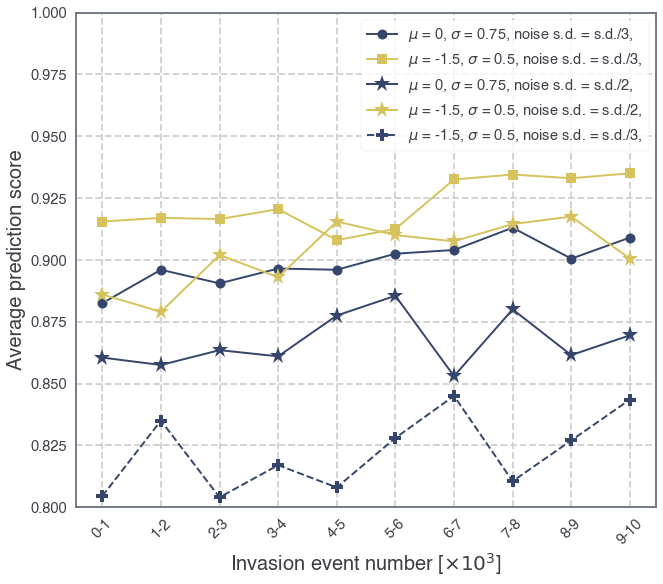

In [16]:
plt.rc( 'axes', prop_cycle=cycler.cycler(color = plt.cm.cividis( np.linspace(0.2,0.85,2)) ) )

# plt.plot([np.sum(pred_success[i*1000:(i+1)*1000])/1000 for i in range(10)],'-o', markersize=10, color = plt.cm.cividis(0.2), label = "$\mu$ = 0, $\sigma$ = 1")

# plt.plot([np.sum(s_rich[i*1000:(i+1)*1000])/1000 for i in range(10)], [np.sum(pred_success[i*1000:(i+1)*1000])/1000 for i in range(10)], '-s', markersize=10,label = "$\mu$ = -2, $\sigma$ = 1")

# plt.plot(srich_ecoasym1,'s', markersize=7, alpha = 0.3, color = plt.cm.cividis(0.85)) #, label = r"$\rho$ = 0.5, $\mu$ = -1.5, $\sigma$ = 0.5")
# plt.plot(srich_ecoasym2,'o', markersize=5, alpha = 1, color = plt.cm.cividis(0.85)) #, label = r"$\rho$ = 0.5, $\mu$ = 0, $\sigma$ = 0.75")
# plt.plot(srich_evo3,'s', markersize=7, alpha = 0.3, color = plt.cm.cividis(0.2)) #, label = r"$\rho$ = 0.8, $\mu$ = -1.5, $\sigma$ = 0.5")
# plt.plot(srich_evo4,'o', markersize=5, alpha = 1, color = plt.cm.cividis(0.2)) #, label = r"$\rho$ = 0.8, $\mu$ = 0, $\sigma$ = 0.75")


plt.plot([np.sum(dat_noise1[i*1000:(i+1)*1000])/1000 for i in range(10)],'-o', markersize=10,label = "$\mu$ = 0, $\sigma$ = 0.75, noise s.d. = s.d./3,")
plt.plot([np.sum(dat_noise2[i*1000:(i+1)*1000])/1000 for i in range(10)],'-s', markersize=10,label = "$\mu$ = -1.5, $\sigma$ = 0.5, noise s.d. = s.d./3,")
plt.plot([np.sum(dat_noise3[i*1000:(i+1)*1000])/1000 for i in range(10)],'-*', markersize=17.5,label = "$\mu$ = 0, $\sigma$ = 0.75, noise s.d. = s.d./2,")
plt.plot([np.sum(dat_noise4[i*1000:(i+1)*1000])/1000 for i in range(10)],'-*', markersize=17.5,label = "$\mu$ = -1.5, $\sigma$ = 0.5, noise s.d. = s.d./2,")
plt.plot([np.sum(dat_noise5[i*1000:(i+1)*1000])/1000 for i in range(10)],'--P', markersize=12.5,label = "$\mu$ = -1.5, $\sigma$ = 0.5, noise s.d. = s.d./3,")

# plt.plot([np.sum(datnoise1[i*1000:(i+1)*1000])/1000 for i in range(10)],'-o', markersize=10,label = "$\mu$ = 0, $\sigma$ = 1, Noise s.d. = s.d./5")
# plt.plot([np.sum(datnoise2[i*1000:(i+1)*1000])/1000 for i in range(10)],'-o', markersize=10,label = "$\mu$ = 0, $\sigma$ = 1, Noise s.d. = s.d./3")
# plt.plot([np.sum(datnoise3[i*1000:(i+1)*1000])/1000 for i in range(10)],'-o', markersize=10,label = "$\mu$ = 0, $\sigma$ = 1, Noise s.d. = s.d./2")

# plt.plot([np.sum(dat_eco7[j*50:(j+1)*50])/50 for j in range(len(dat_eco7)//50)],'-o', markersize=10,label = "$\mu$ = 0, $\sigma$ = 0.5")
# plt.plot([np.sum(dat_eco8[j*50:(j+1)*50])/50 for j in range(len(dat_eco8)//50)],'-s', markersize=10,label = "$\mu$ = -2, $\sigma$ = 1")
# plt.plot([np.sum(dat_eco9[j*50:(j+1)*50])/50 for j in range(len(dat_eco9)//50)],'-o', markersize=10,label = "$\mu$ = 0, $\sigma$ = 1")
# plt.plot([np.sum(dat_eco10[j*50:(j+1)*50])/50 for j in range(len(dat_eco10)//50)],'-s', markersize=10,label = "$\mu$ = -1.5, $\sigma$ = 0.5")

# plt.plot([np.sum(dat_ecoasym1[i*1000:(i+1)*1000])/1000 for i in range(10)],'-s', markersize=10, color = plt.cm.cividis(0.85), label = r"$\rho$ = 0.5, $\mu$ = -1.5, $\sigma$ = 0.5")
# plt.plot([np.sum(dat_ecoasym2[i*1000:(i+1)*1000])/1000 for i in range(10)],'-o', markersize=10, color = plt.cm.cividis(0.85), label = r"$\rho$ = 0.5, $\mu$ = 0, $\sigma$ = 0.75")
# plt.plot([np.sum(dat_evo3[i*1000:(i+1)*1000])/1000 for i in range(10)],'-s', markersize=10, color = plt.cm.cividis(0.2), label = r"$\rho$ = 0.8, $\mu$ = -1.5, $\sigma$ = 0.5")
# plt.plot([np.sum(dat_evo4[i*1000:(i+1)*1000])/1000 for i in range(10)],'-o', markersize=10, color = plt.cm.cividis(0.2), label = r"$\rho$ = 0.8, $\mu$ = 0, $\sigma$ = 0.75")

# plt.plot([np.sum(srich_varires_rand1[i*1000:(i+1)*1000])/1000 for i in range(10)], [np.sum(dat_varires_rand1[i*1000:(i+1)*1000])/1000 for i in range(10)], '-s', markersize=10, color = plt.cm.cividis(0.85), label = "$\mu$ = -2, $\sigma$ = 1")
# plt.plot([np.sum(srich_varires_rand2[i*1000:(i+1)*1000])/1000 for i in range(10)], [np.sum(dat_varires_rand2[i*1000:(i+1)*1000])/1000 for i in range(10)], '-o', markersize=10, color = plt.cm.cividis(0.2), label = "$\mu$ = 0, $\sigma$ = 1")

# plt.plot([np.sum(dat_rand1[j*50:(j+1)*50])/50 for j in range(len(dat_rand1)//50)],'-o', markersize=10,label = "$\mu$ = -2, $\sigma$ = 1")
# plt.plot([np.sum(dat_rand2[j*50:(j+1)*50])/50 for j in range(len(dat_rand2)//50)],'-o', markersize=10,label = "$\mu$ = 0, $\sigma$ = 1")

# plt.plot([np.sum(dat_type2[j*100:(j+1)*100])/100 for j in range(len(dat_type2)//100)],'-o', markersize=10)

# plt.xscale('log')
# plt.yscale('log')
# plt.xticks(np.arange(len(dat_type2)//100), ['0-100','100-200','200-300','300-400', '400-500', '500-600', '600-700', '700-800'], rotation=45) #, '300-350', '350-400', '400-450', '450-500', '500-550'], rotation=45)


ax = plt.gca()
ax.set_ylim([0.8, 1])

# # plt.xscale('log')
# # plt.yscale('log')
# plt.xticks(np.arange(10), ['0-1000','1000-2000','2000-3000','3000-4000', '4000-5000', '5000-6000', '6000-7000', '7000-8000', '8000-9000', '9000-10000'], rotation=45)
plt.xticks(np.arange(10), ['0-1','1-2','2-3','3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10'], rotation = 45) #'10-11', '11-12', '12-13', '13-14', '14-15', '15-16', '16-17', '17-18', '18-19', '19-20'], rotation=45)
plt.xlabel(r'Invasion event number [$ \times 10^3 $]', fontsize=20)
# plt.xlabel(r'Invasion event number', fontsize=20)

# plt.xlabel('Initial resident community size', fontsize=20)
plt.ylabel('Average prediction score', fontsize=20)
# plt.ylabel('Species Richness', fontsize=20)

plt.legend(loc='upper right')
plt.savefig('pred_success_noise1to5.eps', dpi=600, bbox_inches='tight')
plt.show()